# Error analysis notebook (validation data)

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json
from elasticsearch import Elasticsearch
es = Elasticsearch([{'timeout':200}])


/home/pilmus/thesis/venv37/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Set filepaths

In [2]:
ranking_ac_A_9 = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_9_linear_author_none_train.json'
ranking_ac_A_99 = '../evaluation/resources/2020/jsonruns/ac_controller_train10_meta_99_linear_author_none_train.json'
ranking_ac_B_9 = '../evaluation/resources/2020/jsonruns/ac_controller_train10_text_9_linear_author_none_train.json'
ranking_ac_B_99 = '../evaluation/resources/2020/jsonruns/ac_controller_train10_text_99_linear_author_none_train.json'

ranking_A = '../evaluation/resources/2020/jsonruns/relevance_ranker_train_90_10_split_META_train.json'
ranking_B = '../evaluation/resources/2020/jsonruns/relevance_ranker_train_90_10_split_TEXT_train.json'

# ranking_lm = '../evaluation/resources/2020/jsonruns/lambdamart_mrfr_train_90_10_split_lm_ndcg_nofeat_random_state=0.json'

eval_result_ac_A_9_eel = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_ac_A_99_eel = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_99_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_ac_B_9_eel = '../evaluation/resources/2020/eval_results/ac_controller_train10_text_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_ac_B_99_eel = '../evaluation/resources/2020/eval_results/ac_controller_train10_text_99_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'

eval_result_ac_A_9_err = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'
eval_result_ac_A_99_err = '../evaluation/resources/2020/eval_results/ac_controller_train10_meta_99_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'
eval_result_ac_B_9_err = '../evaluation/resources/2020/eval_results/ac_controller_train10_text_9_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'
eval_result_ac_B_99_err = '../evaluation/resources/2020/eval_results/ac_controller_train10_text_99_linear_author_none_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'

eval_result_A_eel = '../evaluation/resources/2020/eval_results/relevance_ranker_train_90_10_split_META_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_A_err = '../evaluation/resources/2020/eval_results/relevance_ranker_train_90_10_split_META_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'
eval_result_B_eel = '../evaluation/resources/2020/eval_results/relevance_ranker_train_90_10_split_TEXT_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_EEL.tsv'
eval_result_B_err = '../evaluation/resources/2020/eval_results/relevance_ranker_train_90_10_split_TEXT_train_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels_ERR.tsv'


# eval_result_lm ='../evaluation/resources/2020/eval_results/lambdamart_mrfr_train_90_10_split_lm_ndcg_nofeat_random_state=0_TREC-Fair-Ranking-training-sample_-10-full-annotations-DocHLevel-mixed_group-qrels.tsv'


gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'

erels_A = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
erels_B = '../reranking/resources/relevances/Training_rel_scores_model_B.csv'


annotations = '../pre_pre_processing/resources/merged-annotations.json'
mapping = '../reranking/resources/mappings/doc_to_author.json'

## Prepare dataframes

In [3]:
def eval_results_to_df(eval_result):
    df = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
    df = df.pivot(index='qid', columns='key', values='value')
    df = df.reset_index()
    df = df.sort_values('difference')
    return df

In [4]:
# ranking df
rdf_ac_A_9 = pd.read_json(ranking_ac_A_9, lines=True)
rdf_ac_A_99 = pd.read_json(ranking_ac_A_99, lines=True)
rdf_ac_B_9 = pd.read_json(ranking_ac_B_9, lines=True)
rdf_ac_B_99 = pd.read_json(ranking_ac_B_99, lines=True)

rdf_A = pd.read_json(ranking_A, lines=True)
rdf_B = pd.read_json(ranking_B, lines=True)


# rdf_lm = pd.read_json(ranking_lm, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]


# eval result dfs
edf_ac_A_9_eel = eval_results_to_df(eval_result_ac_A_9_eel).sort_values(by='difference', ascending=False)
edf_ac_A_99_eel = eval_results_to_df(eval_result_ac_A_99_eel).sort_values(by='difference', ascending=False)
edf_ac_B_9_eel = eval_results_to_df(eval_result_ac_B_9_eel).sort_values(by='difference', ascending=False)
edf_ac_B_99_eel = eval_results_to_df(eval_result_ac_B_99_eel).sort_values(by='difference', ascending=False)

edf_ac_A_9_err = eval_results_to_df(eval_result_ac_A_9_err).sort_values(by='difference', ascending=False)
edf_ac_A_99_err = eval_results_to_df(eval_result_ac_A_99_err).sort_values(by='difference', ascending=False)
edf_ac_B_9_err = eval_results_to_df(eval_result_ac_B_9_err).sort_values(by='difference', ascending=False)
edf_ac_B_99_err = eval_results_to_df(eval_result_ac_B_99_err).sort_values(by='difference', ascending=False)


edf_A_eel = eval_results_to_df(eval_result_A_eel).sort_values(by='difference', ascending=False)
edf_A_err = eval_results_to_df(eval_result_A_err).sort_values(by='difference', ascending=False)

edf_B_eel = eval_results_to_df(eval_result_B_eel).sort_values(by='difference', ascending=False)
edf_B_err = eval_results_to_df(eval_result_B_err).sort_values(by='difference', ascending=False)


# est rel df
ereldf_A = pd.read_csv(erels_A)
ereldf_B = pd.read_csv(erels_B)

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# doc to author and reverse mapping
with open(mapping) as fp:
    doc_to_author = json.load(fp)

author_to_doc = {}
for doc, aulist in doc_to_author.items():
    for au in aulist:
        if not au in author_to_doc:
            author_to_doc[au] = []
        author_to_doc[au] = author_to_doc[au] + [doc]
noauth_docids = list(filter( lambda x: doc_to_author[x] == [],doc_to_author.keys()))

### EEL for each configuration

In [5]:
print('ac a 9 :\t', round(edf_ac_A_9_err.difference.mean(),3), round(edf_ac_A_9_err.disparity.mean(),3), round(edf_ac_A_9_err.relevance.mean(),3), round(edf_ac_A_9_eel.difference.mean(),3), round(edf_ac_A_9_eel.disparity.mean(),3), round(edf_ac_A_9_eel.relevance.mean(),3))
print('ac a 99:\t', round(edf_ac_A_99_err.difference.mean(),3), round(edf_ac_A_99_err.disparity.mean(),3), round(edf_ac_A_99_err.relevance.mean(),3), round(edf_ac_A_99_eel.difference.mean(),3), round(edf_ac_A_99_eel.disparity.mean(),3), round(edf_ac_A_99_eel.relevance.mean(),3))
print('ac b 9 :\t', round(edf_ac_B_9_err.difference.mean(),3), round(edf_ac_B_9_err.disparity.mean(),3), round(edf_ac_B_9_err.relevance.mean(),3), round(edf_ac_B_9_eel.difference.mean(),3), round(edf_ac_B_9_eel.disparity.mean(),3), round(edf_ac_B_9_eel.relevance.mean(),3))
print('ac b 99:\t', round(edf_ac_B_99_err.difference.mean(),3), round(edf_ac_B_99_err.disparity.mean(),3), round(edf_ac_B_99_err.relevance.mean(),3), round(edf_ac_B_99_eel.difference.mean(),3), round(edf_ac_B_99_eel.disparity.mean(),3), round(edf_ac_B_99_eel.relevance.mean(),3))


ac a 9 :	 0.515 0.238 0.139 0.498 1.653 1.124
ac a 99:	 0.474 0.209 0.145 0.453 1.609 1.124
ac b 9 :	 0.536 0.247 0.133 0.526 1.681 1.124
ac b 99:	 0.535 0.248 0.134 0.516 1.67 1.124


## Extract information for specific query

Helper methods.

In [6]:
def extract_resultsd_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevancesd_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [7]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevancesd_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


## Methods

In [8]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [9]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

### Methods count per rank

In [10]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df, cutoff=None):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    if cutoff is None:
        cutoff = len(rankings_df['ranking'].iloc[0])
    countdict = {k :{'r':0,'nr':0} for k in range(1,cutoff + 1)}
    
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking'][:cutoff]):
            
            
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [11]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [12]:
def plot_rel_nonrel_per_rank_per_relkind(data,num_rel,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    pi2 = iter(sns.color_palette('dark'))
    f = next(pi)
    f2 = next(pi2)
    s = next(pi)
    s2 = next(pi2)
    next(pi)
    next(pi2)
    t = next(pi)
    t2 = next(pi2)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    colorsf = [f] * num_rel + [f2] * (len(data) - num_rel)
    colorss = [s] * num_rel + [s2] * (len(data) - num_rel)
    
    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],palette=sns.color_palette(colorsf))
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],palette=sns.color_palette(colorss))

    if regline:
        colorst = [t] * num_rel + [t2] * (len(data) - num_rel)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, palette=sns.color_palette(colorst))
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},palette=sns.color_palette(colorst))
    return fig


In [13]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_resultsd_on_qid(qid, ranking)
    subrelevance = extract_relevancesd_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,num_rel_docs,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}, top={num_rel_docs}")
    

### Methods doc occurrence in top positions

In [14]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [15]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [16]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [17]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
    subranking = extract_resultsd_on_qid(qid, ranking)
    subrelevance = extract_relevancesd_on_qid(qid, relevance)

    doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
    rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)

    fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
    fig.suptitle(f"Document counts per rank for {qid}")
    
    

### Methods number of times a doc is in a top position

In [18]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [19]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)
    
    m = pd.merge(unpacked_df,relevance_df[['doc_id','doc_rel']],on='doc_id',how='left')
    return m.drop_duplicates()

In [20]:
def document_pos_count_df_for_qid(qid,ranking,relevance):
    subranking = extract_resultsd_on_qid(qid, ranking)
    subrelevance = extract_relevancesd_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)

    
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    return doc_pos_count_df
    

In [21]:
def plot_doc_pos_count(data,numrel,numnrel,sortby=['count'],no_author_ids=None,plotthese=['top', 'bot']):
    """Plot how many times each document occurred in the top and bottom positions."""
    
    
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    

    if 'top' in plotthese and 'bot' in plotthese:
        fig, ax = plt.subplots(1, 2, figsize = (18, 8))
        _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
        _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

        for i, pos in enumerate(plotthese):
            _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
            thisaxdata = data[data['pos'] == pos].sort_values(by=sortby,ascending=False)

            clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
            sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])

            if no_author_ids:
                thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
                sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')

            ax[i].legend(labels=["rel","nonrel"], title='relkind')

            leg = ax[i].get_legend()
            leg.legendHandles[0].set_color(first)
            leg.legendHandles[1].set_color(second)


    else: 
        fig, ax = plt.subplots(1, 1, figsize = (10, 8))
        if 'top' in plotthese:
            _ = ax.title.set_text(f'Occurrence of doc in top pos (k={numrel})')
        elif 'bot' in plotthese:
            _ = ax.title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

        _ = ax.set_xticklabels(ax.get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == plotthese].sort_values(by=sortby,ascending=False) 
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax)
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax,hatch='//')

        ax.legend(labels=["rel","nonrel"], title='relkind')

        leg = ax.get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)

        
  
    return fig


In [22]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance,sortby=['count'], no_author_ids=None,plotthese=['top','bot']):
    doc_pos_count_df = document_pos_count_df_for_qid(qid,ranking,relevance)
    subrelevance = extract_relevancesd_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,sortby=sortby,no_author_ids=no_author_ids,plotthese=plotthese)

    fig.suptitle(f"Document position counts {qid}")

### Methods

#### Percentage of (non)-relevant documents in range

In [23]:
def percentage_relgrade_in_range(eval_results,ranking,global_reldf,k):
    relfrac = []
    for q in eval_results.head(k).qid.to_list():
        subrdf = extract_resultsd_on_qid(q, ranking)
        subreldf = extract_relevancesd_on_qid(q, global_reldf)


        num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)

        rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
        rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)

        # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
        # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)

        top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (150 * num_rel_docs) * 100,2)
        relfrac.append(top_with_rel_frac)
        print(q, "\t", top_with_rel_frac)
    return relfrac

In [24]:
def count_top_pos_occupied_by(qid,ranking,relevance):
    data = ranking.query(f'qid == {qid}')
    reldata = relevance.query(f'qid == {qid}')
    
    relc, relnc = count_relgrades(reldata)
    rnr_counts = count_rel_nonrel_per_rank(data,reldata,cutoff=relc)
    
    
    total_rel = sum([c['r'] for c in rnr_counts.values()])
    return total_rel

In [25]:
def percentage_top_pos_occupied_by(qid,ranking,relevance):
    data = ranking.query(f'qid == {qid}')
    reldata = relevance.query(f'qid == {qid}')
    
    relc, relnc = count_relgrades(reldata)
    rnr_counts = count_rel_nonrel_per_rank(data,reldata,cutoff=relc)
    
    total_pos = relc * 150
    total_rel = sum([c['r'] for c in rnr_counts.values()])
    return total_rel/total_pos*100

In [26]:
def ranking_to_df(ranking, relevance):
    ranking = ranking[['qid','ranking']].reset_index(drop=True)
    ranking = ranking.explode('ranking')
    ranking['rank'] = ranking.groupby(level=0).cumcount()
    ranking = ranking.reset_index(drop=True)
    ranking = ranking.rename({'ranking':'doc_id'},axis=1)
    merge = pd.merge(ranking,relevance[['qid','doc_id','doc_rel']], on = ['qid', 'doc_id'], how='left')
    merge['rel'] = merge['doc_rel'].apply(lambda row: 'rel' if row == 1 else 'nonrel')
    return merge

In [27]:
def questions1to3(qid, ranking, relevance, printthese=['toprels','topnrels','botrels']):
    data = ranking[ranking.qid == qid]
    relc, _ = count_relgrades_qid(qid,relevance)
    tops = data.query(f'rank < {relc}')
    bots = data.query(f'rank >= {relc}')
    
    topdocs = tops[['doc_id','doc_rel']].value_counts().reset_index(name="count").query(f"count > {tops.doc_id.value_counts().mean()}")
    botrels = data.query(f"doc_id not in {topdocs.doc_id.to_list()} and doc_rel == 1").doc_id.drop_duplicates().to_list()
#     print(topdocs)
#     print(botdocs)
    
    toprels = topdocs.query('doc_rel == 1').doc_id.to_list()
    topnrels = topdocs.query('doc_rel == 0').doc_id.to_list()
    # botrels = bots.query('doc_rel == 1').doc_id.to_list()
    
    if 'toprels' in printthese:
        print('toprels')
        for d in toprels:
            print(d)
        print()
    
    if 'topnrels' in printthese:
        print('topnrels')
        for d in topnrels:
            print(d)
        print()
    
    if 'botrels' in printthese:
        print('botrels')
        for d in botrels:
            print(d)
        print()
        
    

In [28]:
def questions1to3docs(qid, ranking, relevance):
    data = ranking[ranking.qid == qid]
    relc, _ = count_relgrades_qid(qid,relevance)
    tops = data.query(f'rank < {relc}')
    bots = data.query(f'rank >= {relc}')
    
    topdocs = tops[['doc_id','doc_rel']].value_counts().reset_index(name="count").query(f"count > {tops.doc_id.value_counts().mean()}")
    botrels = data.query(f"doc_id not in {topdocs.doc_id.to_list()} and doc_rel == 1").doc_id.drop_duplicates().to_list()
#     print(topdocs)
#     print(botdocs)
    
    toprels = topdocs.query('doc_rel == 1').doc_id.to_list()
    topnrels = topdocs.query('doc_rel == 0').doc_id.to_list()
    # botrels = bots.query('doc_rel == 1').doc_id.to_list()
    
    return toprels, topnrels, botrels
    

## Error analysis template
For each ranker and grouping, we answer the following questions to gain insight into the points of failure of the ranker.

1. How often were top positions occupied by relevant documents? Can these documents be categorized and distinguished from other documents?
2. How often were top positions occupied by non-relevant documents? Can these documents be categorized and distinguished from other documents?
3. Which relevant documents appear rarely or not at all in the top positions? Why did these documents not appear in the top positions more often?
4. What did the system think were the important terms of the original query, and were they good?
5. Is the performance of the system in terms of EEL𝑖𝑛𝑑 or EELℎ mostly due to high disparity, low relevance, or both?
6. What obvious mistakes did the system make that it could have easily avoided?
7. Other features of note  
8. What added information would help performance? How can the system get that information?
9. Are there differences between the official assessment of documents and your own assessment?


## Performance stats

## Difficulty according to each ranking config

#### EEL

In [29]:
n = 10
print("k\tA9\tA99\tB9\tB99")
for c, (i, j, k, l) in enumerate(zip(edf_ac_A_9_eel.qid.to_list()[:n],edf_ac_A_99_eel.qid.to_list()[:n],edf_ac_B_9_eel.qid.to_list()[:n],edf_ac_B_99_eel.qid.to_list()[:n])):
        print(f"{c+1}:\t{i}\t{j}\t{k}\t{l}")

k	A9	A99	B9	B99
1:	31412	31412	31412	31412
2:	30631	30631	30631	30631
3:	43018	43018	43018	43018
4:	20363	25869	20363	20363
5:	25869	20363	25869	25869
6:	51432	70673	70673	70673
7:	70673	8940	8940	8940
8:	8940	67404	51432	67404
9:	67404	49766	49766	49766
10:	49766	12096	67404	64062


#### ERR

In [30]:
n = 10
print("k\tA9\tA99\tB9\tB99")
for c, (i, j, k, l) in enumerate(zip(edf_ac_A_9_err.qid.to_list()[:n],edf_ac_A_99_err.qid.to_list()[:n],edf_ac_B_9_err.qid.to_list()[:n],edf_ac_B_99_err.qid.to_list()[:n])):
        print(f"{c+1}:\t{i}\t{j}\t{k}\t{l}")

k	A9	A99	B9	B99
1:	30631	30631	30631	30631
2:	31412	31412	31412	54003
3:	12828	54003	54003	31412
4:	54003	43018	12828	12828
5:	43018	12096	43018	43018
6:	12096	12828	70673	70673
7:	70673	70673	12096	12096
8:	67404	67404	8940	66637
9:	66637	8940	67404	8940
10:	8940	66637	66637	67404


## Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

### EEL

#### edf_ac_A_9

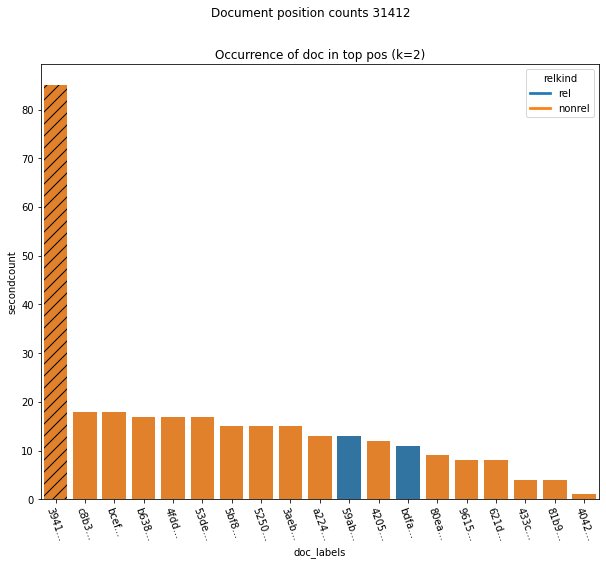

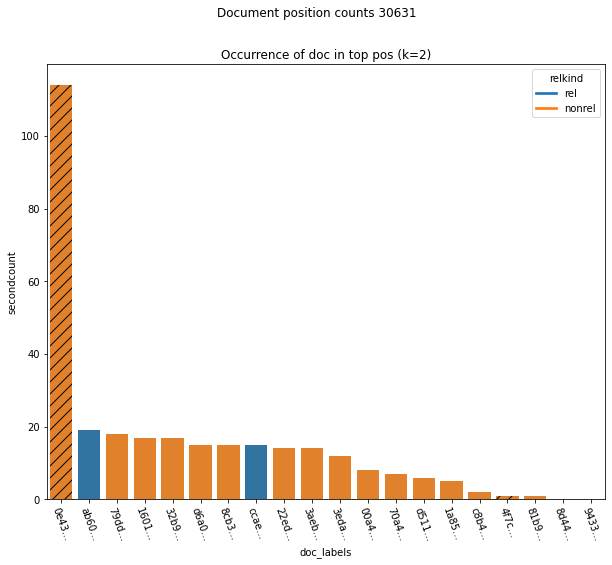

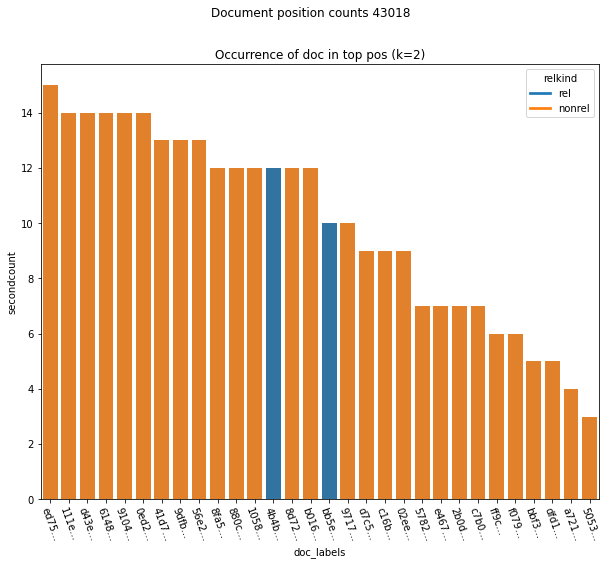

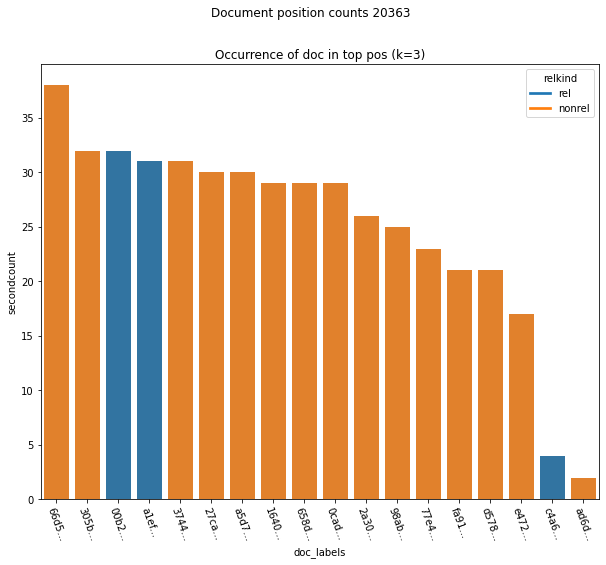

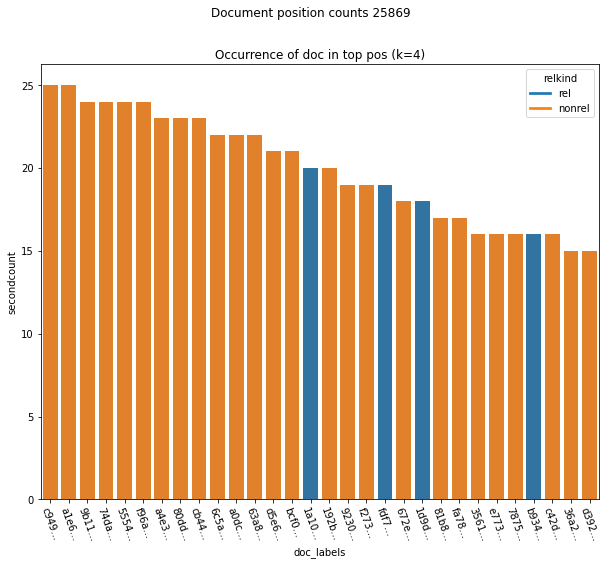

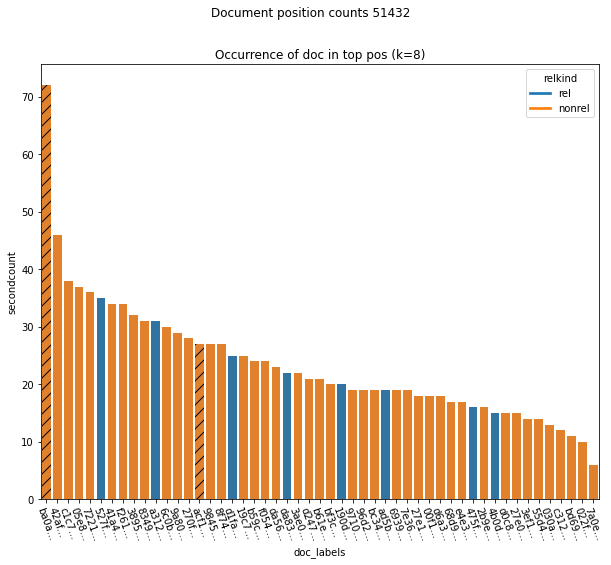

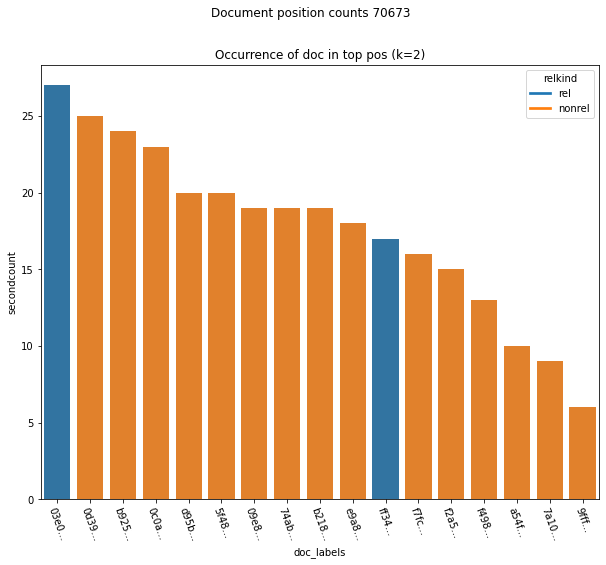

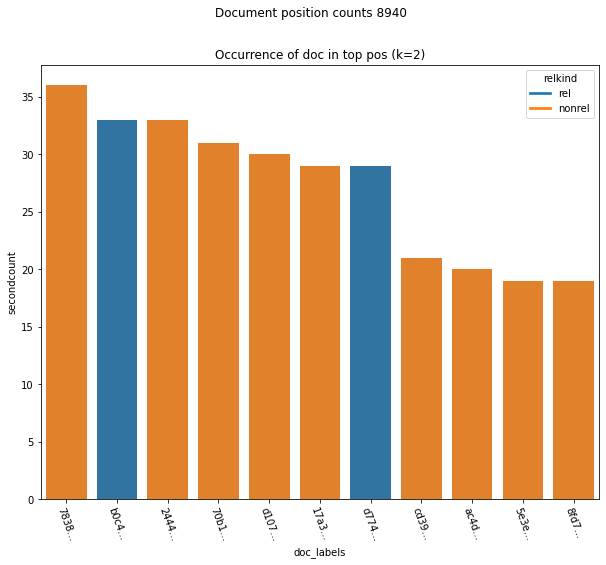

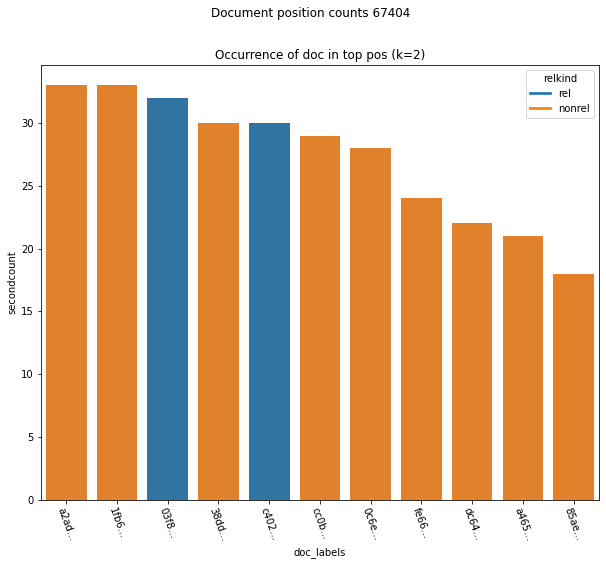

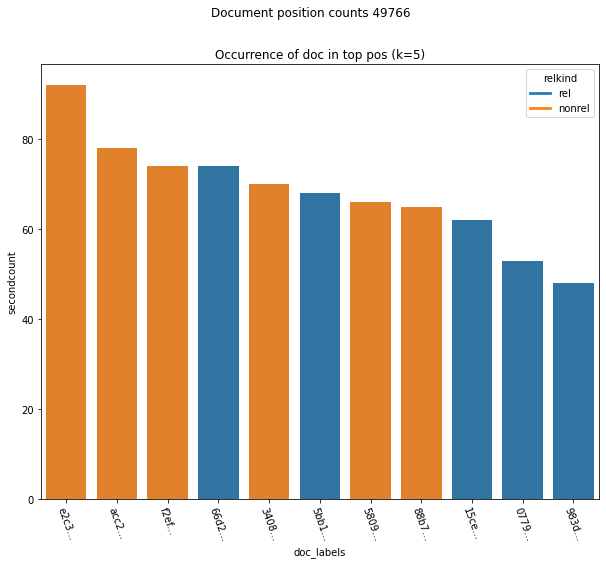

In [31]:
n = 10
for i, q in enumerate(edf_ac_A_9_eel.qid.to_list()[:n]):
    plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')
    
    

#### edf_ac_A_99

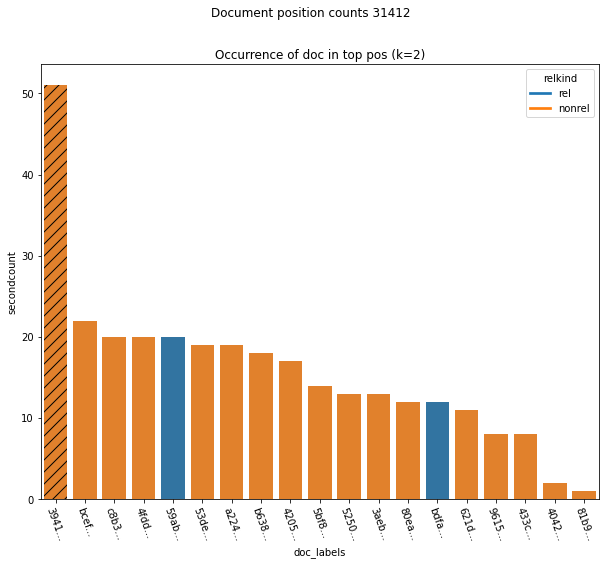

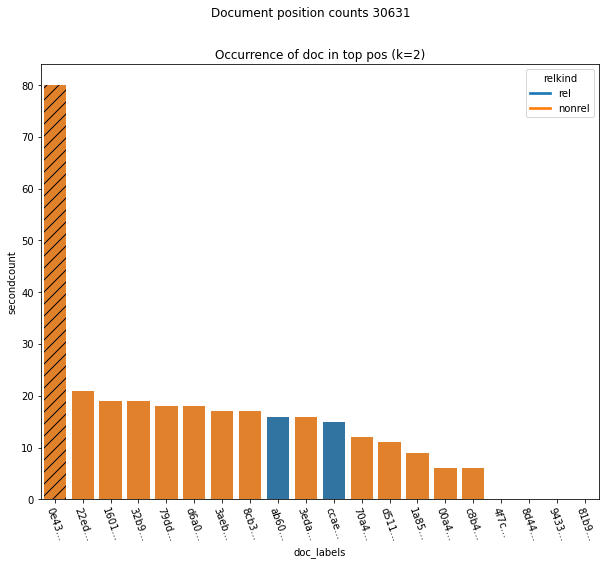

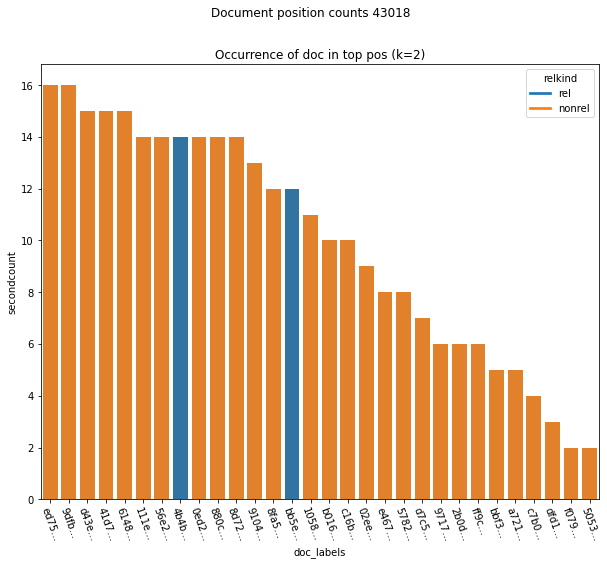

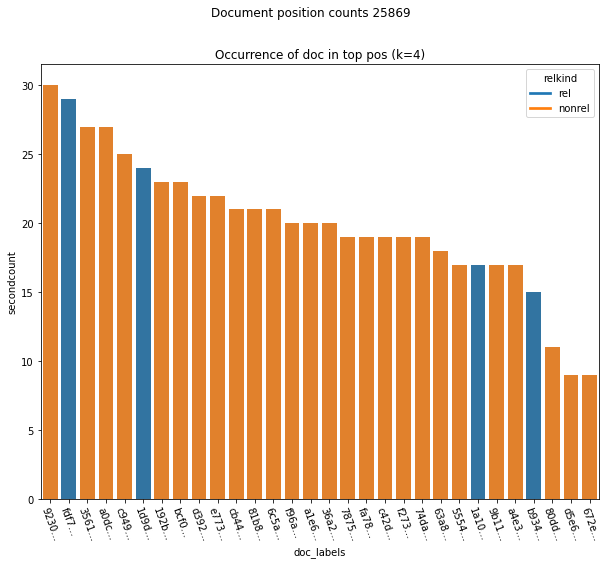

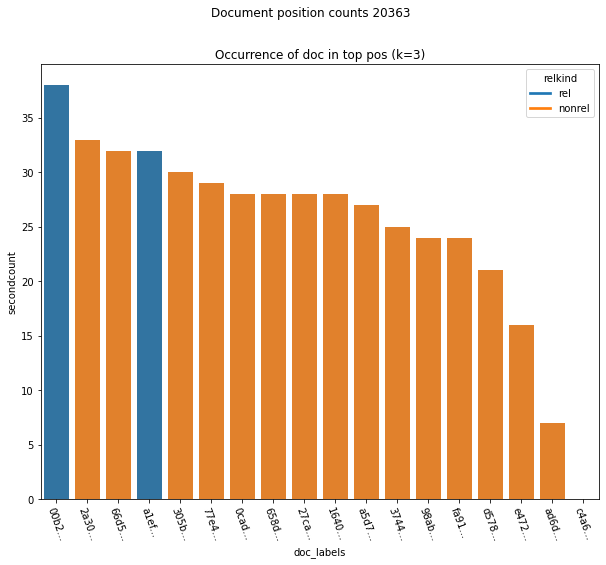

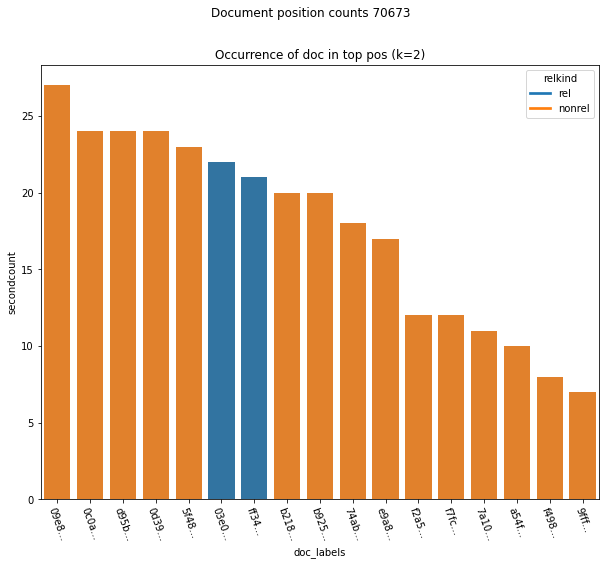

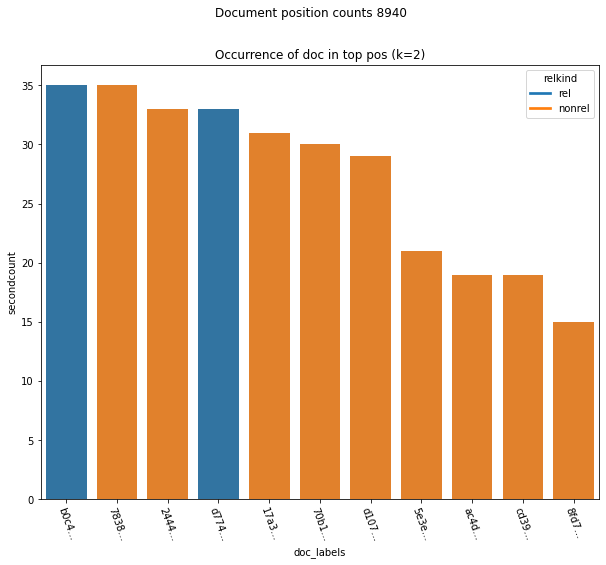

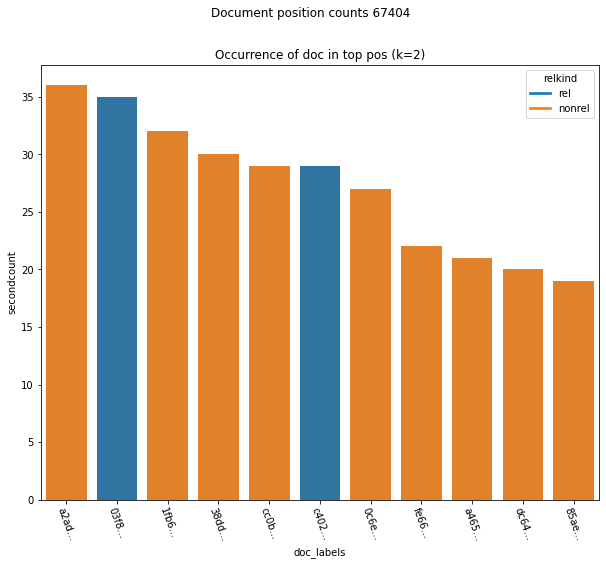

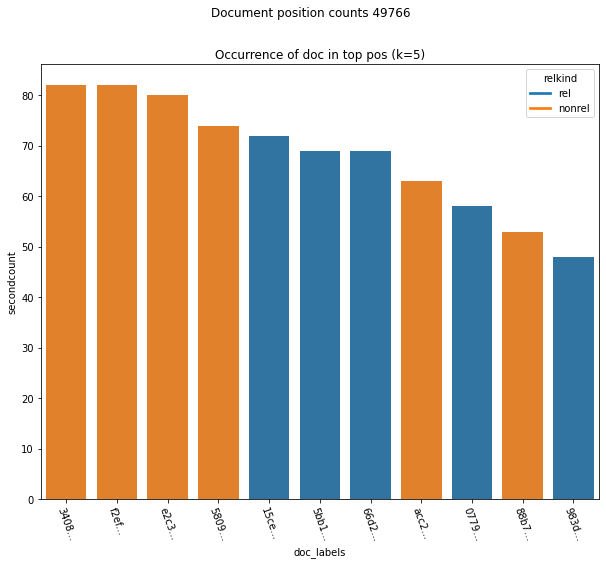

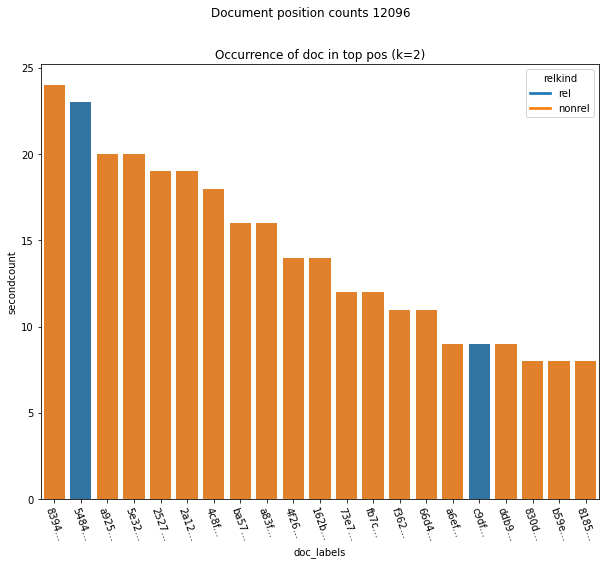

In [32]:
n = 10
for q in edf_ac_A_99_eel.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_A_99,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

#### edf_ac_B_9

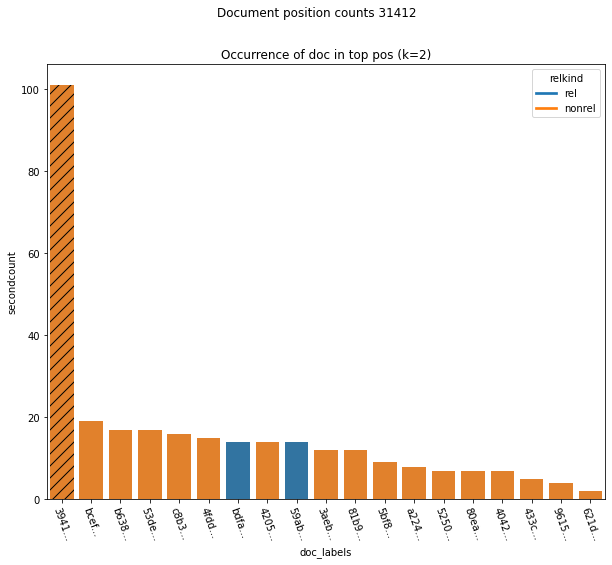

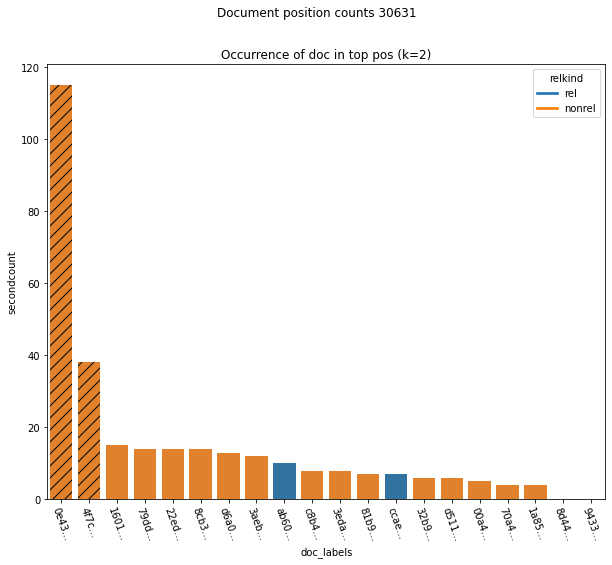

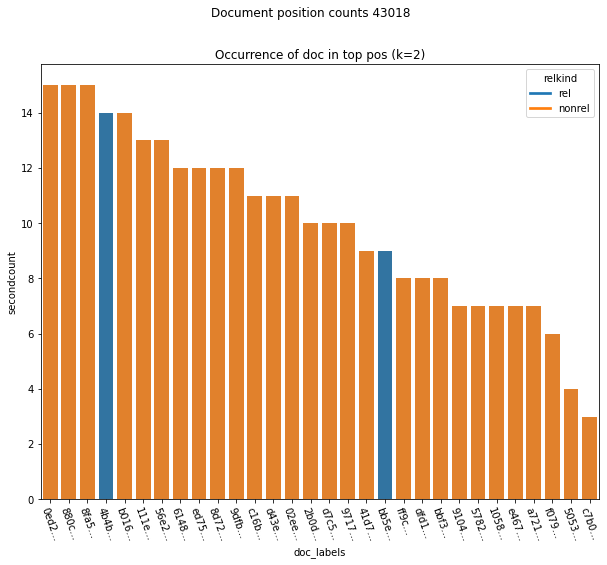

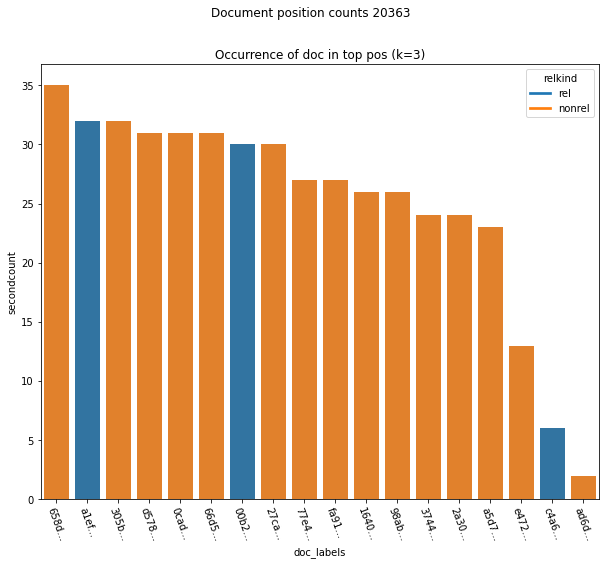

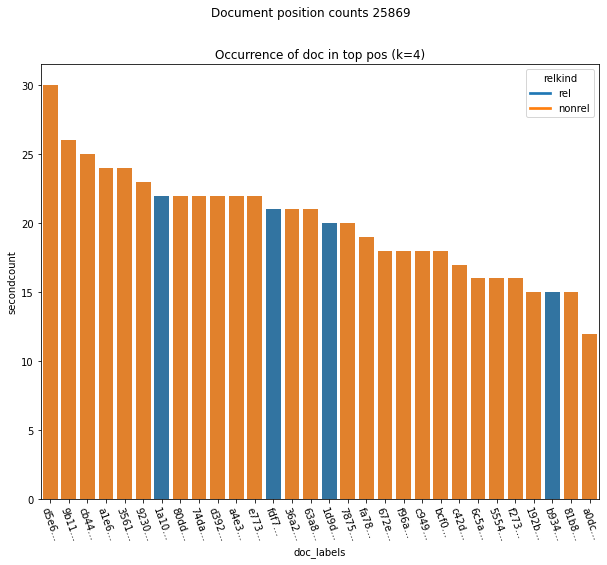

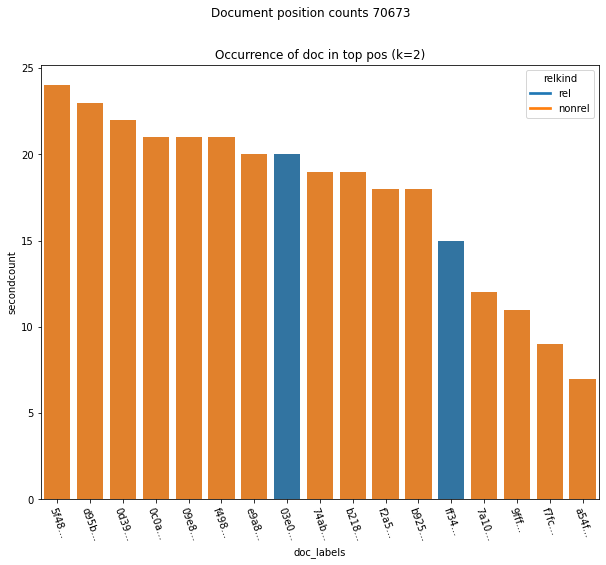

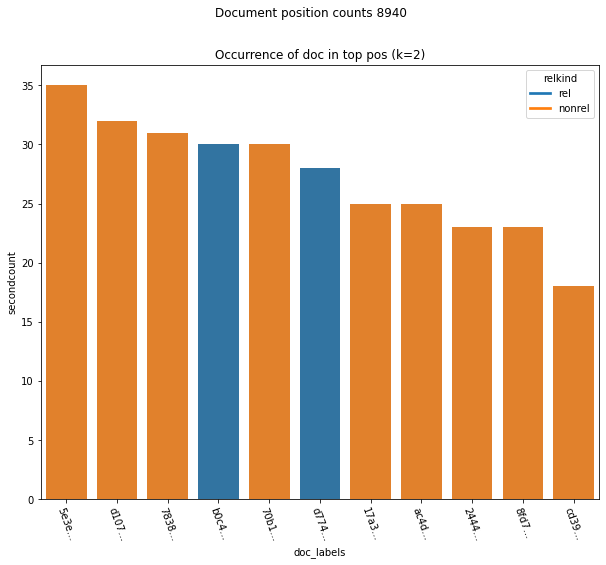

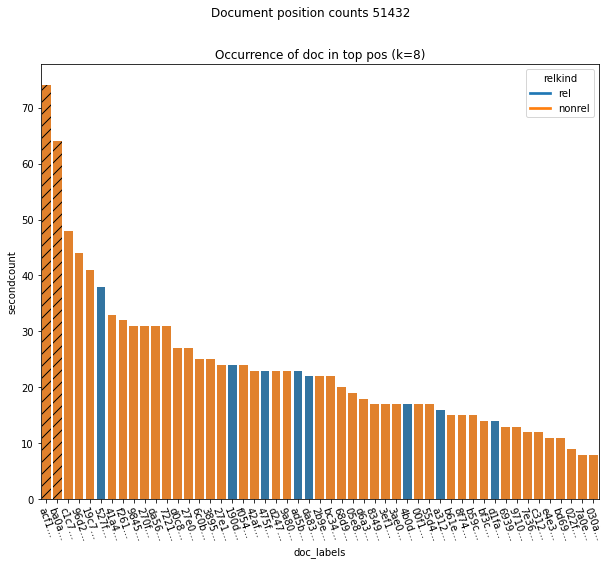

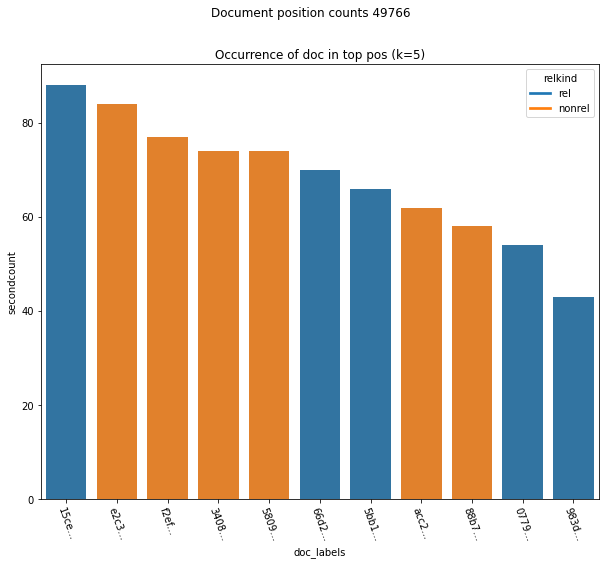

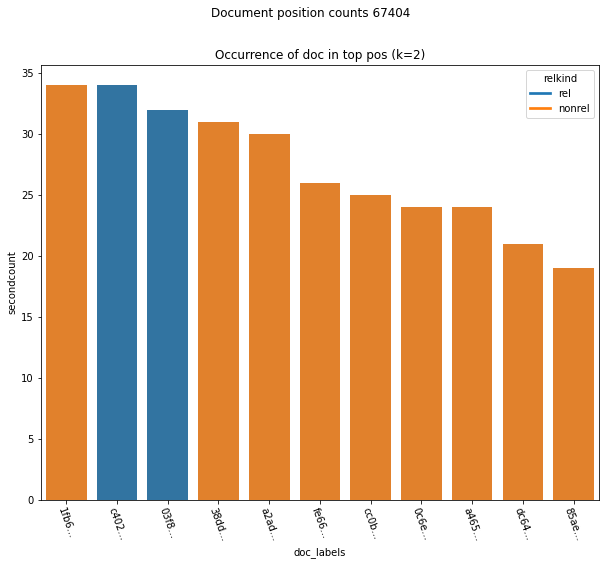

In [33]:
n = 10
for q in edf_ac_B_9_eel.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_B_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

#### edf_ac_B_99

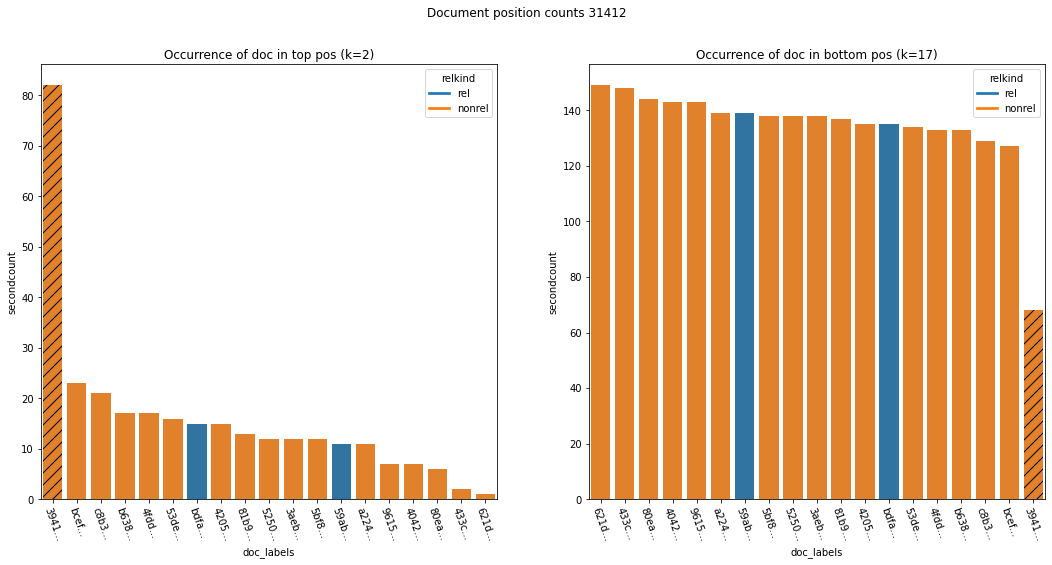

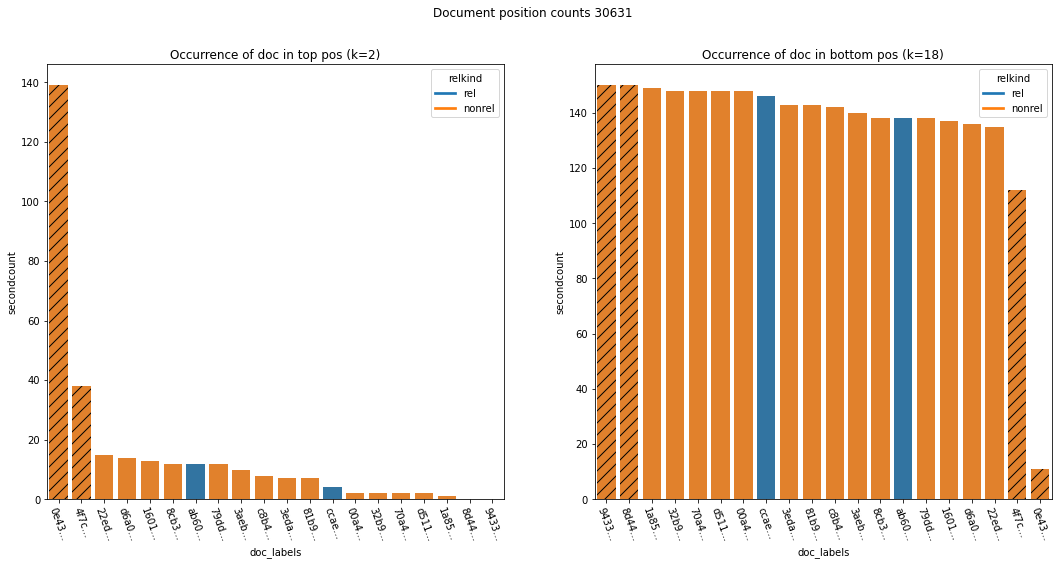

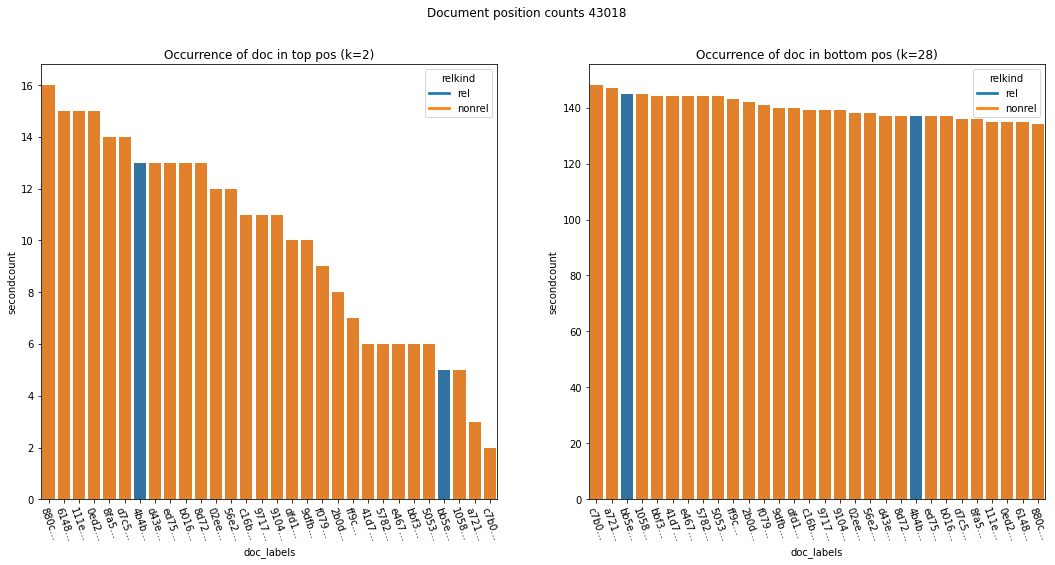

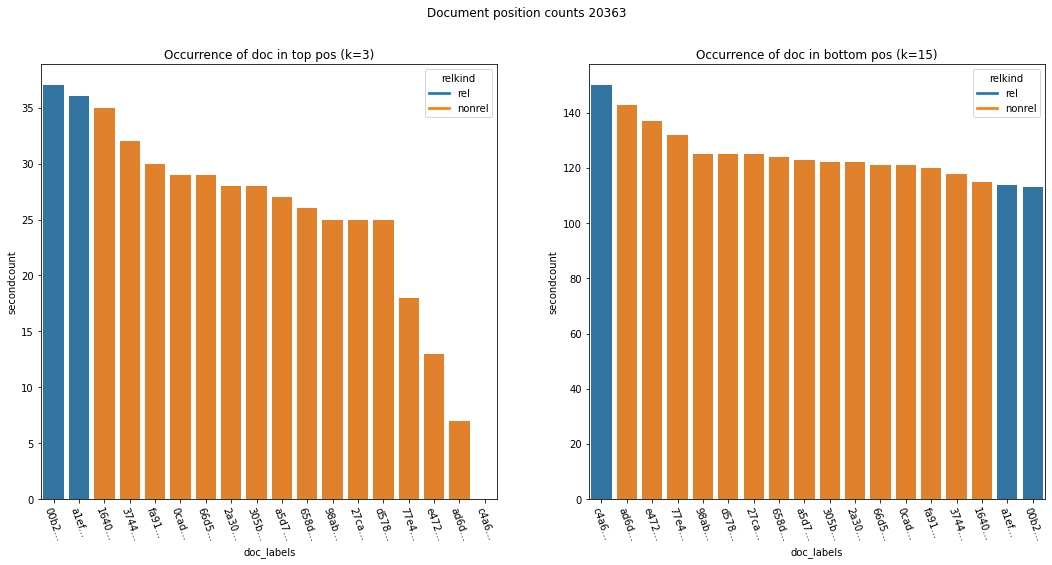

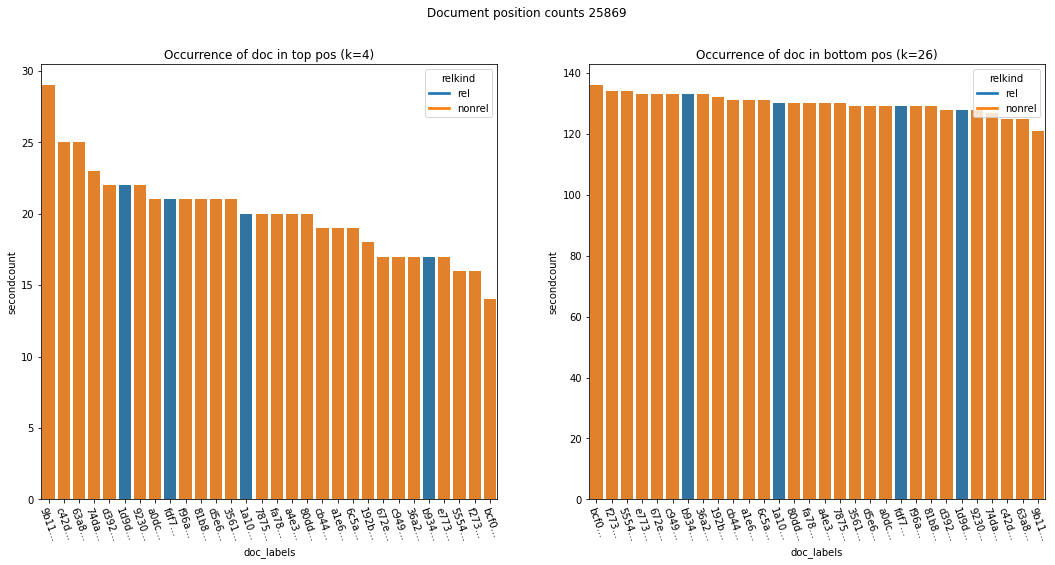

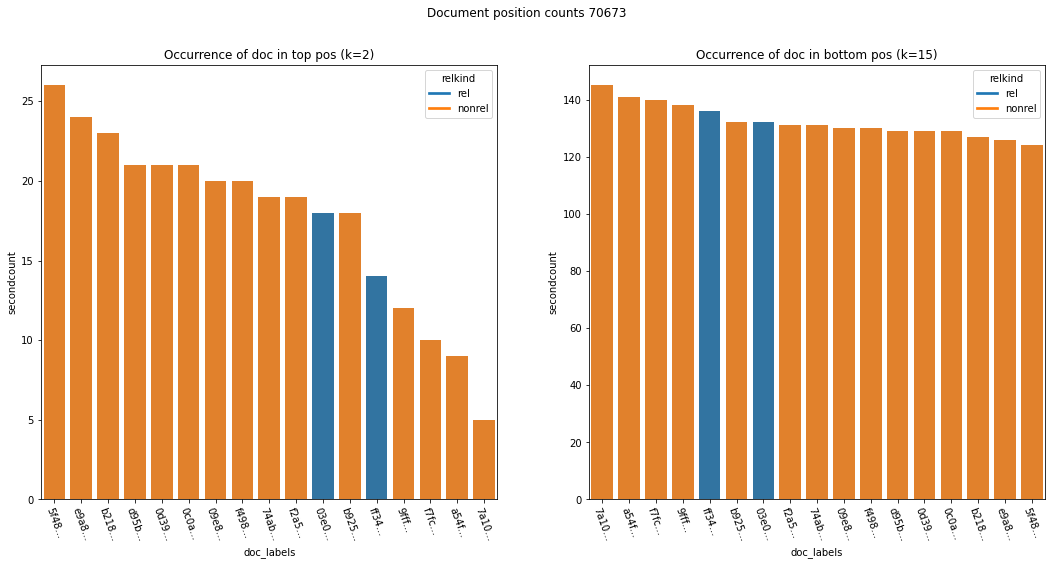

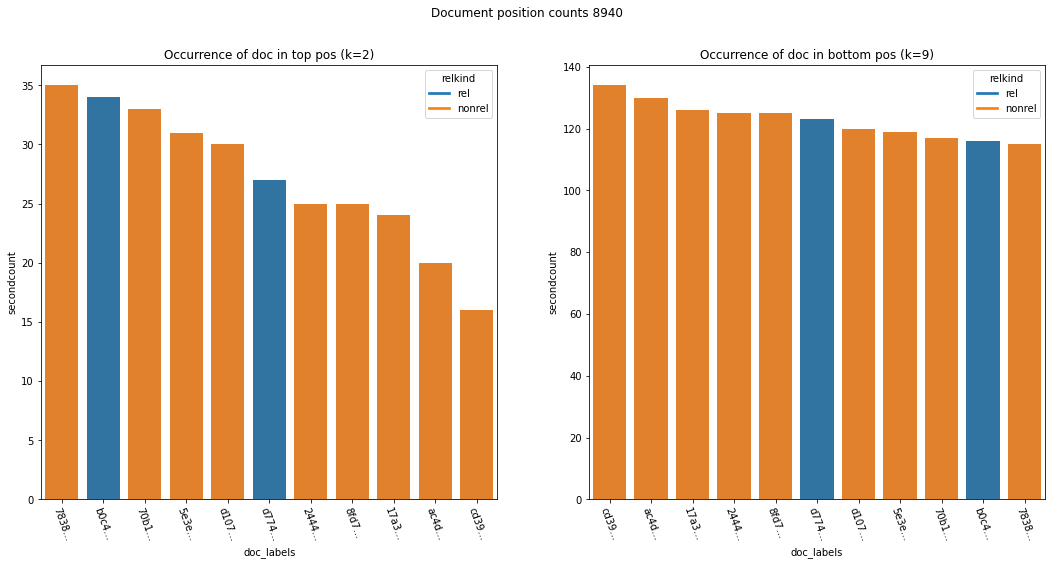

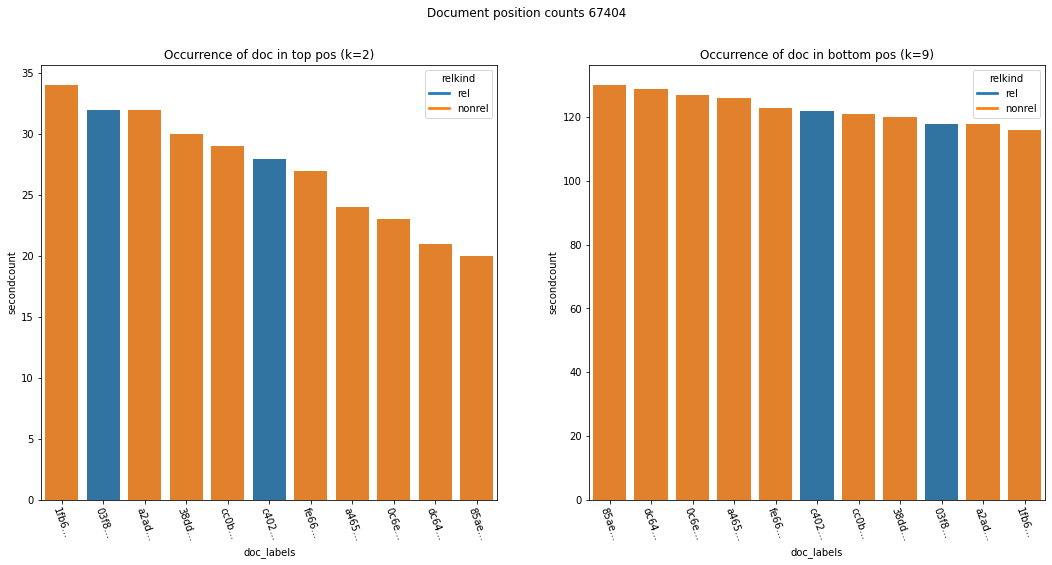

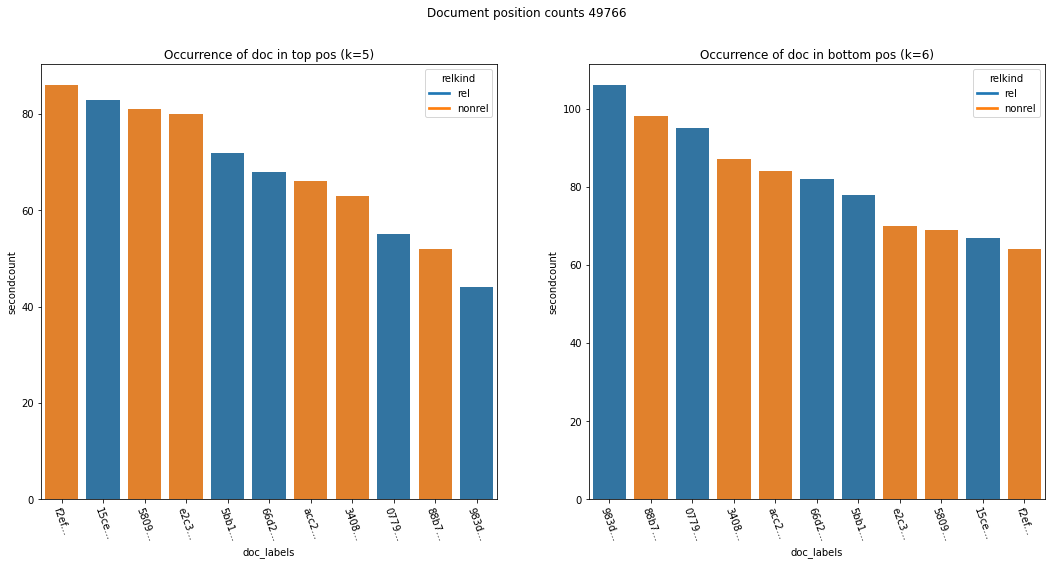

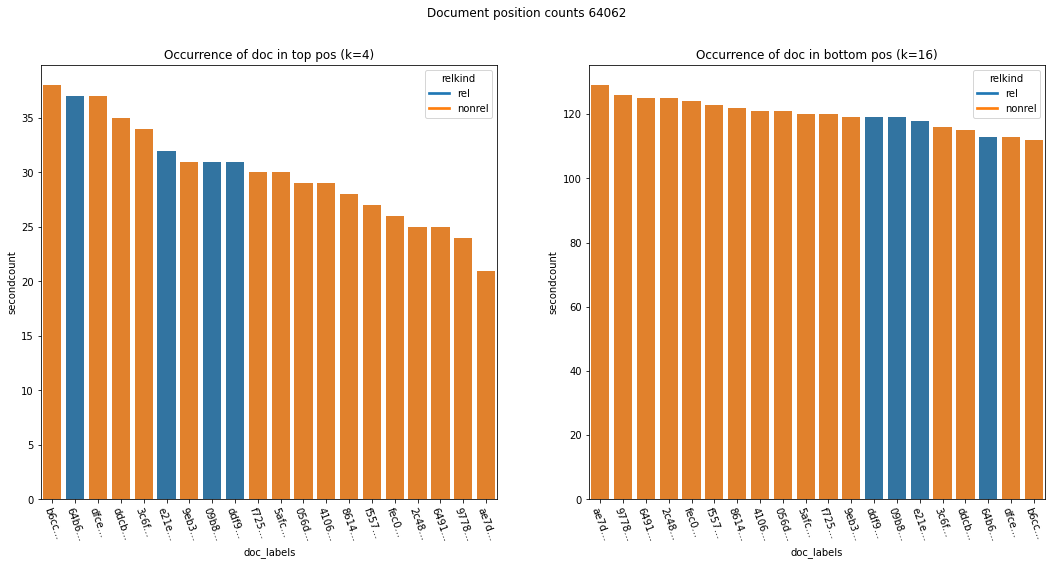

In [34]:
n = 10
for q in edf_ac_B_99_eel.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_B_99,reldf,sortby=['count'], no_author_ids=noauth_docids)

### ERR

#### edf_ac_A_9

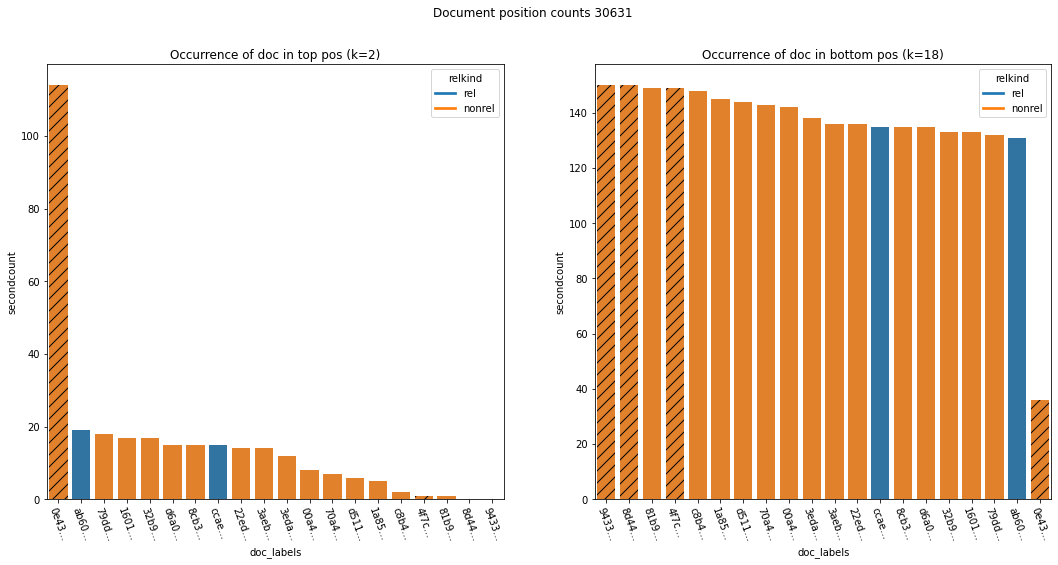

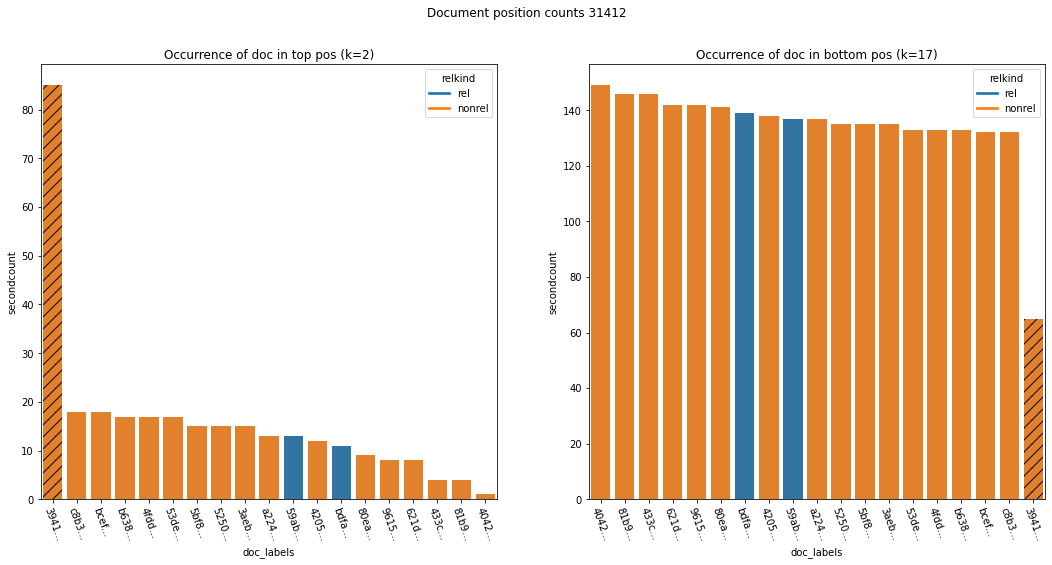

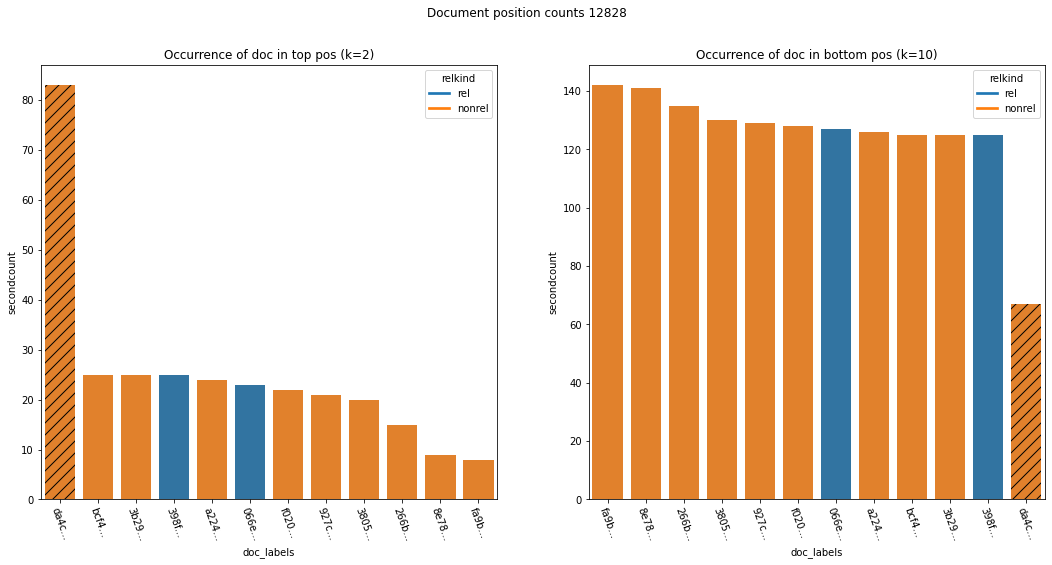

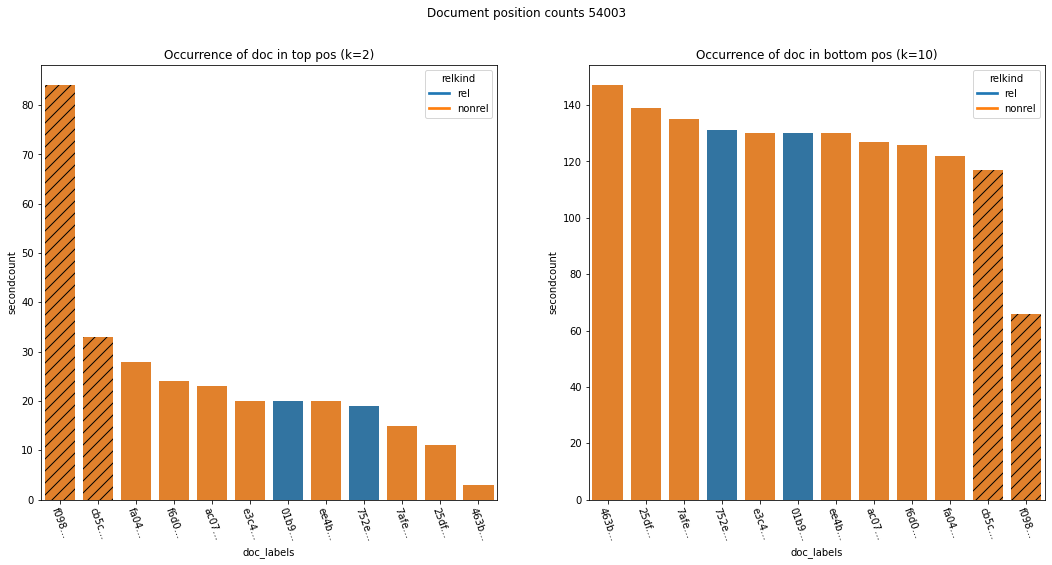

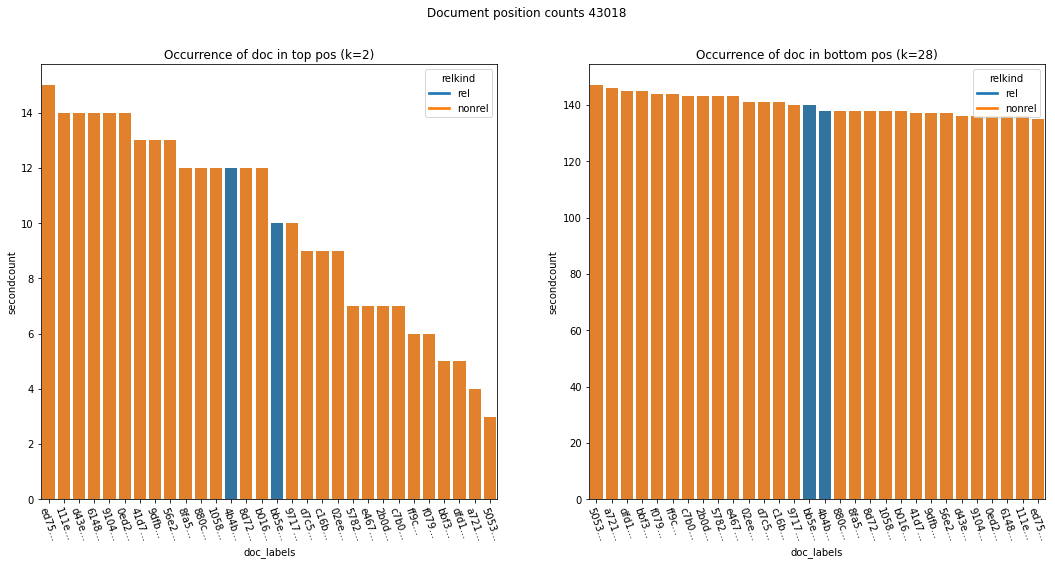

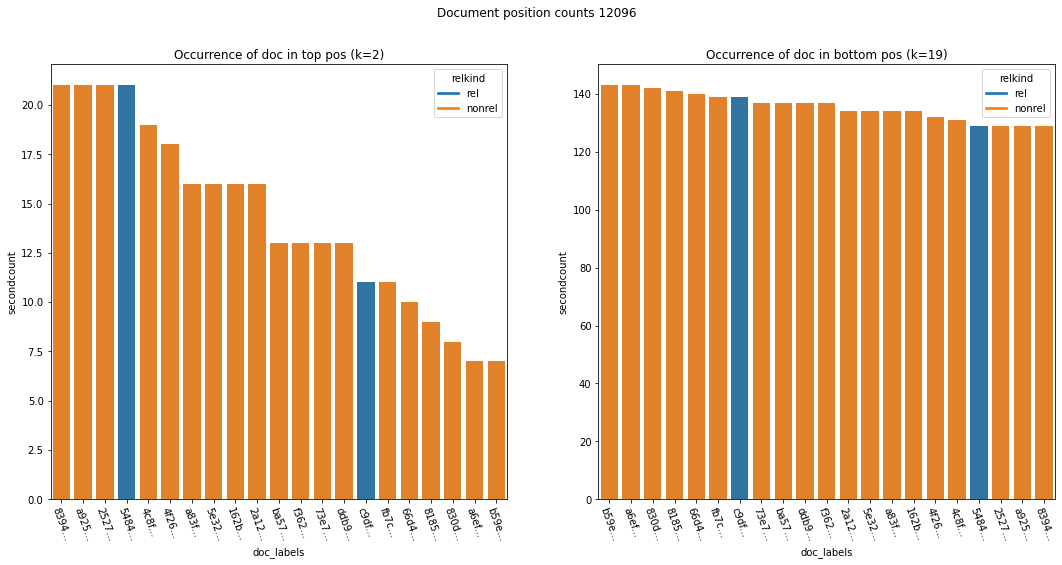

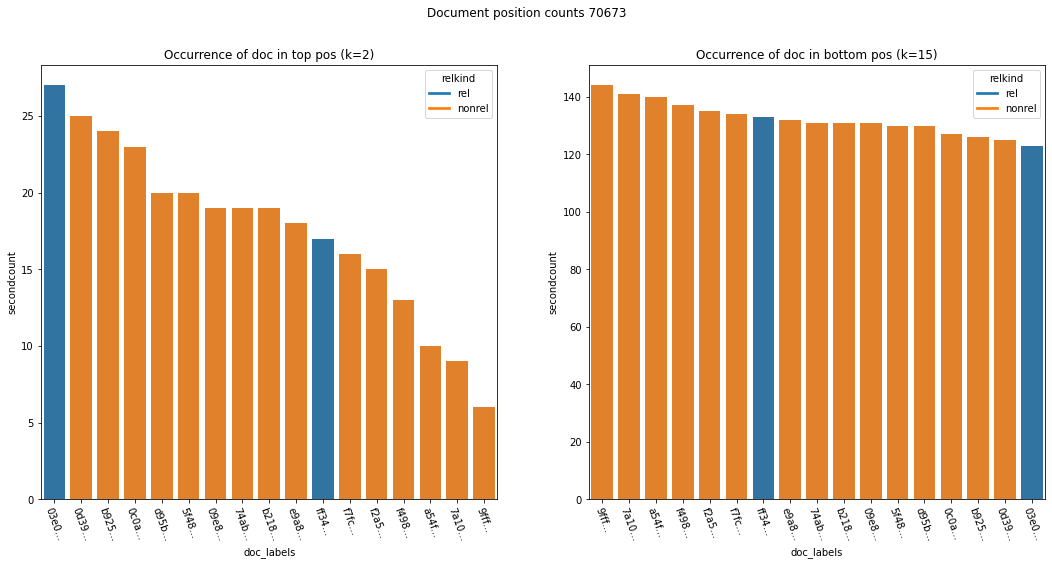

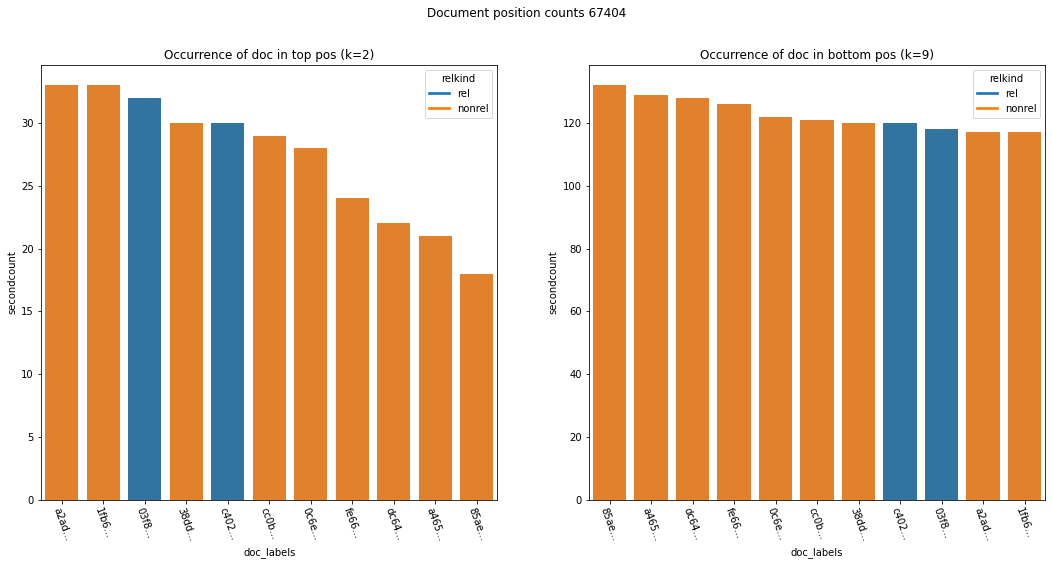

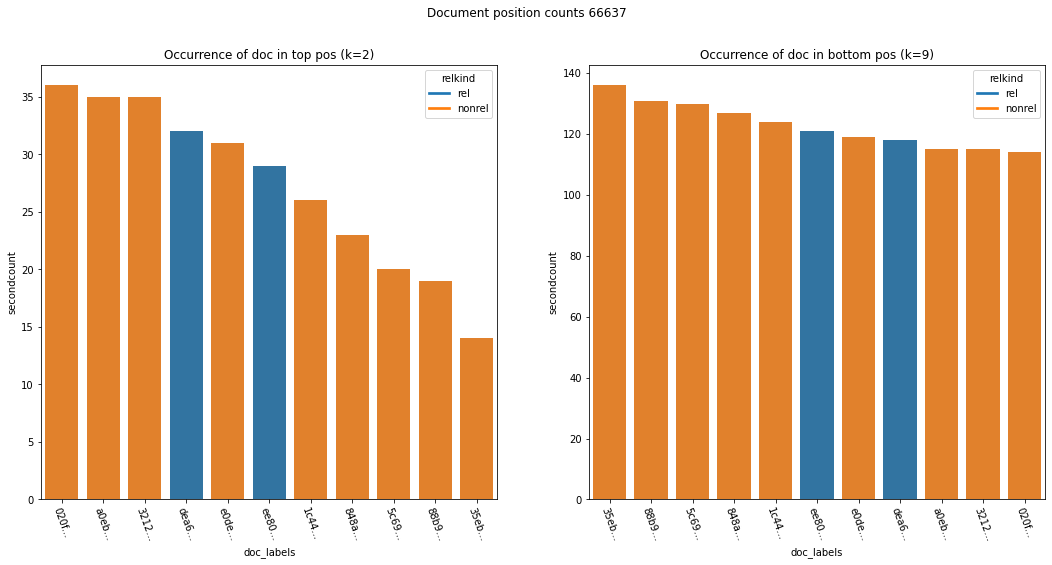

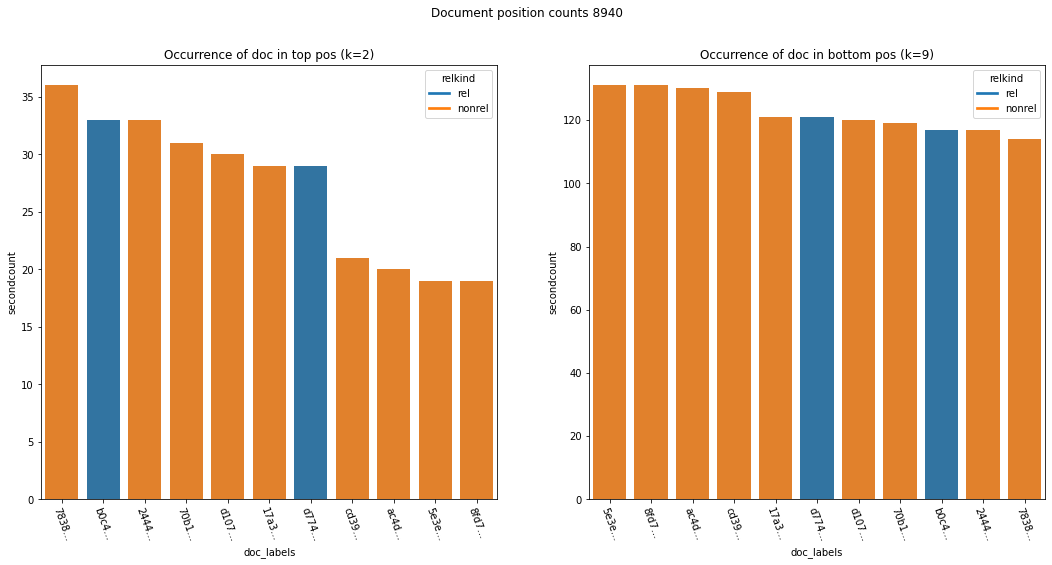

In [35]:
n = 10
for i, q in enumerate(edf_ac_A_9_err.qid.to_list()[:n]):
    plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids)
    
    

#### edf_ac_A_99

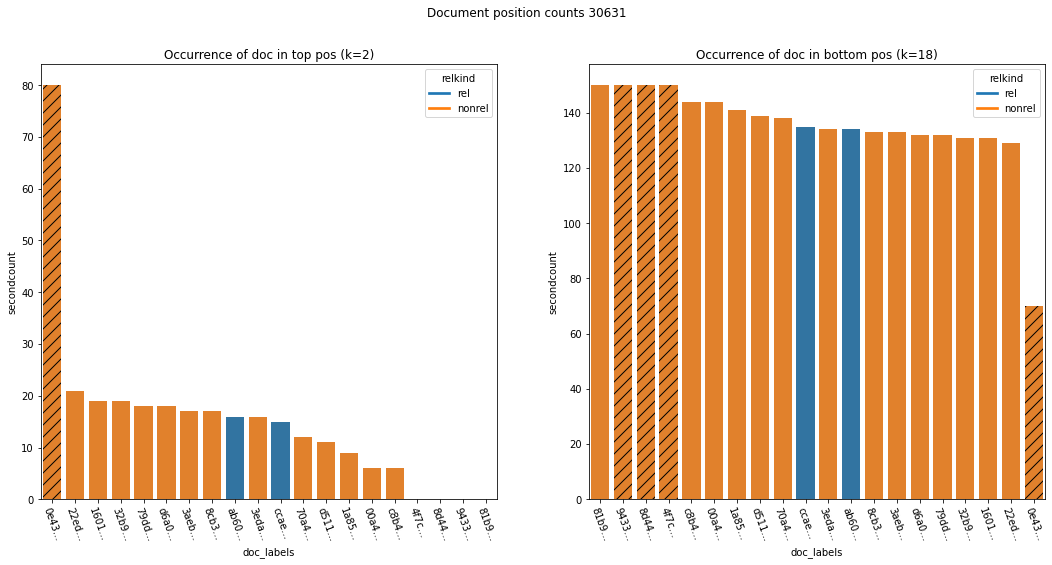

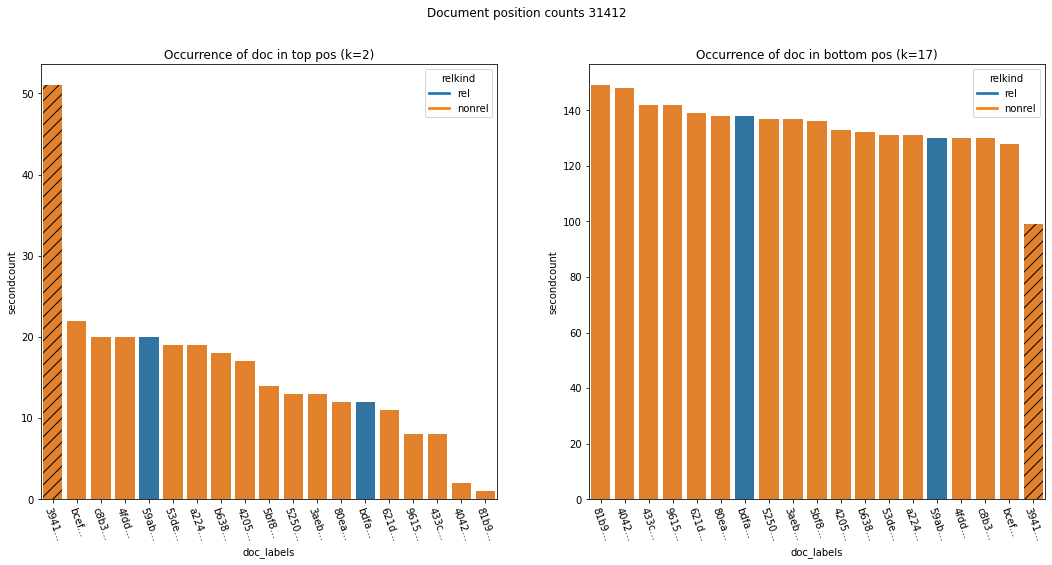

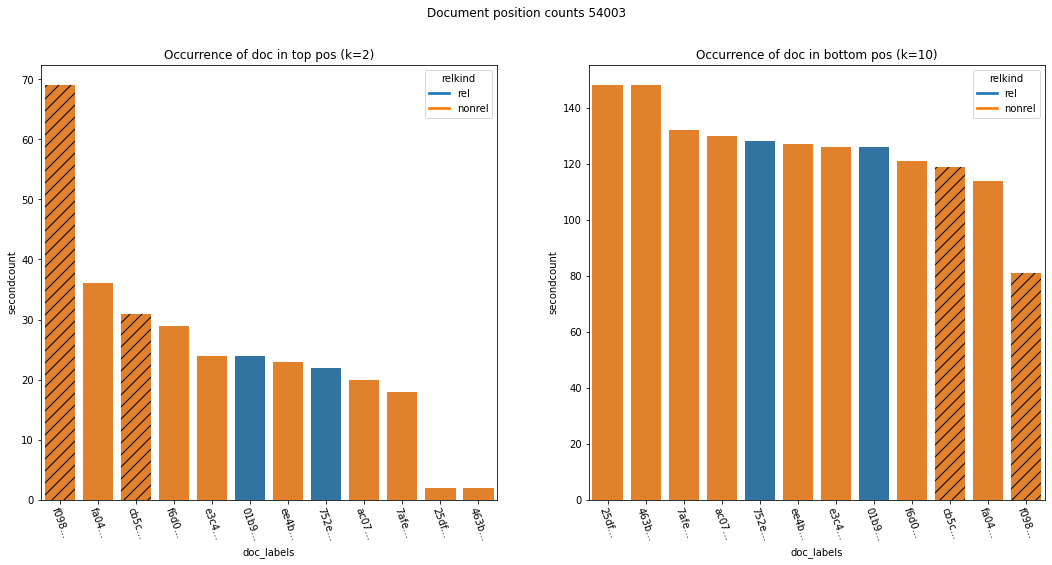

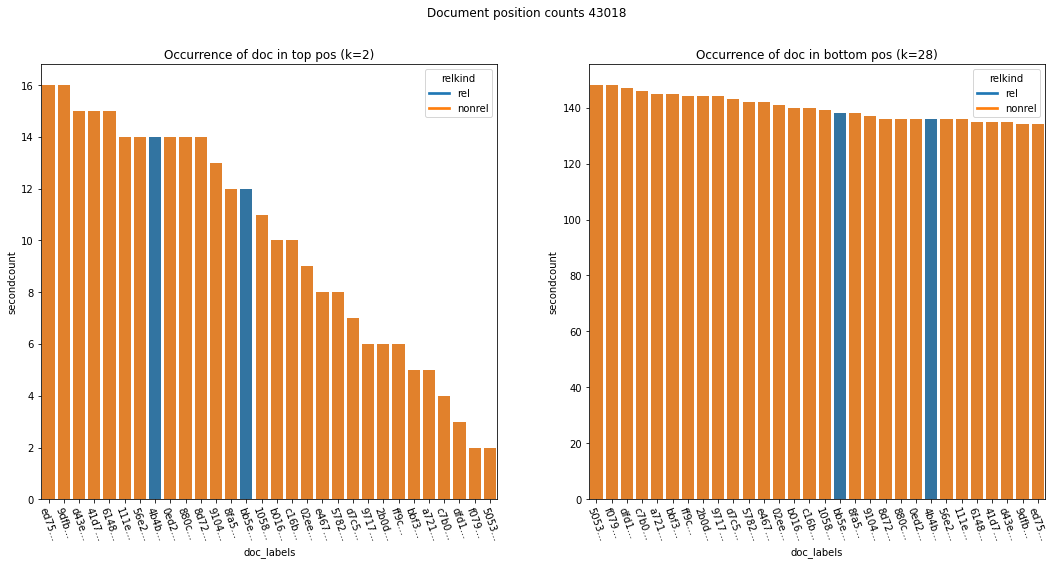

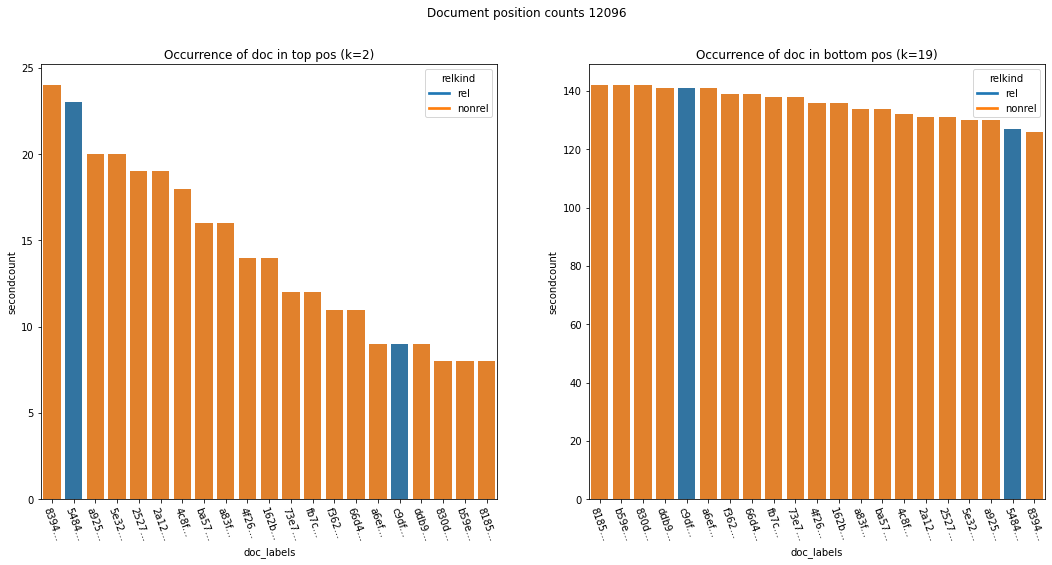

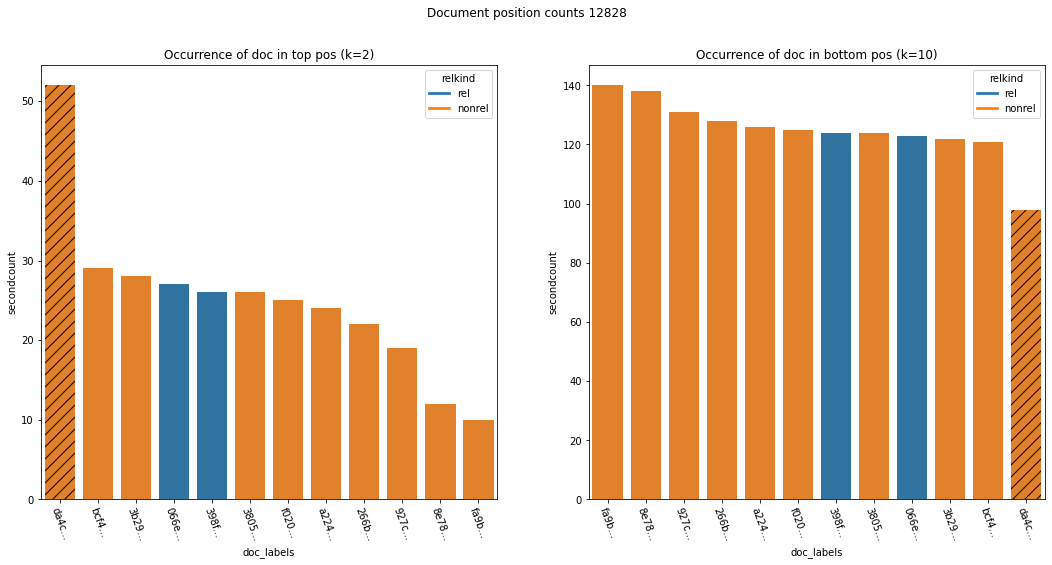

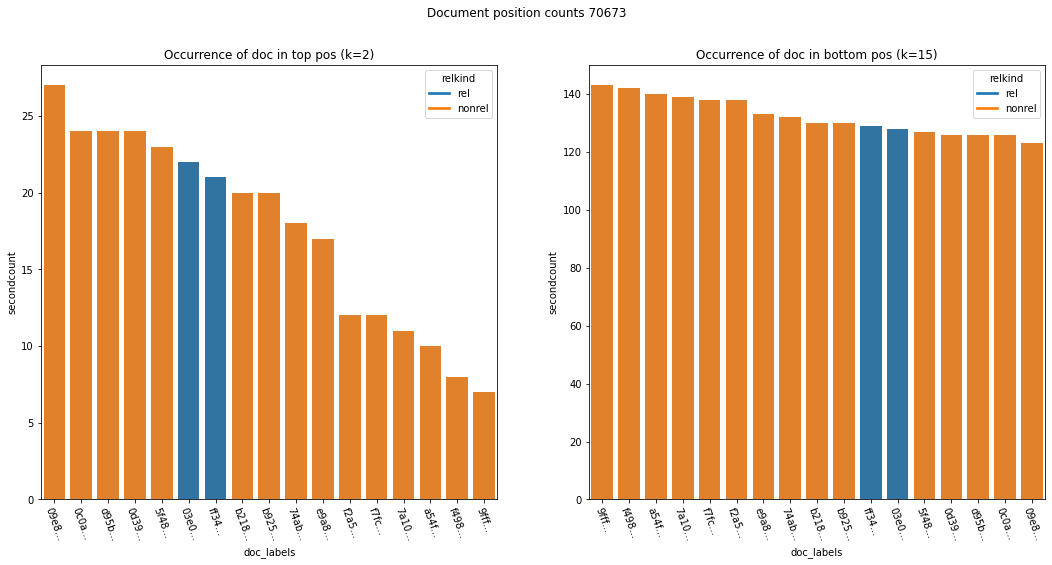

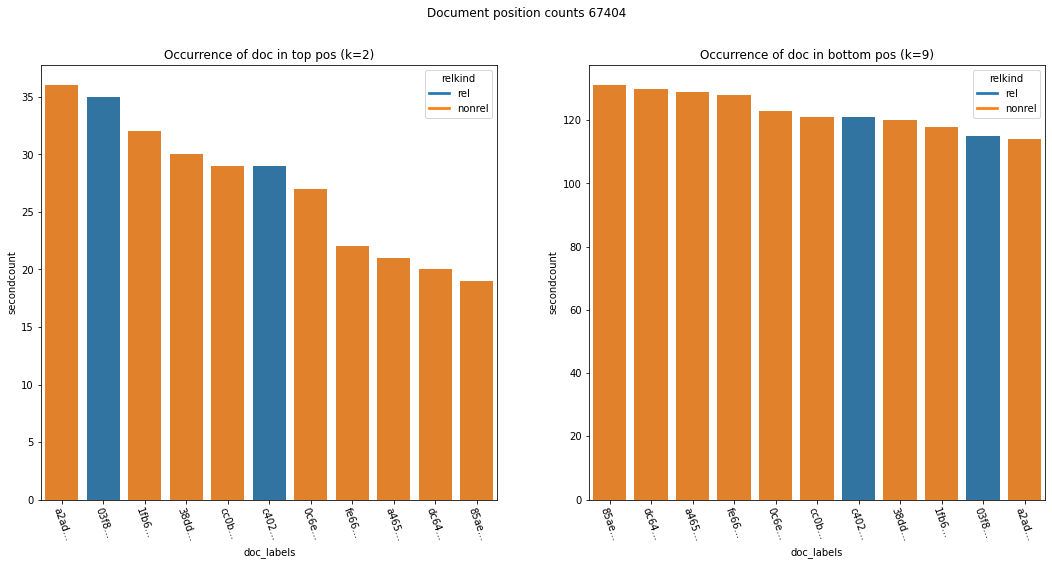

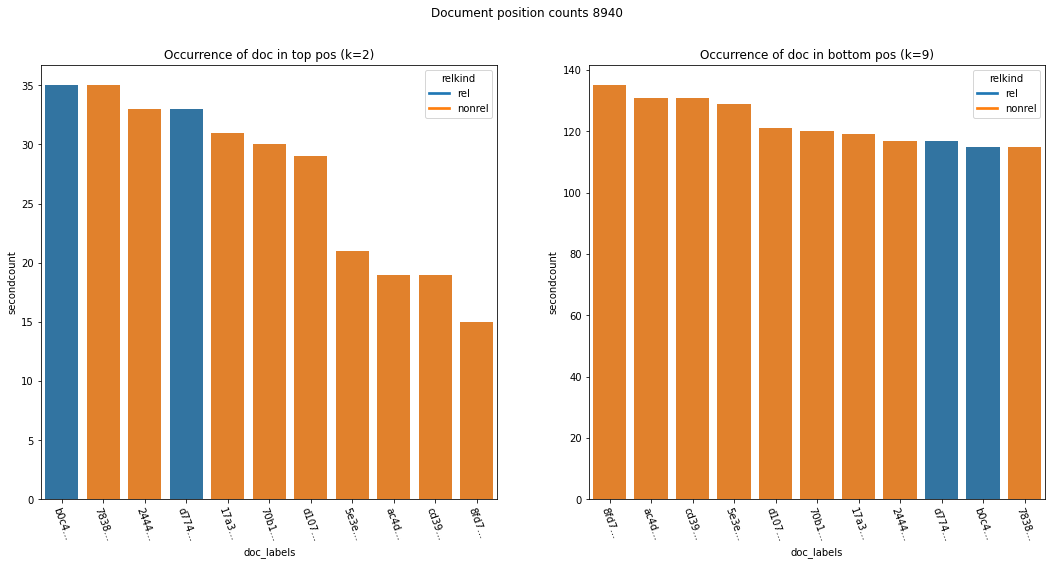

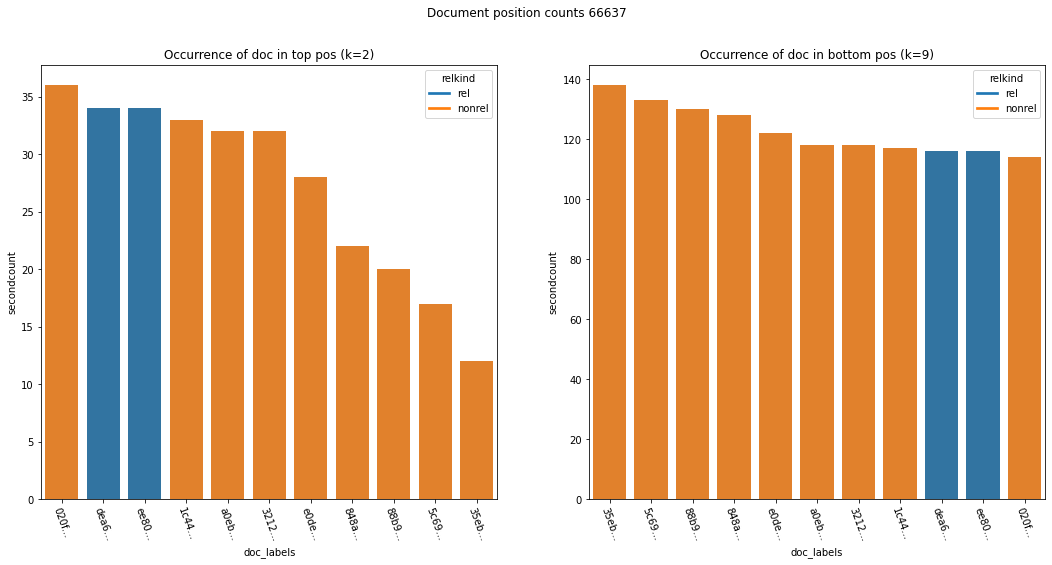

In [36]:
n = 10
for q in edf_ac_A_99_err.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_A_99,reldf,sortby=['count'], no_author_ids=noauth_docids)

#### edf_ac_B_9

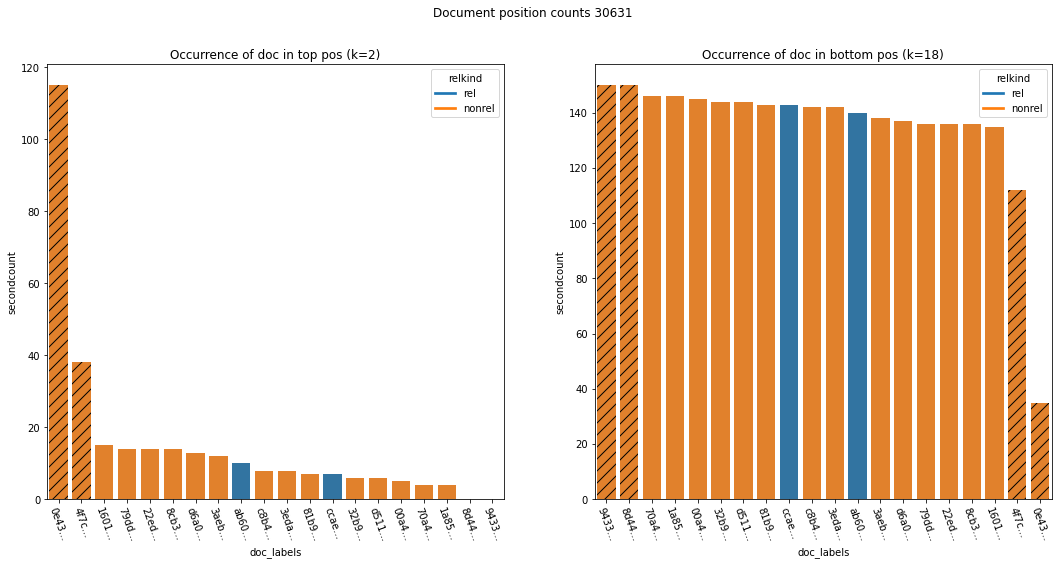

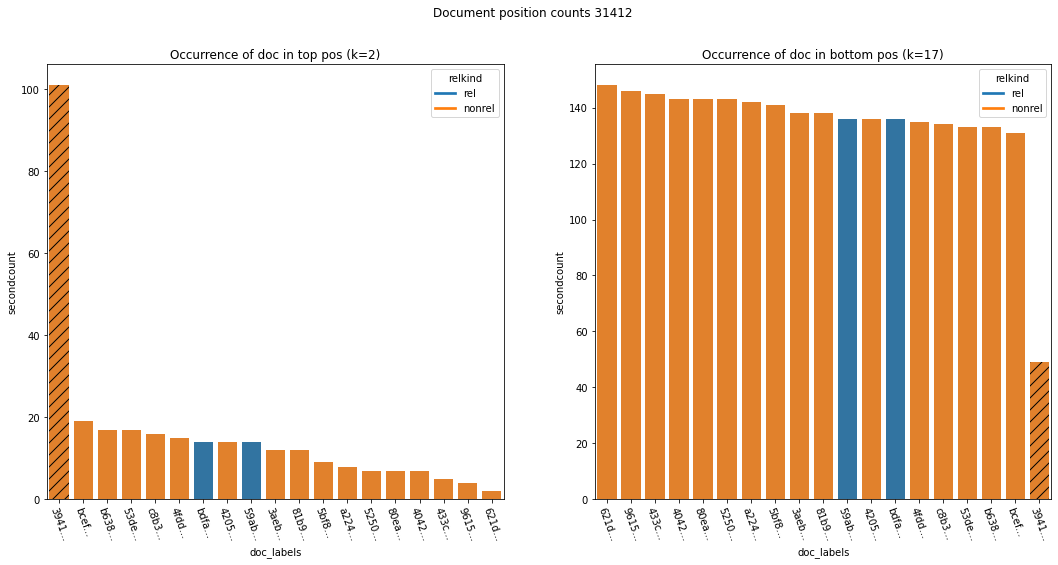

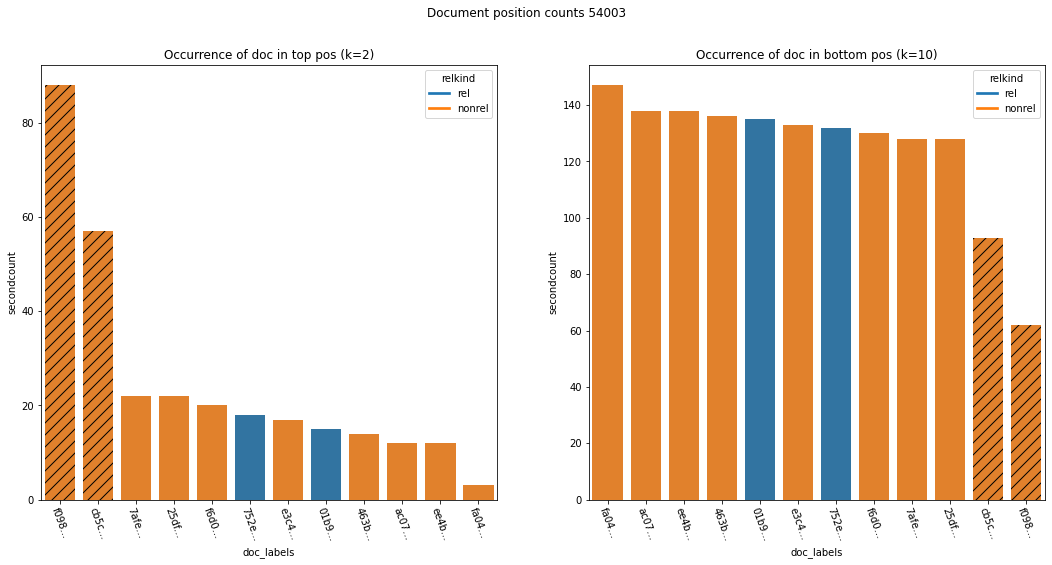

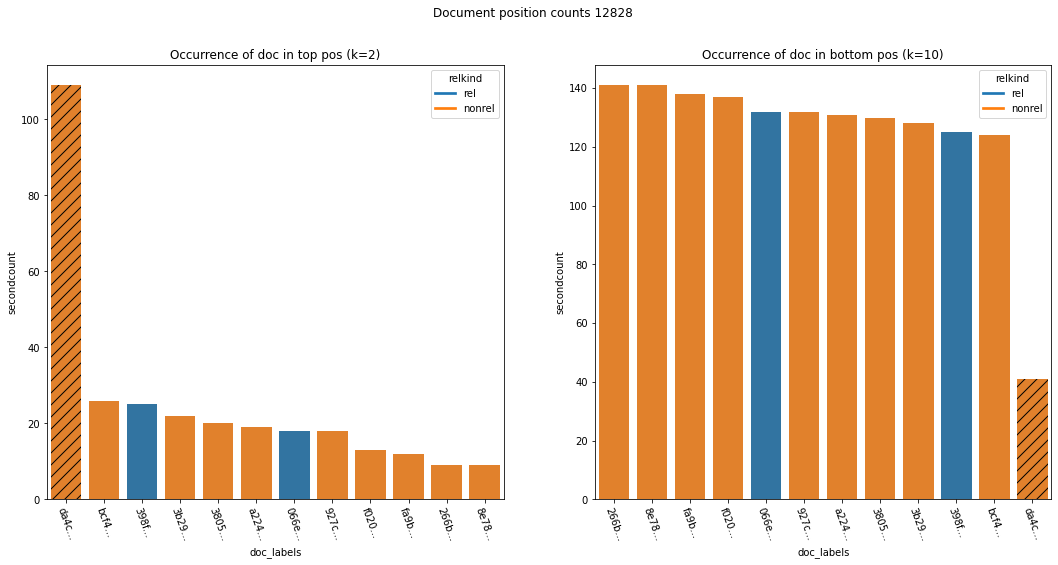

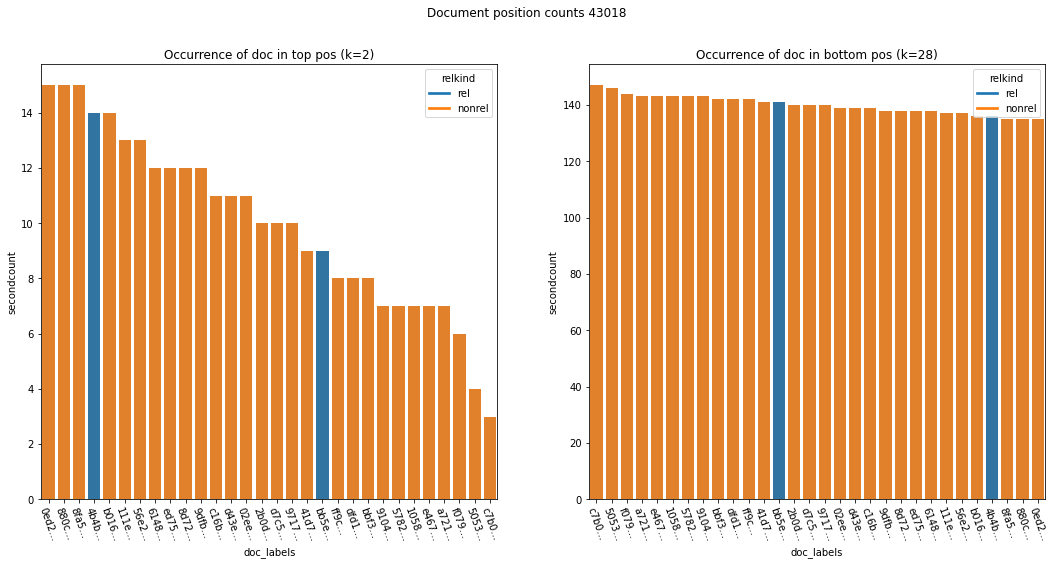

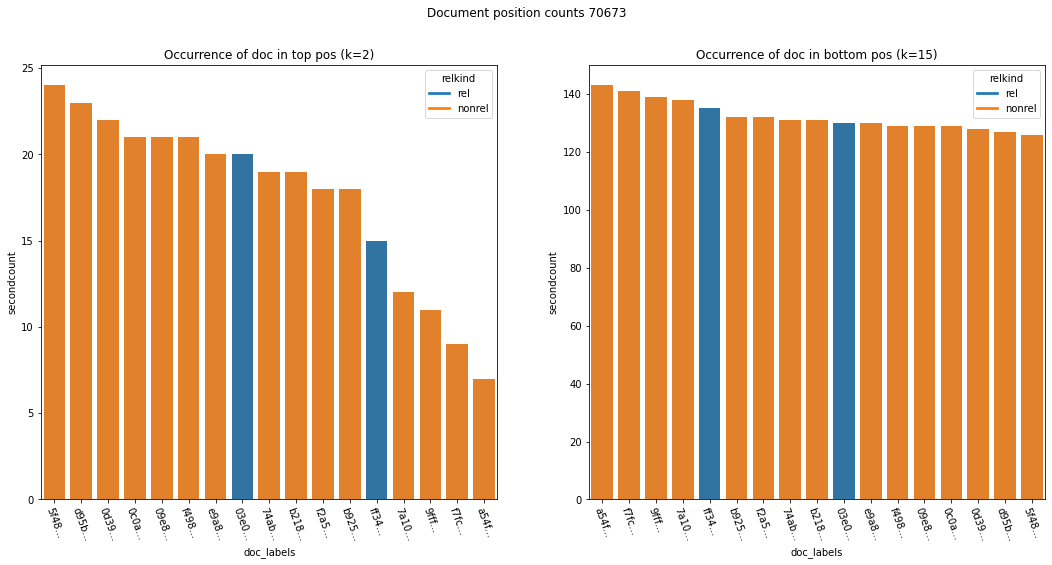

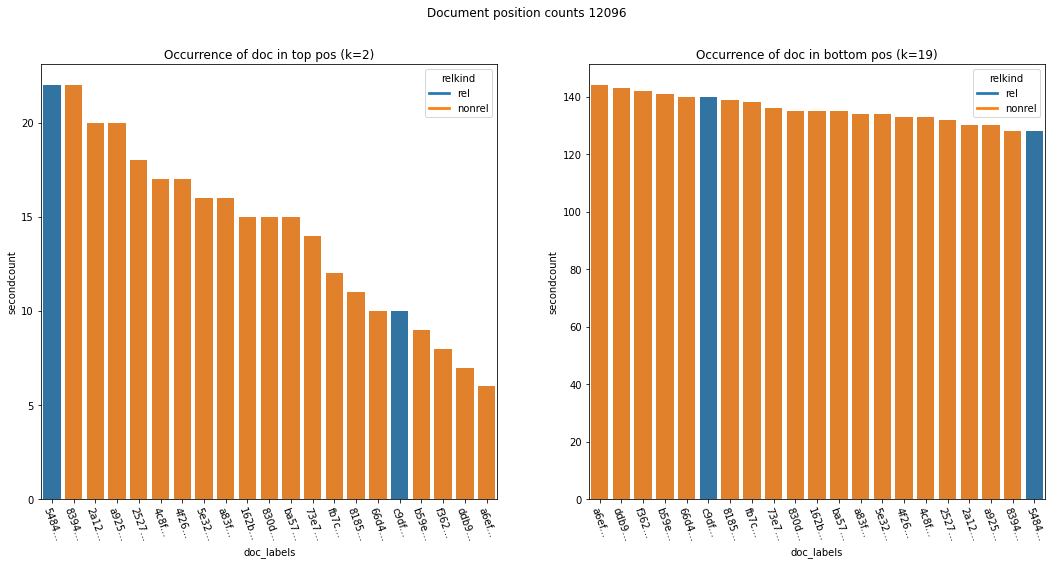

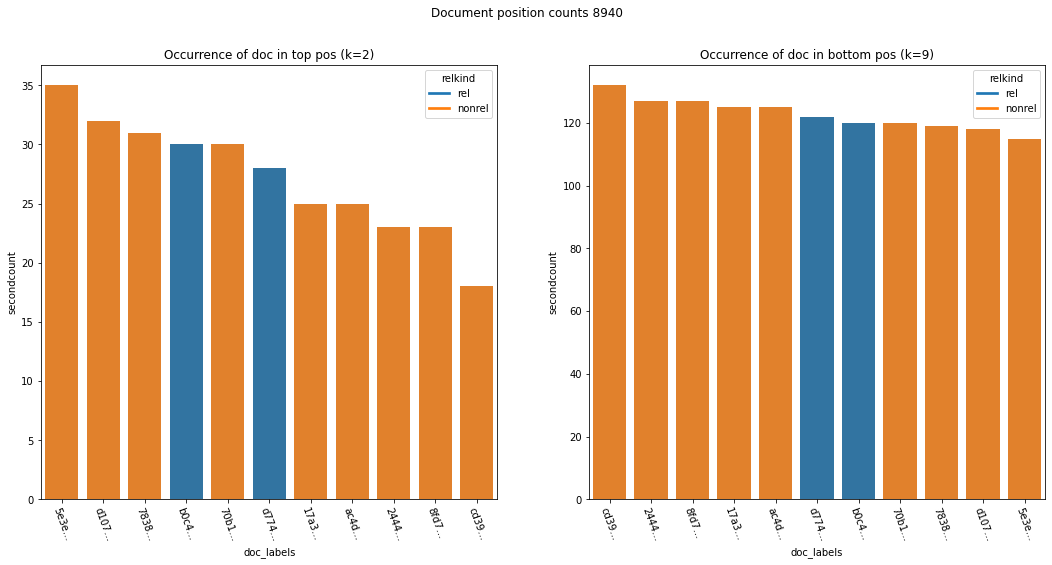

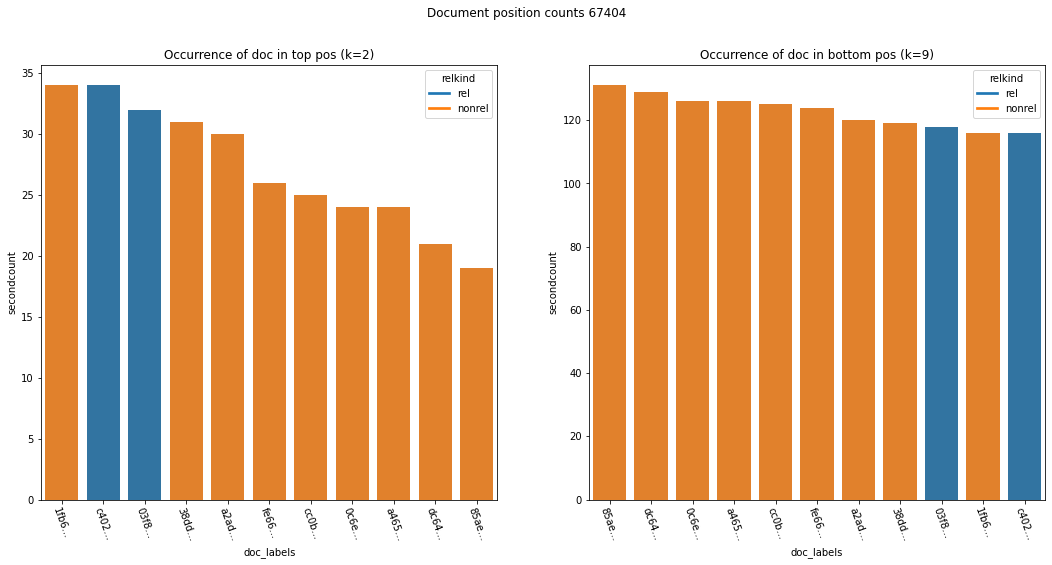

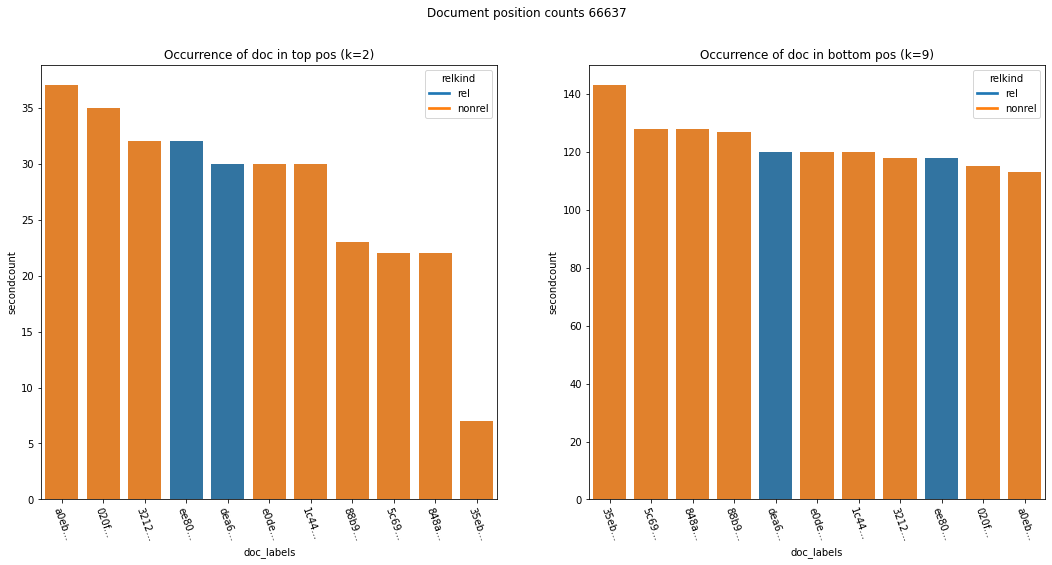

In [37]:
n = 10
for q in edf_ac_B_9_err.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_B_9,reldf,sortby=['count'], no_author_ids=noauth_docids)

#### edf_ac_B_99

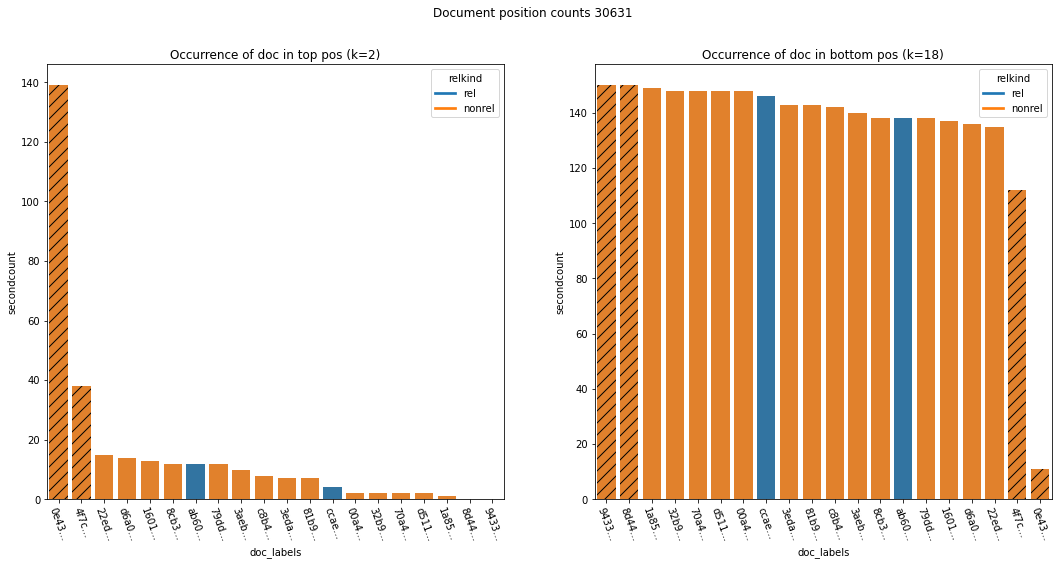

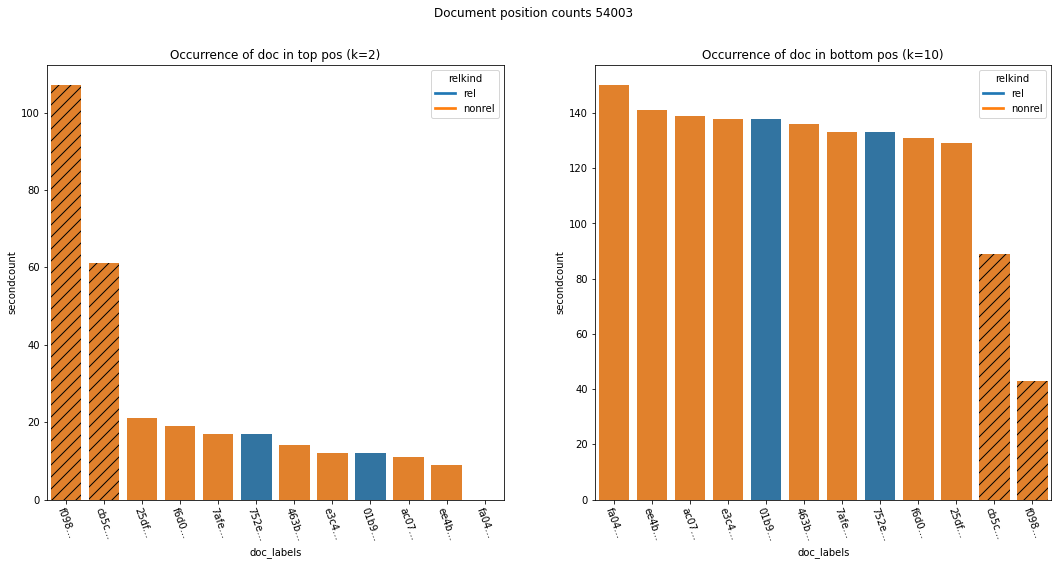

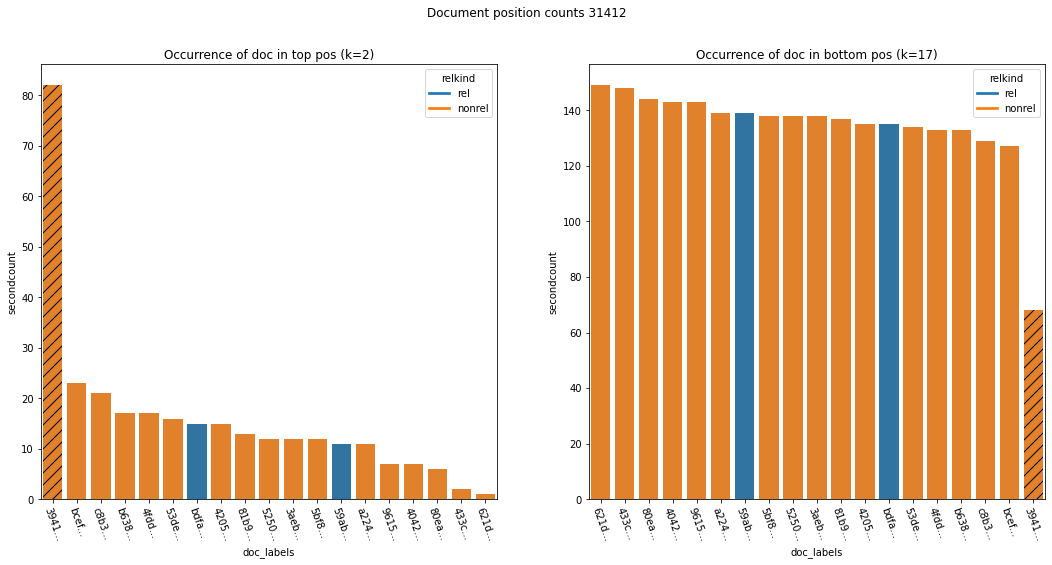

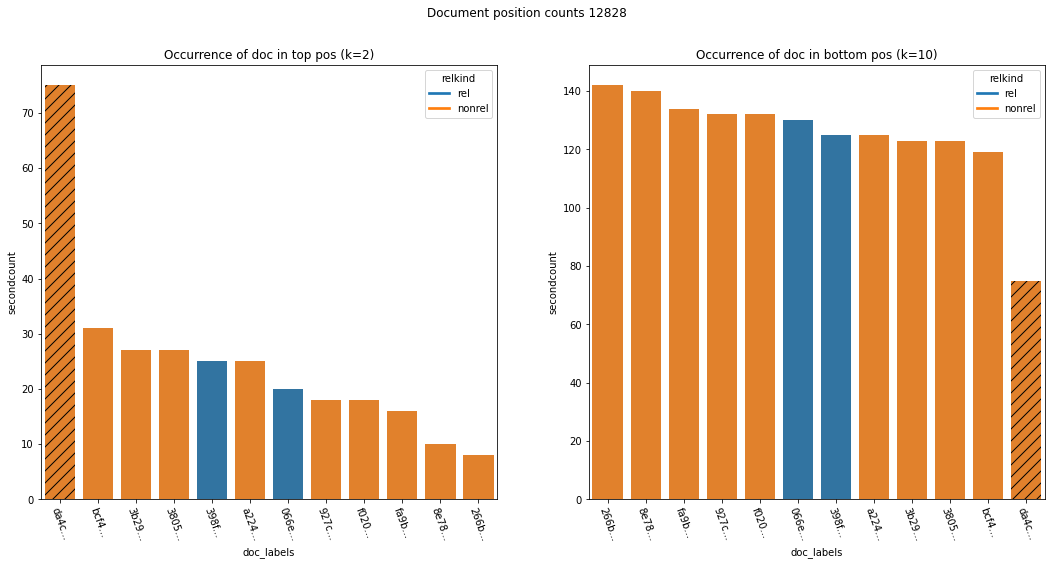

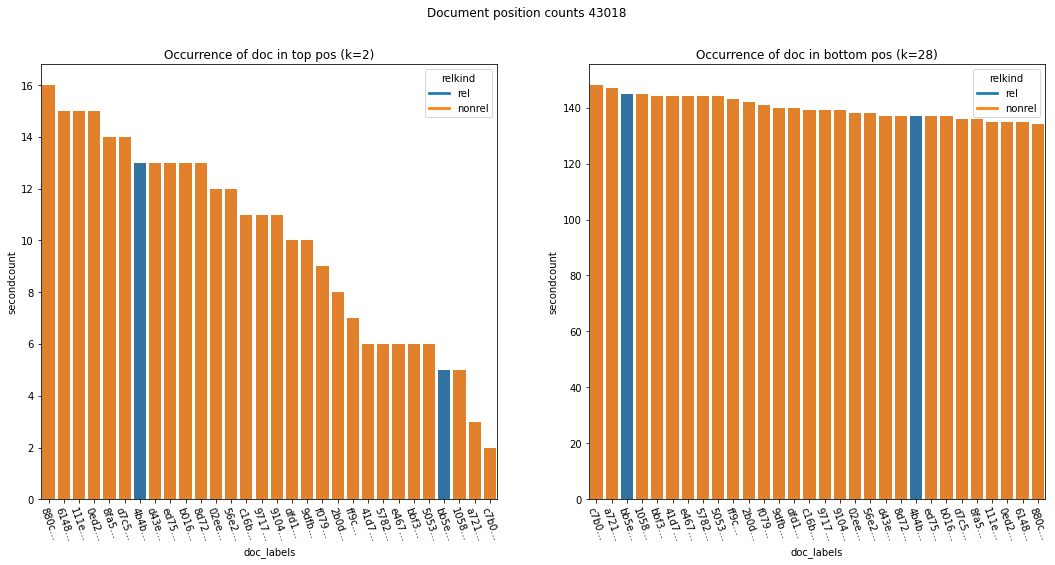

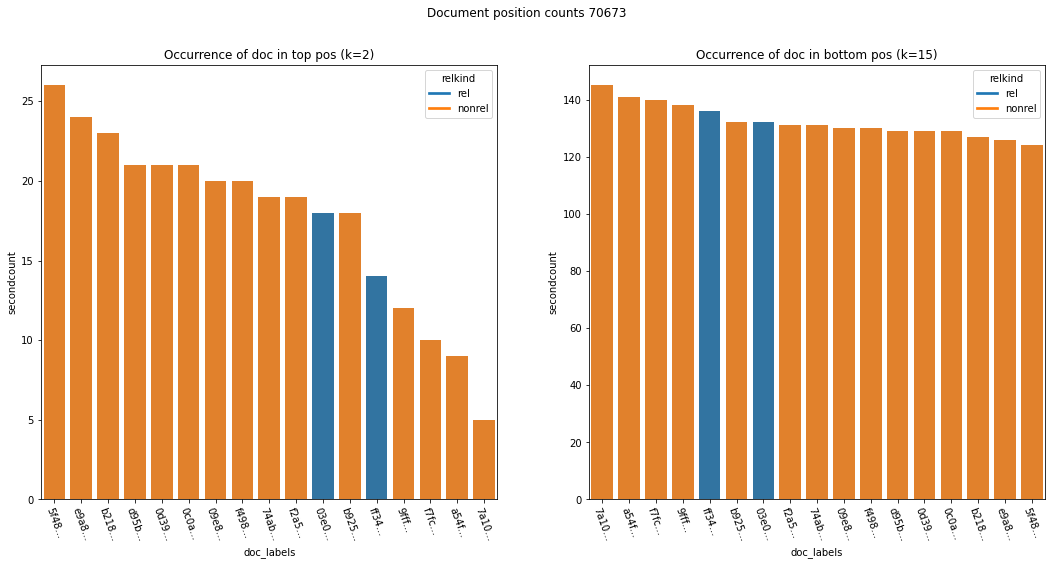

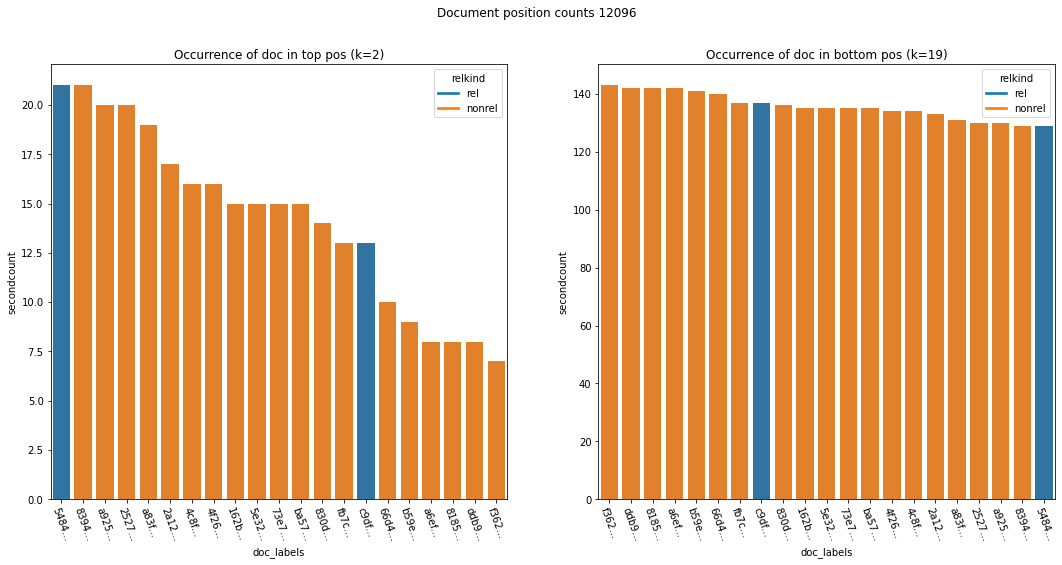

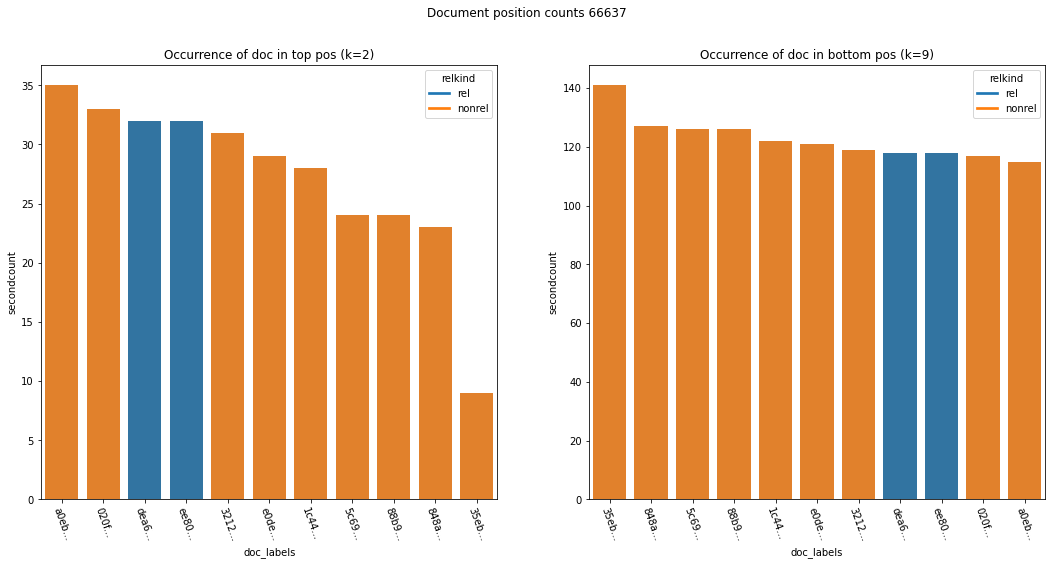

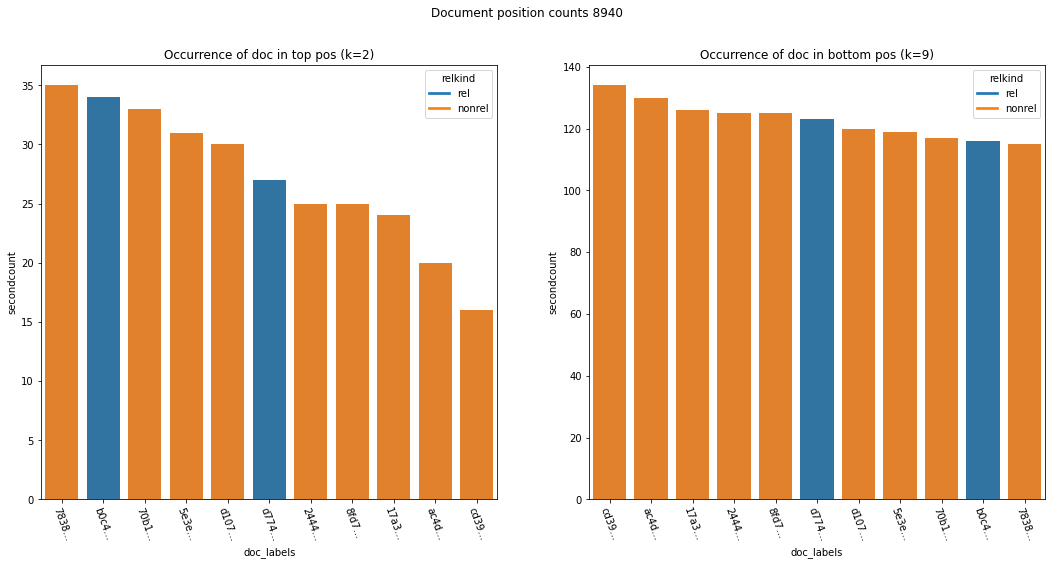

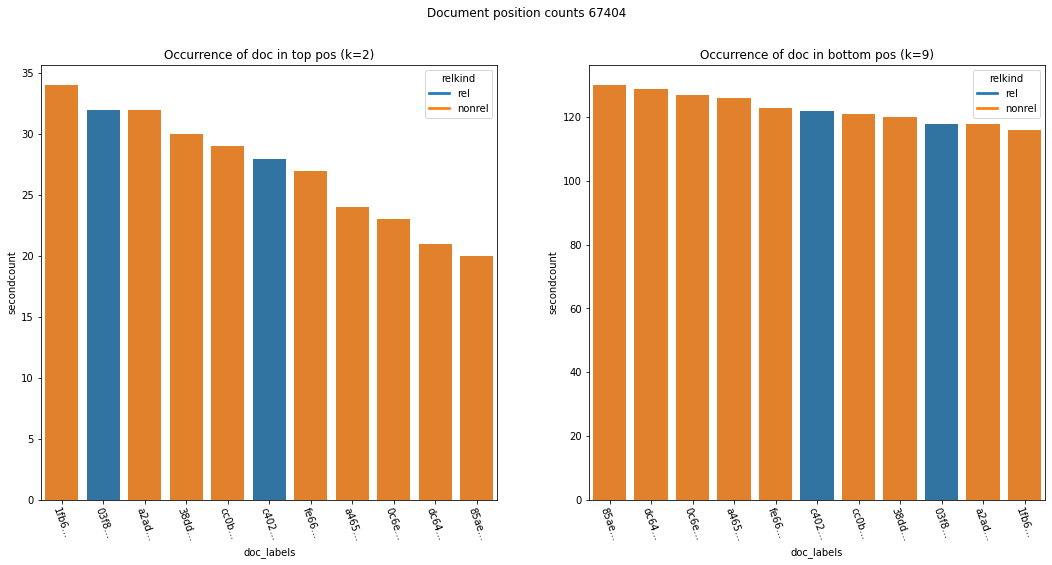

In [38]:
n = 10
for q in edf_ac_B_99_err.qid.to_list()[:n]:
    plot_doc_pos_count_for_qid(q,rdf_ac_B_99,reldf,sortby=['count'], no_author_ids=noauth_docids)

## 1. How often were top positions occupied by relevant documents? 2. How often were top positions occupied by non-relevant documents? Can these documents be categorized and distinguished from other documents? 3. Which relevant documents appear rarely or not at all in the top positions? Why did these documents not appear in the top positions more often?
Can these documents be categorized and distinguished from others? We want to find out which characteristics of a document help the ranker to place it in the correct location.

### edf_ac_A_9

#### EEL

In [39]:
n = 10
c = 0
p = 0 
e = edf_ac_A_9_eel
r = rdf_ac_A_9
for q in e.qid.to_list()[:n]:
    p += percentage_top_pos_occupied_by(q,r,reldf)
    c += count_top_pos_occupied_by(q,r,reldf)
print(round(p / n,2))
print(c / n)

16.56
87.6


##### Average number of authors

In [40]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, _,_ = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(tr)
    for d in tr:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

2.3076923076923075


In [41]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, tnr, br = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(tnr)
    for d in tnr:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

2.8181818181818183


In [42]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, tnr,br = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(br)
    for d in br:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

2.473684210526316


##### Average number of docs of those authors in the same ranking

In [43]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.1333333333333333


In [44]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    _,tr,_ = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.0120967741935485


In [45]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    _, _,tr = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.1702127659574468


##### Number of docs without an author (abs and avg)

In [46]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tr)
    
    for d in tr:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


0
0.0


In [47]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tnr)
    
    for d in tnr:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


4
0.045454545454545456


In [48]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(br)
    
    for d in br:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


0
0.0


##### Average difference with mean est rel

In [49]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.02429059215402255


In [50]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    _, tr,_ = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.007034343165818988


In [51]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    _,_,tr = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.02279598632721578


##### Average position due to est rel

In [52]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

8 / 20
5 / 30
2 / 18
8 / 18
50 / 51
37 / 51
7 / 51
4 / 17
1 / 11
7 / 11
1 / 11
7 / 11
8 / 11
10.21281822752411


In [53]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in tnr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

17 / 19
2 / 19
1 / 19
4 / 19
11 / 19
3 / 19
16 / 20
3 / 20
1 / 20
2 / 20
3 / 30
9 / 30
1 / 30
6 / 30
13 / 30
2 / 30
10 / 30
11 / 30
4 / 30
14 / 30
8 / 30
17 / 30
7 / 30
12 / 30
6 / 18
1 / 18
17 / 18
10 / 18
13 / 18
9 / 18
5 / 18
3 / 18
4 / 18
17 / 30
24 / 30
22 / 30
28 / 30
25 / 30
21 / 30
26 / 30
30 / 30
18 / 30
15 / 30
23 / 30
10 / 30
27 / 30
19 / 30
42 / 51
38 / 51
43 / 51
39 / 51
51 / 51
35 / 51
49 / 51
34 / 51
41 / 51
45 / 51
25 / 51
36 / 51
30 / 51
48 / 51
33 / 51
21 / 51
28 / 51
22 / 51
6 / 17
7 / 17
1 / 17
8 / 17
3 / 17
11 / 17
2 / 17
9 / 17
10 / 17
2 / 11
3 / 11
5 / 11
4 / 11
6 / 11
3 / 11
1 / 11
4 / 11
5 / 11
6 / 11
11 / 11
3 / 11
6 / 11
5 / 11
14.171638670692268


In [54]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in br:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

5 / 19
13 / 19
10 / 20
15 / 30
11 / 18
2 / 30
7 / 30
11 / 30
12 / 30
6 / 51
11 / 51
12 / 51
19 / 51
29 / 51
5 / 17
2 / 11
4 / 11
7 / 11
10 / 11
9.099893920465862


##### Average difference with true rel

In [55]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(tr)
    
    if len(tr) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tr}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.5007932408777326


In [56]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(tnr)
    
    if len(tnr) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tnr}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.019522523346590857


In [57]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(br)
    
    if len(br) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {br}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.3470756136919628


##### Average difference with mean est rel of documents that do not have an author versus documents that do

In [58]:
n = 10

noauthors = 0
docs = 0

diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tr)
    
    for d in tr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



0.0
0.02429059215402255


In [59]:
n = 10

noauthors = 0


diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    

    
    for d in tnr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



-0.06956342607490829
0.010681855986806002


In [60]:
n = 10

noauthors = 0


diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    

    
    for d in br:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



0.0
0.02279598632721578


##### Average positions of documents that do not have an author versus documents that do

In [61]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in tr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




0.0
10.21281822752411


In [62]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in tnr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




29.78546181630547
13.428123282805924


In [63]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in br:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




0.0
9.099893920465862


##### Average difference with true rel of documentst that do not have an author versus documents that do

In [64]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in tr:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tr}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.0
0.8198358210228164


In [65]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in tnr:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tnr}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.08802778460563584
0.16683060330294067


In [66]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in br:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {br}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.0
0.8197146698587044


#### ERR

In [67]:
n = 10
c = 0
p = 0 
e = edf_ac_A_9_err
r = rdf_ac_A_9
for q in e.qid.to_list()[:n]:
    p += percentage_top_pos_occupied_by(q,r,reldf)
    c += count_top_pos_occupied_by(q,r,reldf)
print(round(p / n,2))
print(c / n)

14.27
42.8


##### Average number of authors

In [68]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, _,_ = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(tr)
    for d in tr:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

1.9


In [69]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, tnr, br = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(tnr)
    for d in tnr:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

3.15


In [70]:
n = 10
nauthors = 0
numdocs = 0

for q in e.qid.to_list()[:n]:
    
    tr, tnr,br = questions1to3docs(q,ranking_to_df(r,reldf),reldf)
    numdocs += len(br)
    for d in br:
        nauthors += len(doc_to_author[d])
print(nauthors/numdocs)

4.9


##### Average number of docs of those authors in the same ranking

In [71]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.0


In [72]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    _,tr,_ = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.0952380952380953


In [73]:
n = 10

nauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    _, _,tr = questions1to3docs(q,thisranking,reldf)
    
    for d in tr:
        authors = doc_to_author[d]
        nauthors += len(authors)
        for a in authors:
            adocs = author_to_doc[a]
            for adoc in adocs:
                if adoc in thesedocs:
                    docs += 1
print(docs/nauthors)

1.0408163265306123


##### Number of docs without an author (abs and avg)

In [74]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tr)
    
    for d in tr:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


0
0.0


In [75]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tnr)
    
    for d in tnr:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


5
0.08333333333333333


In [76]:
n = 10

noauthors = 0
docs = 0
for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(br)
    
    for d in br:
        authors = doc_to_author[d]
        if len(authors) == 0:
            noauthors += 1
print(noauthors)
print(noauthors/docs)


0
0.0


##### Average difference with mean est rel

In [77]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.045851598094300026


In [78]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    _, tr,_ = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.03429088300583027


In [79]:
n = 10

nauthors = 0
docs = 0
diff = 0
for q in e.qid.to_list()[:n]:

    _,_,tr = questions1to3docs(q,thisranking,reldf)
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        diff += destrel - meanestrel
print(diff/docs)

0.014561263308581008


##### Average position due to est rel

In [80]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, _,_ = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in tr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

8 / 20
5 / 30
2 / 21
4 / 17
1 / 11
7 / 11
4 / 11
6 / 11
1 / 11
7 / 11
3.5735230455818687


In [81]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in tnr:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

16 / 20
3 / 20
1 / 20
2 / 20
17 / 19
2 / 19
1 / 19
4 / 19
11 / 19
3 / 19
12 / 12
10 / 12
10 / 12
5 / 12
3 / 30
9 / 30
1 / 30
6 / 30
13 / 30
2 / 30
10 / 30
11 / 30
4 / 30
14 / 30
8 / 30
17 / 30
7 / 30
12 / 30
4 / 21
1 / 21
3 / 21
9 / 21
11 / 21
10 / 21
5 / 21
6 / 21
8 / 21
6 / 17
7 / 17
1 / 17
8 / 17
3 / 17
11 / 17
2 / 17
9 / 17
10 / 17
3 / 11
1 / 11
4 / 11
5 / 11
6 / 11
1 / 11
3 / 11
2 / 11
5 / 11
2 / 11
3 / 11
5 / 11
4 / 11
6 / 11
5.359108332328138


In [82]:
n = 10

nauthors = 0
docs = 0
diff = 0
posfrac = 0
for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    # print(meanestrel)
    for d in br:
        docs += 1
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]
        
        print(erels.index(destrel) + 1,'/',len(erels))
        posfrac += erels.index(destrel) + 1/len(erels)
print(posfrac/docs)

10 / 20
5 / 19
13 / 19
3 / 12
6 / 12
3 / 12
6 / 12
15 / 30
17 / 21
5 / 17
7.362837240159221


##### Average difference with true rel

In [83]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(tr)
    
    if len(tr) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tr}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.5567231276235816


In [84]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(tnr)
    
    if len(tnr) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tnr}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.029386160229712684


In [85]:
n = 10

nauthors = 0
docs = 0
mean_ereldiff = 0

for q in e.qid.to_list()[:n]:

    tr, tnr, br = questions1to3docs(q,thisranking,reldf)
    docs += len(br)
    
    if len(br) > 0:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {br}')
    
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)
        mean_ereldiff += diff['diff'].mean()
    else:
        continue

print(mean_ereldiff/docs)   


0.581562498038885


##### Average difference with mean est rel of documents that do not have an author versus documents that do

In [86]:
n = 10

noauthors = 0
docs = 0

diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    
    docs += len(tr)
    
    for d in tr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



0.0
0.045851598094300026


In [87]:
n = 10

noauthors = 0


diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    

    
    for d in tnr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



-0.061438881137585
0.04299358883704983


In [88]:
n = 10

noauthors = 0


diffhasauthor = []
diffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)
    

    
    for d in br:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            diffhasnoauthor.append(destrel - meanestrel)
        else:
            diffhasauthor.append(destrel - meanestrel)
print(sum(diffhasnoauthor)/max(len(diffhasnoauthor),1))
print(sum(diffhasauthor)/max(len(diffhasauthor),1))



0.0
0.014561263308581008


##### Average positions of documents that do not have an author versus documents that do

In [89]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in tr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




0.0
3.5735230455818687


In [90]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in tnr:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




12.070526315789476
4.748979424740752


In [91]:
n = 10

noauthors = 0
docs = 0

posfrachasauthor = []
posfrachasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)

    
    for d in br:
        authors = doc_to_author[d]
        destrel = ereldf_A.query(f'qid == {q} and doc_id == "{d}"').est_relevance.iloc[0]

        if len(authors) == 0:
            posfrachasnoauthor.append(erels.index(destrel) + 1/len(erels))
        else:
            posfrachasauthor.append(erels.index(destrel) + 1/len(erels))
print(sum(posfrachasnoauthor)/max(len(posfrachasnoauthor),1))
print(sum(posfrachasauthor)/max(len(posfrachasauthor),1))




0.0
7.362837240159221


##### Average difference with true rel of documentst that do not have an author versus documents that do

In [92]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in tr:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tr}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.0
0.7991193555079654


In [93]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in tnr:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {tnr}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.09838986464462687
0.19870261859569763


In [94]:
n = 10

noauthors = 0
docs = 0

truereldiffhasauthor = []
truereldiffhasnoauthor = []

for q in e.qid.to_list()[:n]:
    thisranking = ranking_to_df(r,reldf)
    thesedocs = thisranking.query(f'qid == {q}').doc_id.drop_duplicates().to_list()
    meanestrel = ereldf_A.query(f'qid == {q}').est_relevance.mean()
    erels = ereldf_A.query(f'qid == {q}').sort_values(by='est_relevance',ascending=False).est_relevance.to_list()
    
    
    tr,tnr,br = questions1to3docs(q,thisranking,reldf)


    
    for d in br:
        diff = ereldf_A.query(f'qid == {q} and doc_id in {br}')
        diff['diff'] = diff.apply(lambda row: abs(row.relevance - row.est_relevance),axis=1)

        authors = doc_to_author[d]
        
        if len(authors) == 0:
            truereldiffhasnoauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])
        else:
            truereldiffhasauthor.append(diff.query(f'doc_id == "{d}"').iloc[0]['diff'])


  
  

print(sum(truereldiffhasnoauthor)/max(len(truereldiffhasnoauthor),1))
print(sum(truereldiffhasauthor)/max(len(truereldiffhasauthor),1))



0.0
0.8271039970561205


#### inspecting top relevant documents

In [95]:
e = edf_ac_A_9_eel
r = rdf_ac_A_9
n=10
for q in e.qid.to_list()[:n]:
    print(q)
    questions1to3(q,ranking_to_df(r,reldf),reldf,'toprels')
    print()

31412
toprels


30631
toprels
ab609df01b35223d4c1ec4d6fe84cfe349ad608b


43018
toprels
4b4b63405efd22a96cc45b22c08124d62a475d6f


20363
toprels
00b213795dd4c926f3a4b4a2979a845f0ca6b7f5
a1efc262f96d83b91986cfef14f34b7488230f67


25869
toprels


51432
toprels
527f5f6a533fe9b126d650c000aa328bcf1471e1
a3124650908b88c9b2e03b0add30464ef77c11ce
d1fadcb994e67399b10d9721c2cb86fae8a0f15f


70673
toprels
03e053a5236f33f2999dbee6dee0a7c06844580d


8940
toprels
b0c4f3d96ad476d1e4f377074cd5414973d3cd92
d774b8b767eb53873e0dd0ea4bfaa7744fabcb31


67404
toprels
03f8ca128fa4e9a4f5b9f2f211c0fc9f2793fb3c
c402314407034f3670ce1db0a41d07cee0349a1e


49766
toprels
66d2acae2985f4aa01c8625d615482cb618e9dd9




##### 30631

In [96]:
q = 30631

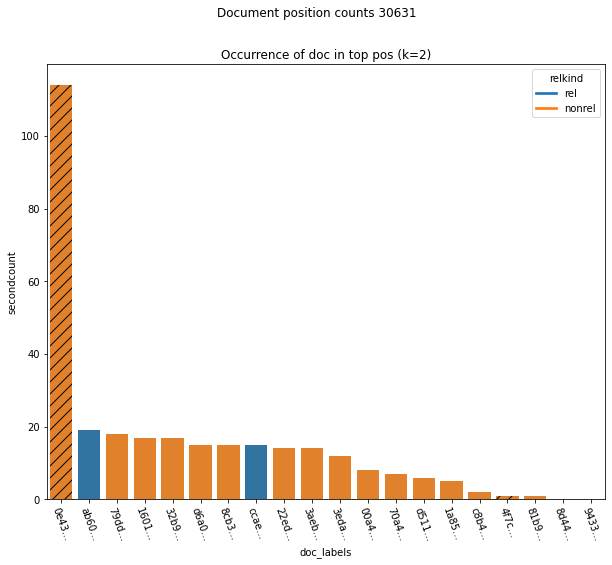

In [97]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [98]:
reldf.query('qid == 30631')[['query']].drop_duplicates()

,query
186,covid-19 testing


In [99]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['ab609df01b35223d4c1ec4d6fe84cfe349ad608b']}}})
res

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'ab609df01b35223d4c1ec4d6fe84cfe349ad608b',
    '_score': 1.0,
    '_source': {'title': 'Covid-19 Tweeting in English: Gender Differences',
     'paperAbstract': 'At the start of 2020, COVID-19 became the most urgent threat to global public health. Uniquely in recent times, governments have imposed partly voluntary, partly compulsory restrictions on the population to slow the spread of the virus. In this context, public attitudes and behaviors are vitally important for reducing the death rate. Analyzing tweets about the disease may therefore give insights into public reactions that may help guide public information campaigns. This article analyses 3,038,026 English tweets about COVID-19 from March 10 to 23, 2020. It focuses on one re

In [100]:
ereldf_A.query(f"qid == {q} and doc_id == 'ab609df01b35223d4c1ec4d6fe84cfe349ad608b'")

,qid,doc_id,relevance,est_relevance
4468,30631,ab609df01b35223d4c1ec4d6fe84cfe349ad608b,1,0.191062


In [101]:
author_to_doc['1701298']

['ab609df01b35223d4c1ec4d6fe84cfe349ad608b']

In [102]:
author_to_doc['1579939186']

['ab609df01b35223d4c1ec4d6fe84cfe349ad608b']

In [103]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4474,30631,81b95e0483d32945aad0c09849f1a9b2022d59c4,0,0.065416
4481,30631,943320b3c05a7aeace900e28d0c6d434804363b4,0,0.069432
4467,30631,8d442ea1c14504e6e5676d82e78e1330c354731f,0,0.104101
4480,30631,4f7cebcc071e129d41df4766d1aed1c55e236311,0,0.111590
4472,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced,0,0.124778
4466,30631,c8b45c6052cbc388de67682ac02a185fc62ba815,0,0.127159
4479,30631,00a407540a8bdd6d7425bd8a561eb21d69682511,0,0.134421
4465,30631,d511f3a98d460f7967dd490e34d664caac1529d1,0,0.137287
4476,30631,1a854bfceb615249fd9c75f3f4491b0554e59c16,0,0.138070
4464,30631,70a462ada6a79125940a46d48e430fa938054819,0,0.148966


In [104]:
0.231227/0.191062

1.2102197192534359

In [105]:
0.191062/0.065416

2.9207227589580533

###### Remarks
- 2 authors, have only written this document
- high-ish relevance, position 8/20
- 1.2 times smaller than highest, +- 3 times higher than lowest

##### 43018
toprels
4b4b63405efd22a96cc45b22c08124d62a475d6f

In [106]:
q = 43018

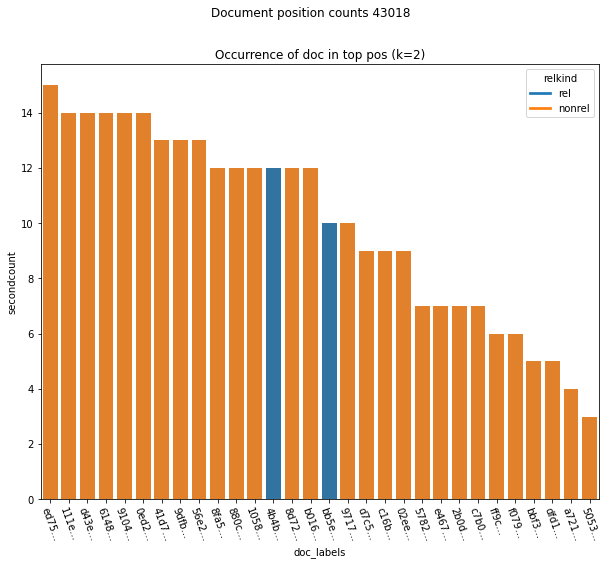

In [107]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [108]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
181,data security medicine


In [109]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['4b4b63405efd22a96cc45b22c08124d62a475d6f']}}})
res

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4b4b63405efd22a96cc45b22c08124d62a475d6f',
    '_score': 1.0,
    '_source': {'title': 'Big healthcare data: preserving security and privacy',
     'paperAbstract': 'Big data has fundamentally changed the way organizations manage, analyze and leverage data in any industry. One of the most promising fields where big data can be applied to make a change is healthcare. Big healthcare data has considerable potential to improve patient outcomes, predict outbreaks of epidemics, gain valuable insights, avoid preventable diseases, reduce the cost of healthcare delivery and improve the quality of life in general. However, deciding on the allowable uses of data while preserving security and patient’s right to privacy is a difficult task. Big 

In [110]:
ereldf_A.query(f"qid == {q} and doc_id == '4b4b63405efd22a96cc45b22c08124d62a475d6f'")

,qid,doc_id,relevance,est_relevance
4383,43018,4b4b63405efd22a96cc45b22c08124d62a475d6f,1,0.220997


In [111]:
author_to_doc['9414241']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [112]:
author_to_doc['1935321']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [113]:
author_to_doc['10441982']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [114]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4374,43018,5053e086955182440b2c3e6bd21a29240b1565ed,0,0.071833
4382,43018,f07914ea6330add99631216026e41e1f8e8de09b,0,0.072056
4372,43018,c7b08740b69b2973f1f73c6f9793f2cee727ff9e,0,0.073956
4386,43018,dfd1ffe1fe37c62e6738fef70447be98778ceab6,0,0.075850
4380,43018,a7216fb6bf0188bcd2ed6f040c9bf1e2226bb744,0,0.080997
4360,43018,bbf3a66ac70269921064cfef39ef258bf8b05f31,0,0.092612
4364,43018,ff9cc7d8f7a4e516d4e9cebdde5f94fadeafc242,0,0.095501
4385,43018,2b0dcadf2a119c84f3f2cc543d6bbaea18d85d6e,0,0.104635
4379,43018,971766088dfaf63fb55e6f0190b14f28f2c98ad0,0,0.105701
4368,43018,d7c5389e10debb6d7af6dc7ca8bf7f2c17a8f7dc,0,0.113038


In [115]:
0.234634/0.220997

1.061706720000724

In [116]:
0.220997/0.071833

3.07653863823034

###### Remarks
- 3 authors, have only written this document
- high-ish relevance, position 5/many
- 1.06 times smaller than highest, +- 3 times higher than lowest

##### 20363
toprels
00b213795dd4c926f3a4b4a2979a845f0ca6b7f5
a1efc262f96d83b91986cfef14f34b7488230f67

In [117]:
q = 20363

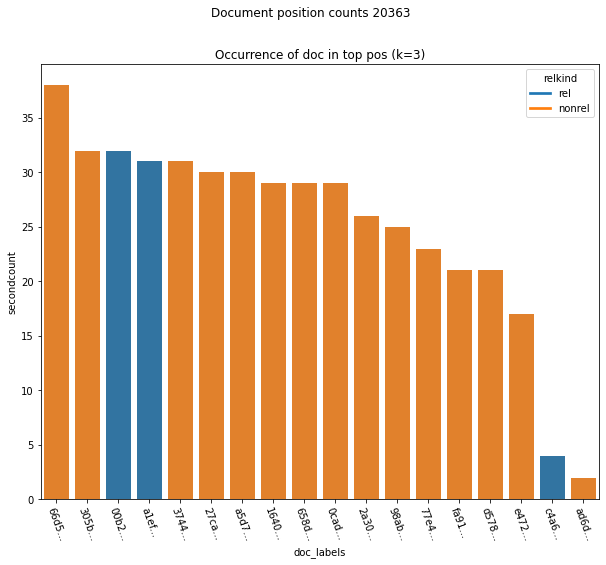

In [118]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [119]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
199,uncanny valley


In [120]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['00b213795dd4c926f3a4b4a2979a845f0ca6b7f5','a1efc262f96d83b91986cfef14f34b7488230f67']}}})
res

{'took': 4,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'a1efc262f96d83b91986cfef14f34b7488230f67',
    '_score': 1.0,
    '_source': {'title': 'The Uncanny Valley : does it exist ?',
     'paperAbstract': 'The ‘Uncanny Valley’ refers to a sense of unease and discomfort when people look at increasingly realistic virtual humans. Despite growing academic interest in the Uncanny Valley our understanding is limited and there has been little rigorous questioning to determine if the phenomenon actually exists. The Uncanny Valley questions widely held assumptions about the correlation between realism and believability within a virtual world. There is considerable anecdotal evidence for the uncanny from film, CGI and sculpture, but this does not in itself support the valley model. Four hypothesis

Authors
- ['2482526', '2589934', '1945636', '3032079']
- ['1728894', '48309591', '1687808', '1781078']

In [121]:
for author in  ['2482526', '2589934', '1945636', '3032079']:
    print(author_to_doc[author])

['a1efc262f96d83b91986cfef14f34b7488230f67']
['a1efc262f96d83b91986cfef14f34b7488230f67']
['a1efc262f96d83b91986cfef14f34b7488230f67']
['a1efc262f96d83b91986cfef14f34b7488230f67']


In [122]:
for author in  ['1728894', '48309591', '1687808', '1781078']:
    print(author_to_doc[author])

['c4a65fd779894be9759333c50c2f44b746fb1743', '00b213795dd4c926f3a4b4a2979a845f0ca6b7f5']
['c4a65fd779894be9759333c50c2f44b746fb1743', '00b213795dd4c926f3a4b4a2979a845f0ca6b7f5', '7f0fe8ebeae02dba0c284d47ff35d0024700b272']
['c4a65fd779894be9759333c50c2f44b746fb1743', '00b213795dd4c926f3a4b4a2979a845f0ca6b7f5', '7f0fe8ebeae02dba0c284d47ff35d0024700b272']
['c4a65fd779894be9759333c50c2f44b746fb1743', '00b213795dd4c926f3a4b4a2979a845f0ca6b7f5', '7f0fe8ebeae02dba0c284d47ff35d0024700b272']


In [123]:
ereldf_A.query(f"qid == {q} and doc_id in ['00b213795dd4c926f3a4b4a2979a845f0ca6b7f5','a1efc262f96d83b91986cfef14f34b7488230f67','c4a65fd779894be9759333c50c2f44b746fb1743', '7f0fe8ebeae02dba0c284d47ff35d0024700b272']")

,qid,doc_id,relevance,est_relevance
4801,20363,a1efc262f96d83b91986cfef14f34b7488230f67,1,0.180192
4808,20363,c4a65fd779894be9759333c50c2f44b746fb1743,1,0.149655
4815,20363,00b213795dd4c926f3a4b4a2979a845f0ca6b7f5,1,0.223172


In [124]:
['00b213795dd4c926f3a4b4a2979a845f0ca6b7f5','a1efc262f96d83b91986cfef14f34b7488230f67']

['00b213795dd4c926f3a4b4a2979a845f0ca6b7f5',
 'a1efc262f96d83b91986cfef14f34b7488230f67']

In [125]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4806,20363,e472904815fbd41453edfaa7aeb51f837987f6c7,0,0.069593
4813,20363,37440fe96af3225859678b79328d5a78892a4470,0,0.089314
4810,20363,d5781bdf5e310e27acc4ba03a1f01c1f8a951991,0,0.090401
4799,20363,ad6de2d9a36f851da4bef2c9f576a24ac502920a,0,0.096473
4800,20363,fa91ec5f73176b159fc018cd38c94627a2e4fc99,0,0.097535
4809,20363,27caf712eb6f7eb4525e5c0759c4f989f54e706b,0,0.108958
4803,20363,77e415fd782b5923fce645517a98daf6785f832d,0,0.112897
4808,20363,c4a65fd779894be9759333c50c2f44b746fb1743,1,0.149655
4811,20363,a5d7882c802823589775eb3f60562c9449eb9746,0,0.152131
4805,20363,1640413b9e31b2fd4316531c75aaccdba1af4431,0,0.156404


00b213795dd4c926f3a4b4a2979a845f0ca6b7f5

In [126]:
0.238960/0.223172

1.070743641675479

In [127]:
0.223172/0.069593

3.206816777549466

a1efc262f96d83b91986cfef14f34b7488230f67

In [128]:
0.238960/0.180192

1.3261410051500622

In [129]:
0.180192/0.069593

2.589225927895047

###### Remarks
- 4 authors/doc
    a1efc262f96d83b91986cfef14f34b7488230f67
    - for doc 1 have only written this document
    00b213795dd4c926f3a4b4a2979a845f0ca6b7f5
    - for doc 2 have also written another relevant document in this ranking
        - marked as rel but isn't actually in the ranking -> est rel between the other two
00b213795dd4c926f3a4b4a2979a845f0ca6b7f5:
- 1.07 times smaller than highest, +- 3.2 times higher than lowest
a1efc262f96d83b91986cfef14f34b7488230f67
- 1.3 times smaller, 2.6 times higher

##### 51432
toprels
527f5f6a533fe9b126d650c000aa328bcf1471e1
a3124650908b88c9b2e03b0add30464ef77c11ce
d1fadcb994e67399b10d9721c2cb86fae8a0f15f





In [130]:
q = 51432

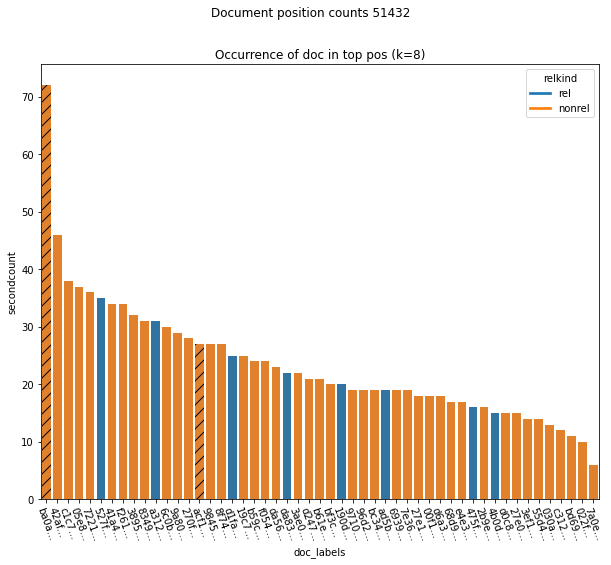

In [131]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [132]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
187,text mining


In [133]:
res = es.search(index='semanticscholar2020og',body={"size": 3, "query": {"ids" : {"values" : ['527f5f6a533fe9b126d650c000aa328bcf1471e1','a3124650908b88c9b2e03b0add30464ef77c11ce','d1fadcb994e67399b10d9721c2cb86fae8a0f15f']}}})
res

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'd1fadcb994e67399b10d9721c2cb86fae8a0f15f',
    '_score': 1.0,
    '_source': {'title': 'Natural Language Processing and Text Mining',
     'paperAbstract': 'Natural Language Processing and Text Mining not only discusses applications of Natural Language Processing techniques to certain Text Mining tasks, but also the converse, the use of Text Mining to assist NLP. It assembles a diverse views from internationally recognized researchers and emphasizes caveats in the attempt to apply Natural Language Processing to text mining. This state-of-the-art survey is a must-have for advanced students, professionals, and researchers.',
     'entities': [],
     'author_names': ['Anne Kao', 'Stephen Poteet'],
     'author_ids': ['2240569', '52518

Authors
d1fadcb994e67399b10d9721c2cb86fae8a0f15f
- ['2240569', '52518300']
a3124650908b88c9b2e03b0add30464ef77c11ce
- ['144621714', '7209654']
527f5f6a533fe9b126d650c000aa328bcf1471e1
-['145321667', '50081327']

In [134]:
for author in  ['2240569', '52518300']:
    print(author_to_doc[author])

['d1fadcb994e67399b10d9721c2cb86fae8a0f15f']
['d1fadcb994e67399b10d9721c2cb86fae8a0f15f']


In [135]:
for author in  ['144621714', '7209654']:
    print(author_to_doc[author])

['a3124650908b88c9b2e03b0add30464ef77c11ce']
['a3124650908b88c9b2e03b0add30464ef77c11ce']


In [136]:
for author in  ['145321667', '50081327']:
    print(author_to_doc[author])

['527f5f6a533fe9b126d650c000aa328bcf1471e1']
['527f5f6a533fe9b126d650c000aa328bcf1471e1']


In [137]:
ereldf_A.query(f"qid == {q} and doc_id in ['527f5f6a533fe9b126d650c000aa328bcf1471e1','a3124650908b88c9b2e03b0add30464ef77c11ce','d1fadcb994e67399b10d9721c2cb86fae8a0f15f']")

,qid,doc_id,relevance,est_relevance
4483,51432,d1fadcb994e67399b10d9721c2cb86fae8a0f15f,1,0.212398
4487,51432,527f5f6a533fe9b126d650c000aa328bcf1471e1,1,0.070220
4510,51432,a3124650908b88c9b2e03b0add30464ef77c11ce,1,0.116003


In [138]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4502,51432,7221c40e8e710365d8f6996e0d64f2ec1d74da8e,0,0.069569
4487,51432,527f5f6a533fe9b126d650c000aa328bcf1471e1,1,0.070220
4496,51432,41a441ce0081c8a829a982dc19c60131bfbde046,0,0.070280
4498,51432,acf1073a9693ebd3c85c3f782774cdc15c1de290,0,0.071057
4525,51432,96d204033af987ff494c6aa1ac18b09c54c4e117,0,0.072232
4509,51432,d0c882bcae6531fa13e75bcc5c297b9985f207f7,0,0.073492
4485,51432,6c0b6846290636dbcd66e9ee3eed2aee1b164261,0,0.075014
4508,51432,7a0e5002fbf02965b30c50540eabcaf6e2117e10,0,0.078759
4490,51432,c1c74829d6430d468a1fe1f75eae217325253baf,0,0.079202
4493,51432,ba0a2237fabd15b63d5408cfc2acc6fb53698042,0,0.079387


In [139]:
0.234634/0.220997

1.061706720000724

In [140]:
0.220997/0.071833

3.07653863823034

###### Remarks
- many documents
527f5f6a533fe9b126d650c000aa328bcf1471e1
- one of the lowest relative estimated relevances
-- maybe disadvantaged early on and therefore advantaged later?

##### 70673
toprels
03e053a5236f33f2999dbee6dee0a7c06844580d

In [141]:
q = 70673

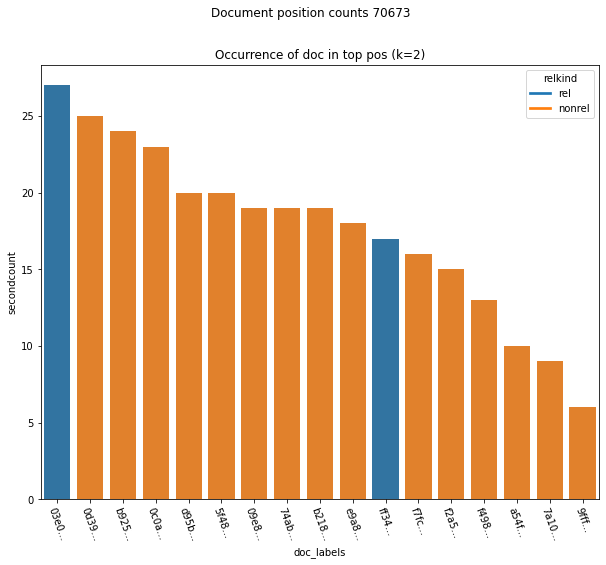

In [142]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [143]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
190,family honor


In [144]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['03e053a5236f33f2999dbee6dee0a7c06844580d']}}})
res

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '03e053a5236f33f2999dbee6dee0a7c06844580d',
    '_score': 1.0,
    '_source': {'title': 'The Honor Code: How Moral Revolutions Happen',
     'paperAbstract': 'Long neglected as an engine of reform, honor strikingly emerges at the center of our modern world in Kwame Anthony Appiah\'s The Honor Code. Over the last few centuries, new democratic movements have led to the emancipation of women, slaves, and the oppressed. But what drove these modern changes, Appiah argues, was not imposing legislation from above, but harnessing the ancient power of honor from within. In gripping detail, he explores the end of the duel in aristocratic England, the tumultuous struggles over footbinding in nineteenth-century China, and the uprising of ordinar

In [145]:
ereldf_A.query(f"qid == {q} and doc_id == '03e053a5236f33f2999dbee6dee0a7c06844580d'")

,qid,doc_id,relevance,est_relevance
4613,70673,03e053a5236f33f2999dbee6dee0a7c06844580d,1,0.206158


In [146]:
author_to_doc['145529080']

['03e053a5236f33f2999dbee6dee0a7c06844580d']

In [147]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4610,70673,a54ff927b6417b2330bf6bb4e676d0698bb820d9,0,0.069005
4608,70673,7a10a4f334fd2881871c9cdd10d53b8968d479d6,0,0.069088
4606,70673,f4980910826e31518865a3a458bfef82d7147796,0,0.086692
4616,70673,f7fc332d0e21691a13ad0fff6c0a8ee05b6c21e2,0,0.115058
4609,70673,f2a5583a742cd9f50b1b839fa3eda08a2fd1d511,0,0.119540
4612,70673,9fff83d91c4697545b727c806cf205d38c9d95ab,0,0.123139
4607,70673,74ab9a06611145658e9a43c07cb6983c4e8ceb87,0,0.156021
4619,70673,e9a83928e4254de05bba63645495e2a6caa489bd,0,0.157274
4620,70673,b218729fcc3183cff899d0ef1fc9407bc547096f,0,0.183286
4611,70673,5f4862ffb96c5b27a37a6ced7fe54459ce6e6fd8,0,0.184673


In [148]:
0.234634/0.220997

1.061706720000724

In [149]:
0.220997/0.071833

3.07653863823034

###### Remarks
- 3 authors, have only written this document
- high-ish relevance, position 5/many
- 1.06 times smaller than highest, +- 3 times higher than lowest

##### 8940
toprels
b0c4f3d96ad476d1e4f377074cd5414973d3cd92
d774b8b767eb53873e0dd0ea4bfaa7744fabcb31





In [150]:
q = 43018

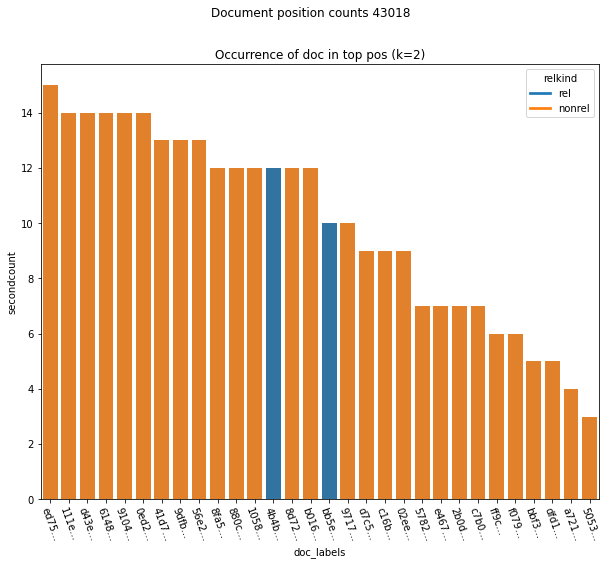

In [151]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [152]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
181,data security medicine


In [153]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['4b4b63405efd22a96cc45b22c08124d62a475d6f']}}})
res

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4b4b63405efd22a96cc45b22c08124d62a475d6f',
    '_score': 1.0,
    '_source': {'title': 'Big healthcare data: preserving security and privacy',
     'paperAbstract': 'Big data has fundamentally changed the way organizations manage, analyze and leverage data in any industry. One of the most promising fields where big data can be applied to make a change is healthcare. Big healthcare data has considerable potential to improve patient outcomes, predict outbreaks of epidemics, gain valuable insights, avoid preventable diseases, reduce the cost of healthcare delivery and improve the quality of life in general. However, deciding on the allowable uses of data while preserving security and patient’s right to privacy is a difficult task. Big 

In [154]:
ereldf_A.query(f"qid == {q} and doc_id == '4b4b63405efd22a96cc45b22c08124d62a475d6f'")

,qid,doc_id,relevance,est_relevance
4383,43018,4b4b63405efd22a96cc45b22c08124d62a475d6f,1,0.220997


In [155]:
author_to_doc['9414241']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [156]:
author_to_doc['1935321']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [157]:
author_to_doc['10441982']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [158]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4374,43018,5053e086955182440b2c3e6bd21a29240b1565ed,0,0.071833
4382,43018,f07914ea6330add99631216026e41e1f8e8de09b,0,0.072056
4372,43018,c7b08740b69b2973f1f73c6f9793f2cee727ff9e,0,0.073956
4386,43018,dfd1ffe1fe37c62e6738fef70447be98778ceab6,0,0.075850
4380,43018,a7216fb6bf0188bcd2ed6f040c9bf1e2226bb744,0,0.080997
4360,43018,bbf3a66ac70269921064cfef39ef258bf8b05f31,0,0.092612
4364,43018,ff9cc7d8f7a4e516d4e9cebdde5f94fadeafc242,0,0.095501
4385,43018,2b0dcadf2a119c84f3f2cc543d6bbaea18d85d6e,0,0.104635
4379,43018,971766088dfaf63fb55e6f0190b14f28f2c98ad0,0,0.105701
4368,43018,d7c5389e10debb6d7af6dc7ca8bf7f2c17a8f7dc,0,0.113038


In [159]:
0.234634/0.220997

1.061706720000724

In [160]:
0.220997/0.071833

3.07653863823034

###### Remarks
- 3 authors, have only written this document
- high-ish relevance, position 5/many
- 1.06 times smaller than highest, +- 3 times higher than lowest

##### 67404
toprels
03f8ca128fa4e9a4f5b9f2f211c0fc9f2793fb3c
c402314407034f3670ce1db0a41d07cee0349a1e




In [161]:
q = 43018

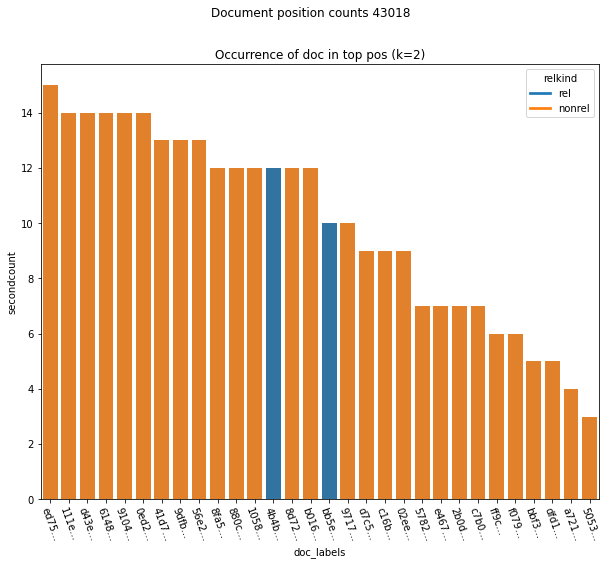

In [162]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [163]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
181,data security medicine


In [164]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['4b4b63405efd22a96cc45b22c08124d62a475d6f']}}})
res

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4b4b63405efd22a96cc45b22c08124d62a475d6f',
    '_score': 1.0,
    '_source': {'title': 'Big healthcare data: preserving security and privacy',
     'paperAbstract': 'Big data has fundamentally changed the way organizations manage, analyze and leverage data in any industry. One of the most promising fields where big data can be applied to make a change is healthcare. Big healthcare data has considerable potential to improve patient outcomes, predict outbreaks of epidemics, gain valuable insights, avoid preventable diseases, reduce the cost of healthcare delivery and improve the quality of life in general. However, deciding on the allowable uses of data while preserving security and patient’s right to privacy is a difficult task. Big 

In [165]:
ereldf_A.query(f"qid == {q} and doc_id == '4b4b63405efd22a96cc45b22c08124d62a475d6f'")

,qid,doc_id,relevance,est_relevance
4383,43018,4b4b63405efd22a96cc45b22c08124d62a475d6f,1,0.220997


In [166]:
author_to_doc['9414241']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [167]:
author_to_doc['1935321']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [168]:
author_to_doc['10441982']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [169]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4374,43018,5053e086955182440b2c3e6bd21a29240b1565ed,0,0.071833
4382,43018,f07914ea6330add99631216026e41e1f8e8de09b,0,0.072056
4372,43018,c7b08740b69b2973f1f73c6f9793f2cee727ff9e,0,0.073956
4386,43018,dfd1ffe1fe37c62e6738fef70447be98778ceab6,0,0.075850
4380,43018,a7216fb6bf0188bcd2ed6f040c9bf1e2226bb744,0,0.080997
4360,43018,bbf3a66ac70269921064cfef39ef258bf8b05f31,0,0.092612
4364,43018,ff9cc7d8f7a4e516d4e9cebdde5f94fadeafc242,0,0.095501
4385,43018,2b0dcadf2a119c84f3f2cc543d6bbaea18d85d6e,0,0.104635
4379,43018,971766088dfaf63fb55e6f0190b14f28f2c98ad0,0,0.105701
4368,43018,d7c5389e10debb6d7af6dc7ca8bf7f2c17a8f7dc,0,0.113038


In [170]:
0.234634/0.220997

1.061706720000724

In [171]:
0.220997/0.071833

3.07653863823034

###### Remarks
- 3 authors, have only written this document
- high-ish relevance, position 5/many
- 1.06 times smaller than highest, +- 3 times higher than lowest

##### 49766
toprels
66d2acae2985f4aa01c8625d615482cb618e9dd9

In [172]:
q = 43018

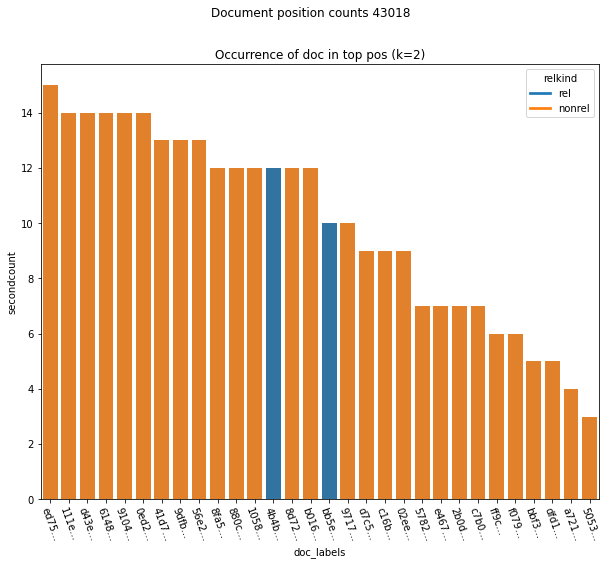

In [173]:
plot_doc_pos_count_for_qid(q,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [174]:
reldf.query(f'qid == {q}')[['query']].drop_duplicates()

,query
181,data security medicine


In [175]:
res = es.search(index='semanticscholar2020og',body={"size": 2, "query": {"ids" : {"values" : ['4b4b63405efd22a96cc45b22c08124d62a475d6f']}}})
res

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '4b4b63405efd22a96cc45b22c08124d62a475d6f',
    '_score': 1.0,
    '_source': {'title': 'Big healthcare data: preserving security and privacy',
     'paperAbstract': 'Big data has fundamentally changed the way organizations manage, analyze and leverage data in any industry. One of the most promising fields where big data can be applied to make a change is healthcare. Big healthcare data has considerable potential to improve patient outcomes, predict outbreaks of epidemics, gain valuable insights, avoid preventable diseases, reduce the cost of healthcare delivery and improve the quality of life in general. However, deciding on the allowable uses of data while preserving security and patient’s right to privacy is a difficult task. Big 

In [176]:
ereldf_A.query(f"qid == {q} and doc_id == '4b4b63405efd22a96cc45b22c08124d62a475d6f'")

,qid,doc_id,relevance,est_relevance
4383,43018,4b4b63405efd22a96cc45b22c08124d62a475d6f,1,0.220997


In [177]:
author_to_doc['9414241']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [178]:
author_to_doc['1935321']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [179]:
author_to_doc['10441982']

['4b4b63405efd22a96cc45b22c08124d62a475d6f']

In [180]:
ereldf_A.query(f"qid == {q}").sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4374,43018,5053e086955182440b2c3e6bd21a29240b1565ed,0,0.071833
4382,43018,f07914ea6330add99631216026e41e1f8e8de09b,0,0.072056
4372,43018,c7b08740b69b2973f1f73c6f9793f2cee727ff9e,0,0.073956
4386,43018,dfd1ffe1fe37c62e6738fef70447be98778ceab6,0,0.075850
4380,43018,a7216fb6bf0188bcd2ed6f040c9bf1e2226bb744,0,0.080997
4360,43018,bbf3a66ac70269921064cfef39ef258bf8b05f31,0,0.092612
4364,43018,ff9cc7d8f7a4e516d4e9cebdde5f94fadeafc242,0,0.095501
4385,43018,2b0dcadf2a119c84f3f2cc543d6bbaea18d85d6e,0,0.104635
4379,43018,971766088dfaf63fb55e6f0190b14f28f2c98ad0,0,0.105701
4368,43018,d7c5389e10debb6d7af6dc7ca8bf7f2c17a8f7dc,0,0.113038


In [181]:
0.234634/0.220997

1.061706720000724

In [182]:
0.220997/0.071833

3.07653863823034

###### Remarks
- 3 authors, have only written this document
- high-ish relevance, position 5/many
- 1.06 times smaller than highest, +- 3 times higher than lowest

## 5. Is the performance of the system in terms of EEL𝑖𝑛𝑑 or EELℎ mostly due to high disparity, low relevance, or both?

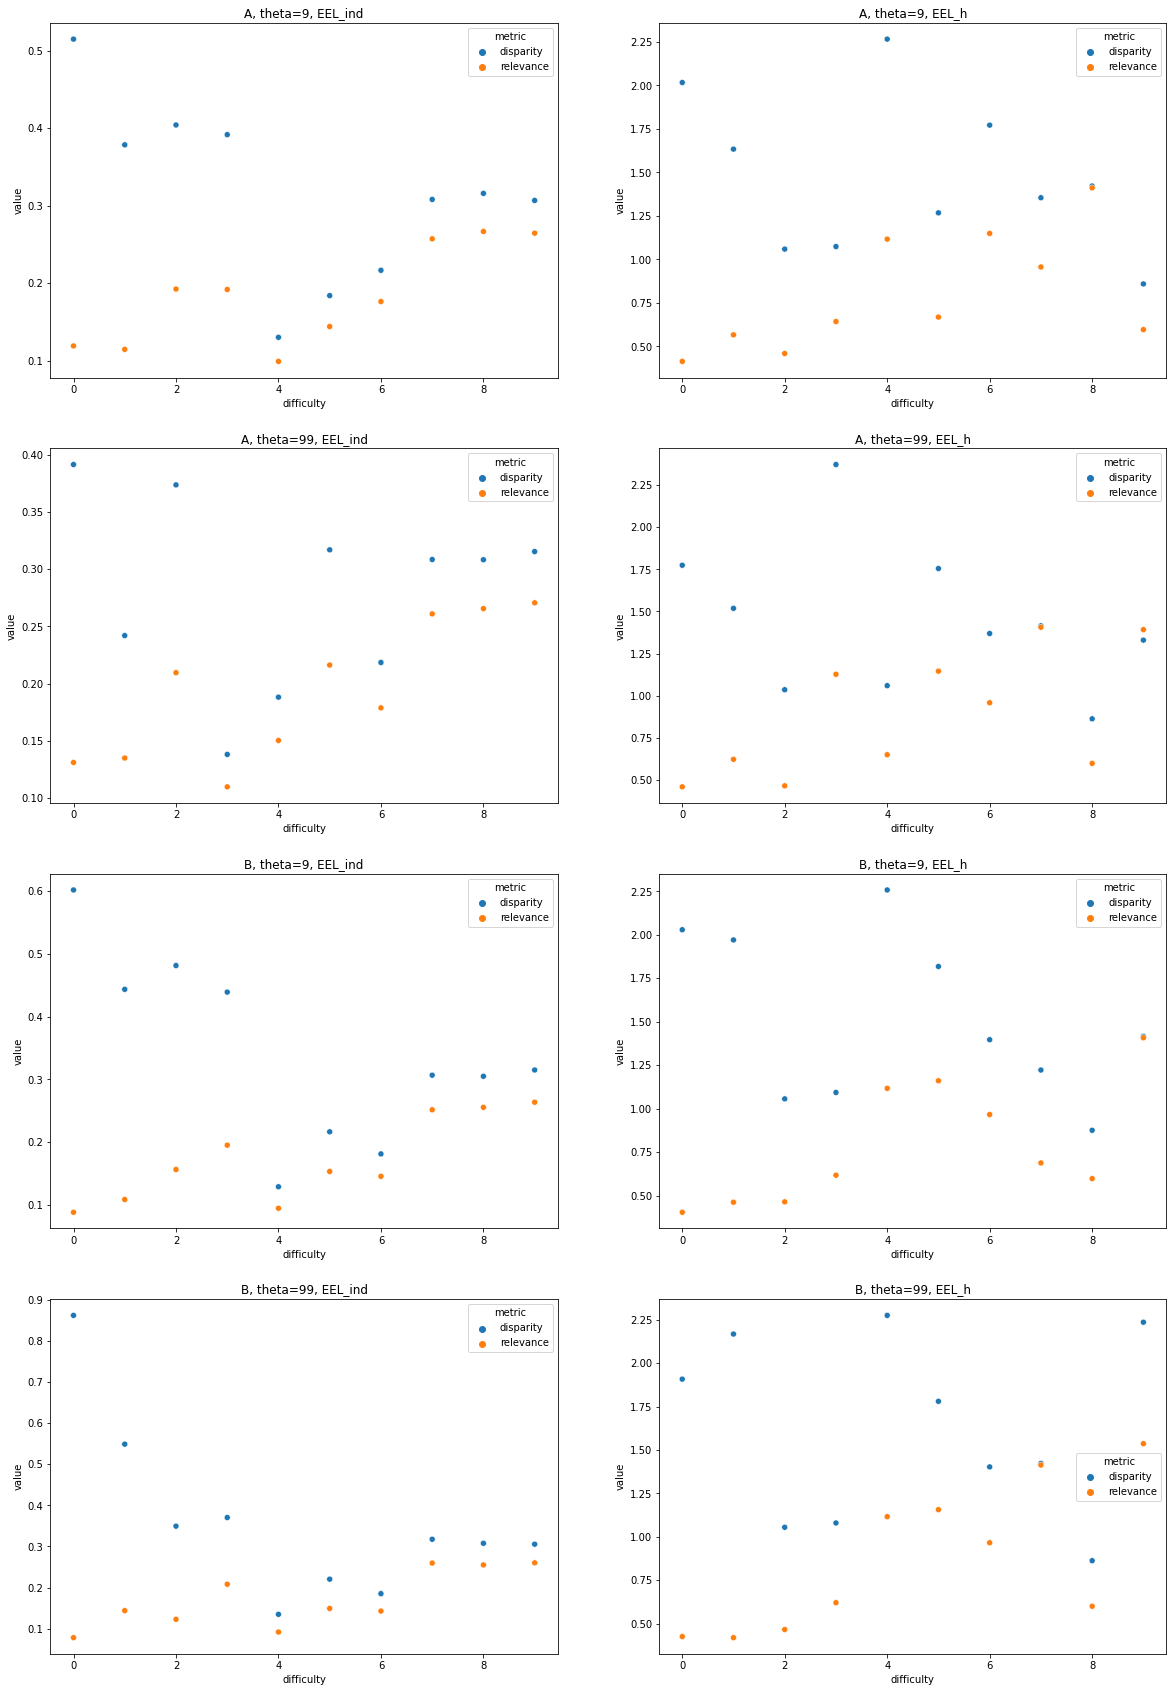

In [364]:
n = 10
fig, ax = plt.subplots(4,2,figsize = (20,30))
pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)
titles = [['A, theta=9, EEL_ind', 'A, theta=9, EEL_h'],['A, theta=99, EEL_ind', 'A, theta=99, EEL_h'],['B, theta=9, EEL_ind', 'B, theta=9, EEL_h'],['B, theta=99, EEL_ind', 'B, theta=99, EEL_h']]


for i, eee in enumerate([[edf_ac_A_9_err,edf_ac_A_9_eel],[edf_ac_A_99_err,edf_ac_A_99_eel],[edf_ac_B_9_err,edf_ac_B_9_eel],[edf_ac_B_99_err,edf_ac_B_99_eel]]):
    for j,eeee in enumerate(eee):
        

        dif_disp_rel = eeee[:n].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
        disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
        relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
        concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
        # print(concatenated.head())

        # ax2 = ax.twinx()

        ax[i][j].set_title(titles[i][j])

        sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax[i][j])



# fig.suptitle('Relevance and disparity versus difficulty')

key  difficulty     value     metric
0             0  2.016028  disparity
1             1  1.633312  disparity
2             2  1.058855  disparity
3             3  1.073464  disparity
4             4  2.265468  disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

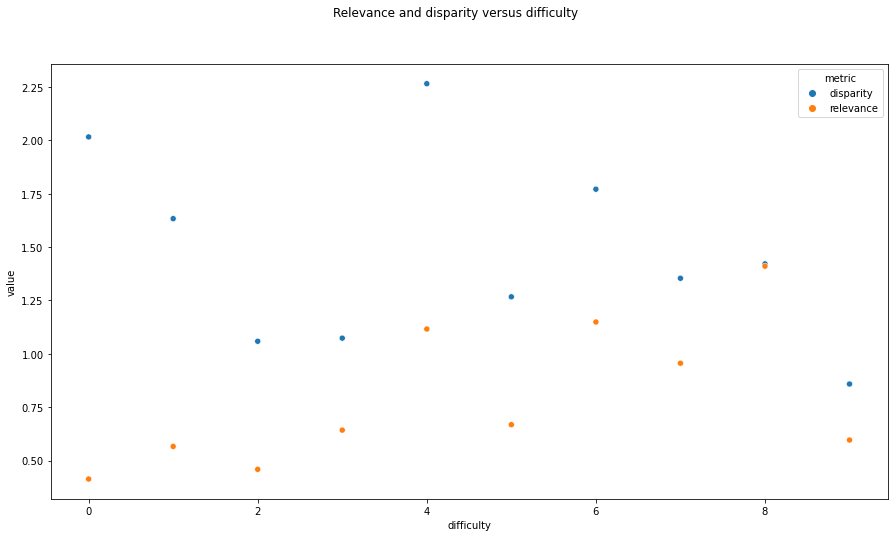

In [355]:
n = 10
dif_disp_rel = edf_ac_A_9_eel[:n].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
print(concatenated.head())

fig, ax = plt.subplots(1,1,figsize = (15,8))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

key  difficulty     value     metric
0             0  0.391477  disparity
1             1  0.241990  disparity
2             2  0.373706  disparity
3             3  0.138131  disparity
4             4  0.188191  disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

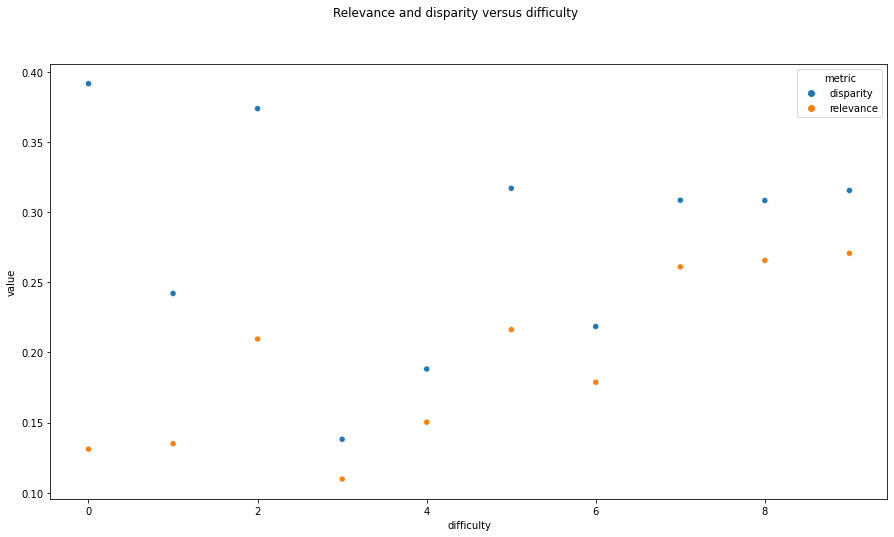

In [356]:
n = 10
dif_disp_rel = edf_ac_A_99_err[:n].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
print(concatenated.head())

fig, ax = plt.subplots(1,1,figsize = (15,8))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

key  difficulty     value     metric
0             0  1.774391  disparity
1             1  1.518728  disparity
2             2  1.035524  disparity
3             3  2.372007  disparity
4             4  1.059813  disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

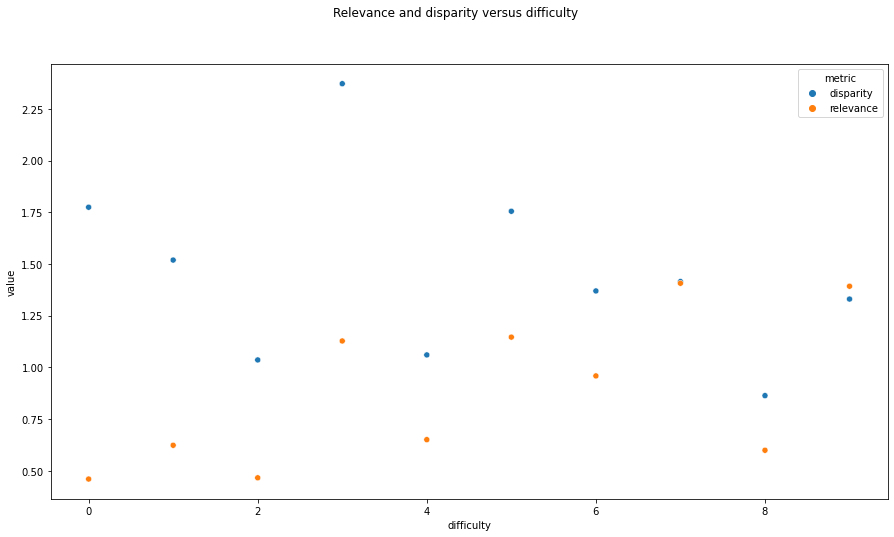

In [357]:
n = 10
dif_disp_rel = edf_ac_A_99_eel[:n].reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
print(concatenated.head())

fig, ax = plt.subplots(1,1,figsize = (15,8))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

## 6. What obvious mistakes did the system make that it could have easily avoided?

#### H: Documents without author that are (not) advantaged have a relatively high (low) estimated relevance

##### 12073
- b800... advantaged for $\theta = 0.9$, disadvantaged for $\theta = 0.99$  
  - A: 0.110601, pos 34/42
  - B: 0.070365, pos 41/42 
- Relatively poor estimated relevance

In [239]:
ereldf_A[ereldf_A.qid == 12073].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,12073,07a8123ba4e50378a9c89aa0aa5134e2e600bc07,0,0.228761
1,12073,a3f9dcf7170105ce1e39a63ae99f7334ecaf3182,0,0.225697
2,12073,ba66ca44721b80f9dd2bd7d675150d722264dbf2,0,0.214153
3,12073,9d8ccd08ae89d502d3d75ec046dff942f260cb7a,1,0.212898
4,12073,600b2f9b556295cba4db856f917824e46da6e338,0,0.212710
5,12073,08f4b3d292d801878ec3b0445e35ef4ad8c5193e,0,0.202161
6,12073,c5fab88c2b128bfba9ac4c6197e19bc9e4e6b2a3,0,0.199403
7,12073,33f1a8d9f516c736eddfa292d922774220cb8bd6,0,0.197423
8,12073,ebfc96d215389f1f284c1e51d20473fd935d6448,0,0.197115
9,12073,8b28194acc5d5d7c2161e4fc73198b70bebf4a3d,0,0.196906


In [241]:
ereldf_B[ereldf_B.qid == 12073].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,12073,a3f9dcf7170105ce1e39a63ae99f7334ecaf3182,0,0.248407
1,12073,07a8123ba4e50378a9c89aa0aa5134e2e600bc07,0,0.242377
2,12073,600b2f9b556295cba4db856f917824e46da6e338,0,0.222424
3,12073,ba66ca44721b80f9dd2bd7d675150d722264dbf2,0,0.213384
4,12073,9d8ccd08ae89d502d3d75ec046dff942f260cb7a,1,0.211169
5,12073,65aadf99f4bb5948164f65a99d46d1fafc74e158,1,0.205519
6,12073,3d614a0da2dc71c4068f8e9bcc32067959b8e00f,1,0.199011
7,12073,ebfc96d215389f1f284c1e51d20473fd935d6448,0,0.192332
8,12073,8b28194acc5d5d7c2161e4fc73198b70bebf4a3d,0,0.191795
9,12073,8334919584cd6ae64869c68a34d73c27f9b02dbe,1,0.189877


##### 54003
- f098... advantaged
  - A: 0.110638, pos 10/12
  - B: 0.212732, pos 2/12 
- cb5c... advantaged for all except B, $\theta = 0.99$
  - A: 0.110638, pos 11/12
  - B: 0.212732, pos 3/12 

- The two documents have the same estimated relevance, order broken randomly.
- For the one setting for which cb5c... is less advantaged its relative relevance is good.
- May have something to do with random breaking of ties: currently always in the same pandas-determined order, but may be better to break ties randomly so at least not same item always advantaged!

In [242]:
ereldf_A[ereldf_A.qid == 54003].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,54003,e3c4eb70e447d12308e32f3b01aefb12c31d3436,0,0.207594
1,54003,f6d0c86e407ef0dfdd3de1ae675999e05ef46cfd,0,0.206637
2,54003,752ebeff241d9412b337a91726585c1d0d20abd6,1,0.204991
3,54003,ac073aad573ef9ca951d7f494d558ff9d2c0618f,0,0.191865
4,54003,fa04d8f27007cd5ce58071792b0e6db099f1c239,0,0.180354
5,54003,01b96c0608e3608017f7024f833d758d80ee2141,1,0.180158
6,54003,ee4b17775ef5eb4cb249d538d6398105fb95ba8c,0,0.176954
7,54003,25df388cb0718f4fdcf6ccb7f790408b12af0658,0,0.164716
8,54003,7afe176bcc6837cd312e6c65f62369929dae60c1,0,0.153217
9,54003,f098b954118322937fbeab72167316c6487bd532,0,0.110638


In [243]:
ereldf_B[ereldf_B.qid == 54003].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,54003,7afe176bcc6837cd312e6c65f62369929dae60c1,0,0.217627
1,54003,f098b954118322937fbeab72167316c6487bd532,0,0.212732
2,54003,cb5c8551f3da94fed52008243732ed4bbf4dc286,0,0.212732
3,54003,e3c4eb70e447d12308e32f3b01aefb12c31d3436,0,0.185959
4,54003,752ebeff241d9412b337a91726585c1d0d20abd6,1,0.179287
5,54003,f6d0c86e407ef0dfdd3de1ae675999e05ef46cfd,0,0.169841
6,54003,463be6db0487c1215bfa2896d3d636eac2a6ce34,0,0.153755
7,54003,ac073aad573ef9ca951d7f494d558ff9d2c0618f,0,0.139786
8,54003,01b96c0608e3608017f7024f833d758d80ee2141,1,0.106601
9,54003,25df388cb0718f4fdcf6ccb7f790408b12af0658,0,0.104794


##### 51432
- acf1... advantaged for $\theta = 0.9$, dis for opposite
  - A: 0.071057, pos 48/51
  - B: 0.086018, pos 47/51 
- ba0a... advantaged for $\theta = 0.9$, dis for opposite
  - A: 0.079387, pos 42/58
  - B: 0.084094, pos 50/51 


- Both documents have relatively poor est rel, they're advantaged by the hyp par config that weighs author advantage more and disadv by the config that weighs est rel more.

In [72]:
ereldf_A[ereldf_A.qid == 51432].sort_values(by='est_relevance', ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,51432,030a0f9d97c9e2a5099723bcc9e74c34e7a95945,0,0.259777
1,51432,55d484c6fcc6fa00bdfe3dc8d579b870ad248f2e,0,0.226058
2,51432,bd69676ffba4e47cb3dfbac57583f633ac3b1b1c,0,0.225686
3,51432,e4e35f7150db8c3828dd6089c6dc0dc7f0b56bdd,0,0.222249
4,51432,00f1fe233881777c97ead8528324e7c807ef9dfc,0,0.220502
5,51432,4b0d321b796d2ed4705617be64d8c70a4653704f,1,0.216382
6,51432,d1fadcb994e67399b10d9721c2cb86fae8a0f15f,1,0.212398
7,51432,bf3c811311babb0cfd45f335641649bf563112dd,0,0.211209
8,51432,c312b1424c9d25fd8ebd1f01a0c7fb6cba9e998f,0,0.209965
9,51432,022fefc586dc4245aa714419a0d6b16ceff5afc3,0,0.203478


In [73]:
ereldf_B[ereldf_B.qid == 51432].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,51432,030a0f9d97c9e2a5099723bcc9e74c34e7a95945,0,0.254169
1,51432,e4e35f7150db8c3828dd6089c6dc0dc7f0b56bdd,0,0.231194
2,51432,693914b7f38c19585e35668fd626aecf62d4c5e7,0,0.221726
3,51432,55d484c6fcc6fa00bdfe3dc8d579b870ad248f2e,0,0.210191
4,51432,bd69676ffba4e47cb3dfbac57583f633ac3b1b1c,0,0.209889
5,51432,3ae06b21b40cffa07ac1e92e0c453aa835f8a70b,0,0.206883
6,51432,00f1fe233881777c97ead8528324e7c807ef9dfc,0,0.203619
7,51432,8f74f5623c4e5c5931641a264cfd7c02097e1e22,0,0.201999
8,51432,4b0d321b796d2ed4705617be64d8c70a4653704f,1,0.201753
9,51432,bf3c811311babb0cfd45f335641649bf563112dd,0,0.196458


##### 30631
- 0e43... advantaged
  - A: 0.124778, pos 16/20
  - B: 0.213887, pos 1/20 
- 9433... disadvantaged
  - A: 0.124778, pos 19/20
  - B: 0.157759, pos 11/20 
- 8d44... disadvantaged
  - A: 0.104101, pos 18/20
  - B: 0.149880, pos 12/20
- 4f7c... advantaged, except disadvantaged for set A
  - A: 0.111590, pos 17/20
  - B: 0.212311, pos 3/20
  
- All disadvantaged have low relative position.
- 0e43 advantaged regardless of position, helped by disadvantaging of 4f7c for set A? They are close in est rel/pos.
- Interesting here that there are four authorless documents, muddling factor? Correction breaks down when no author info available?

In [246]:
ereldf_A[ereldf_A.qid == 30631].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,30631,1601e9f2bbf89f04f967a4f5f49d7adeca7f0719,0,0.231227
1,30631,32b9fbe02a36c08117122e3f99421faad46876db,0,0.222271
2,30631,79ddbeff892277592aa387045692e0a738ef9edf,0,0.219872
3,30631,22edc9d8bb18253cdbb7905492c73387b4aee8c4,0,0.208882
4,30631,d6a00a2777afe09954d240b2b7bd6a6e2011e04b,0,0.205536
5,30631,3aebc8afc97439a26332526ba4c362771e332087,0,0.196632
6,30631,8cb3c7f7716217bd54a97f220f73dc07ef1220c4,0,0.195076
7,30631,ab609df01b35223d4c1ec4d6fe84cfe349ad608b,1,0.191062
8,30631,3eda3b93c90dba68e1a8a50fa79d26155abd49db,0,0.174550
9,30631,ccaea944996c0935897cd6eb248d5f01367cd3c4,1,0.169794


In [247]:
ereldf_B[ereldf_B.qid == 30631].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced,0,0.213887
1,30631,1601e9f2bbf89f04f967a4f5f49d7adeca7f0719,0,0.213887
2,30631,4f7cebcc071e129d41df4766d1aed1c55e236311,0,0.212311
3,30631,32b9fbe02a36c08117122e3f99421faad46876db,0,0.212182
4,30631,79ddbeff892277592aa387045692e0a738ef9edf,0,0.208915
5,30631,22edc9d8bb18253cdbb7905492c73387b4aee8c4,0,0.202029
6,30631,8cb3c7f7716217bd54a97f220f73dc07ef1220c4,0,0.184026
7,30631,d6a00a2777afe09954d240b2b7bd6a6e2011e04b,0,0.182281
8,30631,ab609df01b35223d4c1ec4d6fe84cfe349ad608b,1,0.182278
9,30631,3aebc8afc97439a26332526ba4c362771e332087,0,0.159646


##### 10795
- 86c0... advantaged for $\theta = 0.9$
  - A: 0.0, pos 37/37
  - B: 0.0, pos 37/37
  
- Has no erel so we set it to 0. 
- For config that weighs authors more this does not matter.



In [250]:
ereldf_A[ereldf_A.qid == 10795].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,10795,ef7bfa013689524c27370ef7849789b48ff42656,1,0.251015
1,10795,4d5251c0520ee6698087ee37864079e19d56b2f8,0,0.237193
2,10795,4145a64995792f84d456e62ef83f1404251893c3,0,0.228462
3,10795,6a224ae28b30026c7d3566280123f0488d83c550,1,0.225445
4,10795,c7f6a6728adfa3d29327384bdfedb297ccff3613,0,0.207273
5,10795,f85bd7fe8f93f31ca95ac7fc79bffd7718172e87,0,0.205102
6,10795,9a7c723c68cfaaf25e9d015eddaedefb4a709f71,0,0.203882
7,10795,1becf91544a459746807e0a5e8f83957317765a4,0,0.202719
8,10795,c885d082a3840bc52205085597ab9445e3429748,0,0.202644
9,10795,88cd22f12775a79cd9cb402f3e25e19c02c2f058,0,0.201255


In [248]:
ereldf_B[ereldf_B.qid == 10795].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,10795,ef7bfa013689524c27370ef7849789b48ff42656,1,0.247599
1,10795,4d5251c0520ee6698087ee37864079e19d56b2f8,0,0.229281
2,10795,4145a64995792f84d456e62ef83f1404251893c3,0,0.219887
3,10795,6a224ae28b30026c7d3566280123f0488d83c550,1,0.216713
4,10795,c7f6a6728adfa3d29327384bdfedb297ccff3613,0,0.199243
5,10795,f85bd7fe8f93f31ca95ac7fc79bffd7718172e87,0,0.196641
6,10795,9a7c723c68cfaaf25e9d015eddaedefb4a709f71,0,0.195112
7,10795,88cd22f12775a79cd9cb402f3e25e19c02c2f058,0,0.193753
8,10795,1becf91544a459746807e0a5e8f83957317765a4,0,0.193608
9,10795,c885d082a3840bc52205085597ab9445e3429748,0,0.193510


##### 31412
- 3941... advantaged
  - A: 0.076889, pos 17/19
  - B: 0.130235, pos 15/19
  
- Poor relative relevance, but advantaged nonetheless.


In [251]:
ereldf_A[ereldf_A.qid == 31412].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,31412,c8b3f498a39dd52aceb684e7052bc5938c1aba51,0,0.243852
1,31412,bcefce5aef53be840a92db6302aff0b477daefa3,0,0.228132
2,31412,b638d404a28a56d5553e84bea7450712f5cf00ba,0,0.224887
3,31412,4fdde4e7831e03ad2219c87dbb8b32550772e931,0,0.209392
4,31412,59ab54f50c6a278425bdbf115921bd2f94923e28,1,0.190921
5,31412,3aebc8afc97439a26332526ba4c362771e332087,0,0.180838
6,31412,4205add90858f6d1d8f942bb909fb5c95aa5821b,0,0.174241
7,31412,a224d37a6023762fe465fd56e9c6ed00423a2930,0,0.171503
8,31412,5bf8e8f158130dabba8cb5af3df9f18d8d2bcf3f,0,0.166592
9,31412,525065701dcc1a0c8ee64e22a832343e663da46e,0,0.165136


In [252]:
ereldf_B[ereldf_B.qid == 31412].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,31412,c8b3f498a39dd52aceb684e7052bc5938c1aba51,0,0.242076
1,31412,bcefce5aef53be840a92db6302aff0b477daefa3,0,0.227855
2,31412,b638d404a28a56d5553e84bea7450712f5cf00ba,0,0.218732
3,31412,4fdde4e7831e03ad2219c87dbb8b32550772e931,0,0.203451
4,31412,bdfa1a62c964f19b5ce000d7812ba9f66456a4a4,1,0.162941
5,31412,4205add90858f6d1d8f942bb909fb5c95aa5821b,0,0.157855
6,31412,a224d37a6023762fe465fd56e9c6ed00423a2930,0,0.152975
7,31412,81b95e0483d32945aad0c09849f1a9b2022d59c4,0,0.149438
8,31412,59ab54f50c6a278425bdbf115921bd2f94923e28,1,0.148922
9,31412,3aebc8afc97439a26332526ba4c362771e332087,0,0.144578


##### 12828
- da4c... advantaged
  - A: 0.069007, pos 12/12
  - B: 0.094983, pos 11/12 


In [255]:
ereldf_A[ereldf_A.qid == 12828].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,12828,bcf4bb3fb3dd383d2343eea16db430837c1ffab2,0,0.246186
1,12828,3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6,0,0.191437
2,12828,398fc22f908a0af6c8d3d5e328a6092aab304d08,1,0.189084
3,12828,a224d37a6023762fe465fd56e9c6ed00423a2930,0,0.186223
4,12828,f0206b8800f0f22c26d4af0112adb80f31d6fafb,0,0.185270
5,12828,066e50b8bb96cc223327cfdcf3c444cbffa62ceb,1,0.183744
6,12828,927cc14b1c65106c40a5e162ec55f867f33089d3,0,0.166702
7,12828,38053991fb0eef895330f082556da9cfcf2388d6,0,0.165664
8,12828,266b0f7ccf2e34572ac9510d76f51c3abd91cc0d,0,0.144423
9,12828,fa9ba8c564465f5ecb3ea05c620ce0ca005d10ae,0,0.092245


In [256]:
ereldf_B[ereldf_B.qid == 12828].sort_values(by='est_relevance',ascending=False).reset_index(drop=True)

,qid,doc_id,relevance,est_relevance
0,12828,bcf4bb3fb3dd383d2343eea16db430837c1ffab2,0,0.243999
1,12828,398fc22f908a0af6c8d3d5e328a6092aab304d08,1,0.202343
2,12828,3b29ec2c0e9de927f80feeeb5337a832ee6cd3b6,0,0.193655
3,12828,38053991fb0eef895330f082556da9cfcf2388d6,0,0.184698
4,12828,a224d37a6023762fe465fd56e9c6ed00423a2930,0,0.162686
5,12828,066e50b8bb96cc223327cfdcf3c444cbffa62ceb,1,0.159420
6,12828,927cc14b1c65106c40a5e162ec55f867f33089d3,0,0.145835
7,12828,f0206b8800f0f22c26d4af0112adb80f31d6fafb,0,0.128119
8,12828,fa9ba8c564465f5ecb3ea05c620ce0ca005d10ae,0,0.117242
9,12828,266b0f7ccf2e34572ac9510d76f51c3abd91cc0d,0,0.114471


## 7. Other features of note  

### Authorless document that is pretty low in the ranking --> low relative relevance

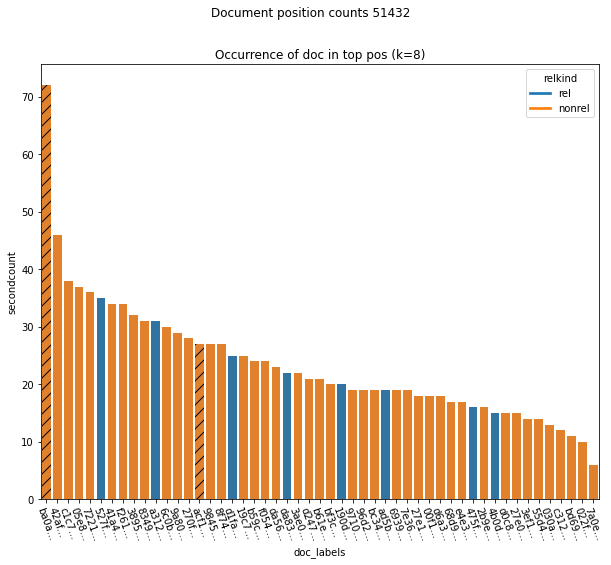

In [351]:
plot_doc_pos_count_for_qid(51432,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [358]:
ranking_to_df(rdf_ac_A_9,reldf).query('doc_id.str.startswith("acf")')[['doc_id','doc_rel']].drop_duplicates()

,doc_id,doc_rel
24647,acf1073a9693ebd3c85c3f782774cdc15c1de290,0


In [359]:
ereldf_A.query('doc_id == "acf1073a9693ebd3c85c3f782774cdc15c1de290"')

,qid,doc_id,relevance,est_relevance
4498,51432,acf1073a9693ebd3c85c3f782774cdc15c1de290,0,0.071057


In [362]:
ereldf_A.query('qid == 51432').sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4502,51432,7221c40e8e710365d8f6996e0d64f2ec1d74da8e,0,0.069569
4487,51432,527f5f6a533fe9b126d650c000aa328bcf1471e1,1,0.070220
4496,51432,41a441ce0081c8a829a982dc19c60131bfbde046,0,0.070280
4498,51432,acf1073a9693ebd3c85c3f782774cdc15c1de290,0,0.071057
4525,51432,96d204033af987ff494c6aa1ac18b09c54c4e117,0,0.072232
4509,51432,d0c882bcae6531fa13e75bcc5c297b9985f207f7,0,0.073492
4485,51432,6c0b6846290636dbcd66e9ee3eed2aee1b164261,0,0.075014
4508,51432,7a0e5002fbf02965b30c50540eabcaf6e2117e10,0,0.078759
4490,51432,c1c74829d6430d468a1fe1f75eae217325253baf,0,0.079202
4493,51432,ba0a2237fabd15b63d5408cfc2acc6fb53698042,0,0.079387


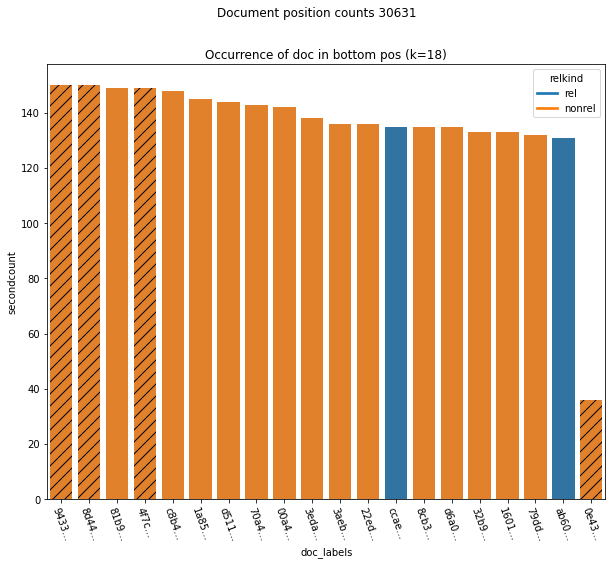

In [384]:
plot_doc_pos_count_for_qid(30631,rdf_ac_A_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='bot')

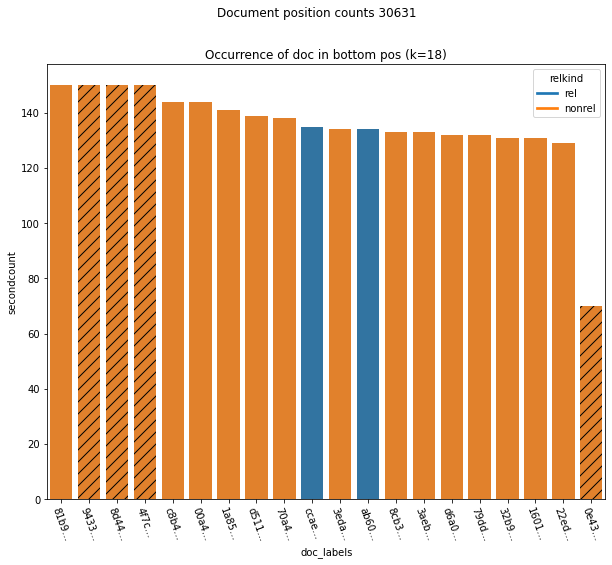

In [385]:
plot_doc_pos_count_for_qid(30631,rdf_ac_A_99,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='bot')

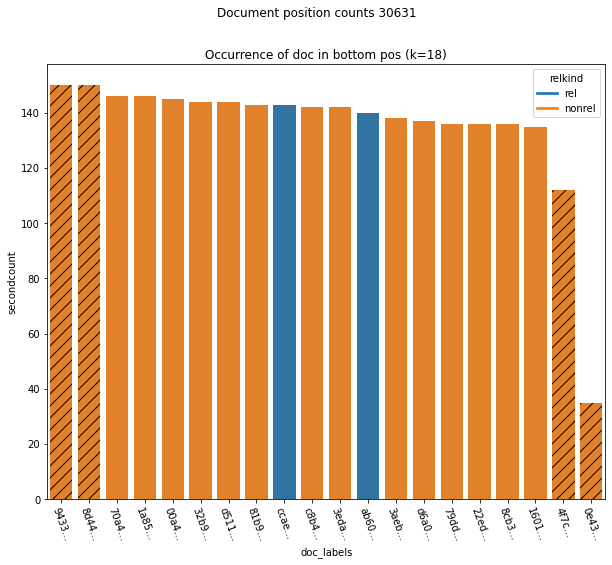

In [386]:
plot_doc_pos_count_for_qid(30631,rdf_ac_B_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='bot')

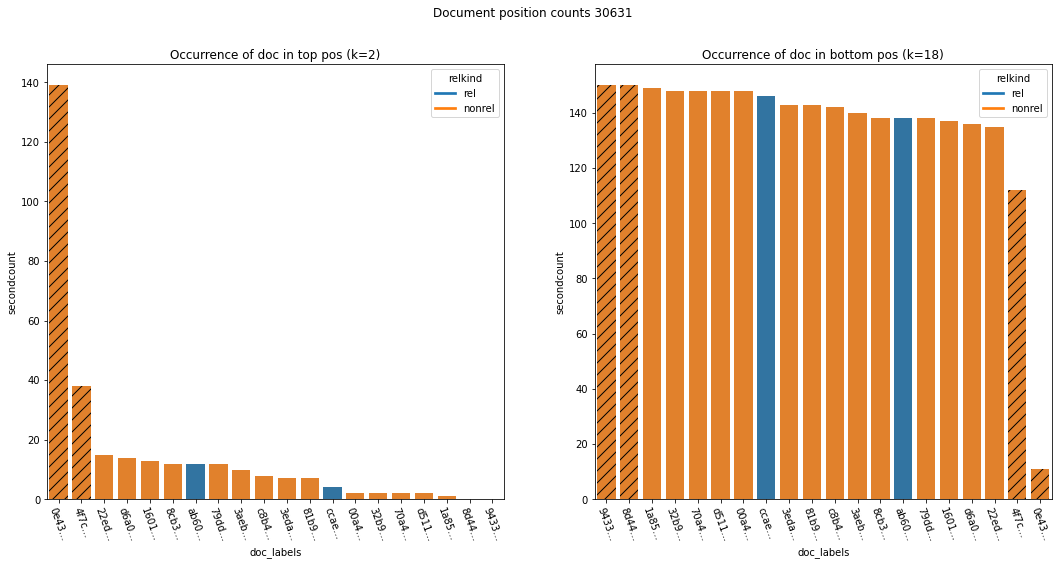

In [406]:
plot_doc_pos_count_for_qid(30631,rdf_ac_B_99,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese=['top','bot'])

In [391]:
ranking_to_df(rdf_ac_A_9,reldf).query('doc_id.str.startswith("9433") or doc_id.str.startswith("8d44") or doc_id.str.startswith("4f7c")')[['doc_id','doc_rel']].drop_duplicates()

,doc_id,doc_rel
21616,4f7cebcc071e129d41df4766d1aed1c55e236311,0
21617,8d442ea1c14504e6e5676d82e78e1330c354731f,0
21618,943320b3c05a7aeace900e28d0c6d434804363b4,0


In [396]:
ereldf_A.query('qid == 30631 and doc_id == "4f7cebcc071e129d41df4766d1aed1c55e236311"')

,qid,doc_id,relevance,est_relevance
4480,30631,4f7cebcc071e129d41df4766d1aed1c55e236311,0,0.11159


In [399]:
ereldf_A.query('qid == 30631 and doc_id == "8d442ea1c14504e6e5676d82e78e1330c354731f"')

,qid,doc_id,relevance,est_relevance
4467,30631,8d442ea1c14504e6e5676d82e78e1330c354731f,0,0.104101


In [400]:
ereldf_A.query('qid == 30631 and doc_id == "943320b3c05a7aeace900e28d0c6d434804363b4"')

,qid,doc_id,relevance,est_relevance
4481,30631,943320b3c05a7aeace900e28d0c6d434804363b4,0,0.069432


In [401]:
ereldf_A.query('qid == 30631').sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4474,30631,81b95e0483d32945aad0c09849f1a9b2022d59c4,0,0.065416
4481,30631,943320b3c05a7aeace900e28d0c6d434804363b4,0,0.069432
4467,30631,8d442ea1c14504e6e5676d82e78e1330c354731f,0,0.104101
4480,30631,4f7cebcc071e129d41df4766d1aed1c55e236311,0,0.111590
4472,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced,0,0.124778
4466,30631,c8b45c6052cbc388de67682ac02a185fc62ba815,0,0.127159
4479,30631,00a407540a8bdd6d7425bd8a561eb21d69682511,0,0.134421
4465,30631,d511f3a98d460f7967dd490e34d664caac1529d1,0,0.137287
4476,30631,1a854bfceb615249fd9c75f3f4491b0554e59c16,0,0.138070
4464,30631,70a462ada6a79125940a46d48e430fa938054819,0,0.148966


In [402]:
ereldf_B.query('qid == 30631 and doc_id == "4f7cebcc071e129d41df4766d1aed1c55e236311"')

,qid,doc_id,relevance,est_relevance
4480,30631,4f7cebcc071e129d41df4766d1aed1c55e236311,0,0.212311


In [403]:
ereldf_B.query('qid == 30631 and doc_id == "8d442ea1c14504e6e5676d82e78e1330c354731f"')

,qid,doc_id,relevance,est_relevance
4467,30631,8d442ea1c14504e6e5676d82e78e1330c354731f,0,0.14988


In [404]:
ereldf_B.query('qid == 30631 and doc_id == "943320b3c05a7aeace900e28d0c6d434804363b4"')

,qid,doc_id,relevance,est_relevance
4481,30631,943320b3c05a7aeace900e28d0c6d434804363b4,0,0.157759


In [405]:
ereldf_B.query('qid == 30631').sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4476,30631,1a854bfceb615249fd9c75f3f4491b0554e59c16,0,0.069143
4464,30631,70a462ada6a79125940a46d48e430fa938054819,0,0.080605
4479,30631,00a407540a8bdd6d7425bd8a561eb21d69682511,0,0.086584
4465,30631,d511f3a98d460f7967dd490e34d664caac1529d1,0,0.090476
4463,30631,ccaea944996c0935897cd6eb248d5f01367cd3c4,1,0.115378
4474,30631,81b95e0483d32945aad0c09849f1a9b2022d59c4,0,0.122656
4471,30631,3eda3b93c90dba68e1a8a50fa79d26155abd49db,0,0.125899
4466,30631,c8b45c6052cbc388de67682ac02a185fc62ba815,0,0.148366
4467,30631,8d442ea1c14504e6e5676d82e78e1330c354731f,0,0.149880
4481,30631,943320b3c05a7aeace900e28d0c6d434804363b4,0,0.157759


For B, 4f7cebcc071e129d41df4766d1aed1c55e236311 has one of the highest rels, but 0e43caeb9d476264d307e8da0ad71ecc4d804ced has even higher. And: these are ranked 1 and 2!

### One authorless document lower than the other, is actually the one with higher estimated relevance!

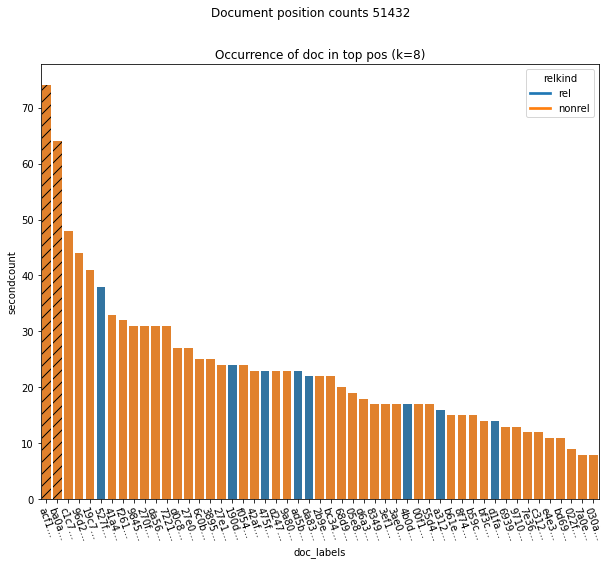

In [366]:
plot_doc_pos_count_for_qid(51432,rdf_ac_B_9,reldf,sortby=['count'], no_author_ids=noauth_docids,plotthese='top')

In [367]:
ranking_to_df(rdf_ac_B_9,reldf).query('doc_id.str.startswith("acf") or doc_id.str.startswith("ba0a")')[['doc_id','doc_rel']].drop_duplicates()

,doc_id,doc_rel
24646,acf1073a9693ebd3c85c3f782774cdc15c1de290,0
24649,ba0a2237fabd15b63d5408cfc2acc6fb53698042,0


In [368]:
ereldf_A.query('doc_id in ["acf1073a9693ebd3c85c3f782774cdc15c1de290","ba0a2237fabd15b63d5408cfc2acc6fb53698042"]')

,qid,doc_id,relevance,est_relevance
4493,51432,ba0a2237fabd15b63d5408cfc2acc6fb53698042,0,0.079387
4498,51432,acf1073a9693ebd3c85c3f782774cdc15c1de290,0,0.071057


In [362]:
ereldf_A.query('qid == 51432').sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
4502,51432,7221c40e8e710365d8f6996e0d64f2ec1d74da8e,0,0.069569
4487,51432,527f5f6a533fe9b126d650c000aa328bcf1471e1,1,0.070220
4496,51432,41a441ce0081c8a829a982dc19c60131bfbde046,0,0.070280
4498,51432,acf1073a9693ebd3c85c3f782774cdc15c1de290,0,0.071057
4525,51432,96d204033af987ff494c6aa1ac18b09c54c4e117,0,0.072232
4509,51432,d0c882bcae6531fa13e75bcc5c297b9985f207f7,0,0.073492
4485,51432,6c0b6846290636dbcd66e9ee3eed2aee1b164261,0,0.075014
4508,51432,7a0e5002fbf02965b30c50540eabcaf6e2117e10,0,0.078759
4490,51432,c1c74829d6430d468a1fe1f75eae217325253baf,0,0.079202
4493,51432,ba0a2237fabd15b63d5408cfc2acc6fb53698042,0,0.079387


### Correlation better ranking due to reldf and then for ac?
- Base ranking based on B has better value but result it worse?

In [379]:
edf_A_eel.mean()

key
qid           39200.950000
difference        0.861910
disparity         2.029528
relevance         1.130407
dtype: float64

In [380]:
edf_A_err.mean()

key
qid           39200.950000
difference        1.438366
disparity         1.254910
relevance         0.185944
dtype: float64

In [381]:
edf_B_eel.mean()

key
qid           39200.950000
difference        0.982013
disparity         2.155315
relevance         1.133250
dtype: float64

In [382]:
edf_B_err.mean()

key
qid           39200.950000
difference        1.417416
disparity         1.246630
relevance         0.192279
dtype: float64